In [1]:
from __future__ import division
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import time, os, math, warnings
from matplotlib import pyplot

from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Dropout, Activation, Flatten, TimeDistributed, Reshape
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN
from tensorflow.keras.utils import plot_model
import tensorflow as tf
tf.keras.backend.clear_session() 


In [2]:
# Set up some global variables
USE_GPU = True

if USE_GPU:
    device = '/device:GPU:0'
else:
    device = '/cpu:0'

# Constant to control how often we print when training models
print_every = 100

print('Using device: ', device)

Using device:  /device:GPU:0


### Pre-processing Functions

In [3]:
def create_timeblock(X, Y, look_back=1):
    dataX, dataY = [], []
    for i in range(len(X) - look_back):
        a = X[i:(i + look_back), :]
        dataX.append(a)
        dataY.append(Y[i + look_back, :])
    print('# of data: ', len(dataY))
    return np.array(dataX), np.array(dataY)

### Plotting Functions

In [4]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def load_data(filename):
    """
    This function reads csv file from the given url and extracts time-series data of oil & water rate,
    pressure, and water cut.
    :param filename: the url of csv file (stored in GitHub)
    :return: t: vector of time; qo: matrix of oil rate in all wells; qo: matrix of water rate in all wells;
            and p: matrix of bottom hole pressure in all wells
    """
    df = pd.read_csv(filename)

    t = df.loc[:, ['TIME']] # Time in simulation: DAY
    t *= 24 # Converting time from DAY to HOUR
    qo = df.loc[:, ['WOPR:P1', 'WOPR:P2', 'WOPR:P3']]
    qw = df.loc[:, ['WWPR:P1', 'WWPR:P2', 'WWPR:P3']]
    p = df.loc[:, ['WBHP:P1', 'WBHP:P2', 'WBHP:P3']]
    wc = df.loc[:, ['WWCT:P1', 'WWCT:P2', 'WWCT:P3']]
    return t, qo, qw, wc, p

def plot_pressure(t, q_actual, q_pred, dev_fraction, test_fraction, well):
    """This function plots actual and predicted bottom hole pressure"""
    # Plotting pwf v time
    plt.figure()
    plt.plot(t, q_actual, 'k-', linewidth=3, label='Actual oil rate')

    # Training
    train_end = int((1 - dev_fraction - test_fraction) * q_pred.shape[0])
    plt.plot(t[0:train_end], q_pred[0:train_end],
                 'r-', markeredgecolor='red', label='Training Set', linewidth=3)
    
    # Dev
    dev_end = int((1 - test_fraction) * q_pred.shape[0])
    plt.plot(t[train_end:dev_end], q_pred[train_end:dev_end],
                 'y-', markeredgecolor='orange', label='Dev Set', linewidth=3)
    
    # Test
    plt.plot(t[dev_end:], q_pred[dev_end:],
                 'g-', markeredgecolor='green', label='Test Set', linewidth=3)    
    
    plt.xlabel("Time (hours)", fontsize=14)
    plt.ylabel("Bottom Hole Pressure (psi)", fontsize=14)
    plt.title("Bottom Hole Pressure Well "+str(well), y=1, fontsize=13)
    plt.legend(loc="best", prop=dict(size=14))
    plt.xlim(0, max(t))
    plt.ylim(0, max(max(q_actual), max(q_pred)) + 10)
    plt.grid(True)

def plot_pred_rate(t, q_actual, q_pred, dev_fraction, test_fraction, well):
    """This function plots actual and predicted bottom hole pressure"""
    # Plotting pwf v time
    plt.figure()
    plt.plot(t, q_actual, 'k-', linewidth=3, label='Actual oil rate')

    # Training
    train_end = int((1 - dev_fraction - test_fraction) * q_pred.shape[0])
    plt.plot(t[0:train_end], q_pred[0:train_end],
                 'r-', markeredgecolor='red', label='Training Set', linewidth=3)
    
    # Dev
    dev_end = int((1 - test_fraction) * q_pred.shape[0])
    plt.plot(t[train_end:dev_end], q_pred[train_end:dev_end],
                 'y-', markeredgecolor='orange', label='Dev Set', linewidth=3)
    
    # Test
    plt.plot(t[dev_end:], q_pred[dev_end:],
                 'g-', markeredgecolor='green', label='Test Set', linewidth=3)    
    
    plt.xlabel("Time (hours)", fontsize=14)
    plt.ylabel("Flow Rate (STB/d)", fontsize=14)
    plt.title("Flow Rate Well " +str(well), y=1, fontsize=13)
    plt.legend(loc="best", prop=dict(size=14))
    plt.xlim(0, max(t))
    plt.ylim(0, max(max(q_actual), max(q_pred)) + 10)
    plt.grid(True)

def plot_rates(t, q, wellname, color, label):
    """This function plots actual flow rates"""
    # Plotting Flow Rate v time
    plt.plot(t, q, color, linewidth=3, label=label)
    plt.xlabel("Time (hours)", fontsize=11)
    plt.ylabel("Flow Rate (STB/D)", fontsize=11)
    plt.title('Flow Rate Well ' + wellname, y=0.82, fontsize=9)
    plt.legend(loc=1, prop=dict(size=8))
    plt.xlim(0, max(t))
    plt.ylim(0, max(q) + 10)
    plt.grid(True)

def plot_pressure_rates(x, y, y_pred, labelname):
    """This function plots both pressure and actual flow rates"""
    plt.figure()
    if labelname=='Training Data':
        color='red'
    else:
        color='green'

    plt.subplot(411)
    plot_pressure(x['TIME'], y, y_pred, labelname, color)

    plt.subplot(412)
    plot_rates(x['TIME'], x['WWPR:P1'], wellname='A', color='blue', label='Water Rate')
    plot_rates(x['TIME'], x['WOPR:P1'], wellname='A', color='green', label='Oil Rate')
    plt.ylim(0, max(max(x['WWPR:P1'].values), max(x['WOPR:P1'].values)) + 10)

    plt.subplot(413)
    plot_rates(x['TIME'], x['WOPR:P2'],wellname='B',color='green', label='Oil Rate')
    plot_rates(x['TIME'], x['WWPR:P2'],wellname='B',color='blue', label='Water Rate')
    plt.ylim(0, max(max(x['WWPR:P2'].values), max(x['WOPR:P2'].values)) + 10)

    plt.subplot(414)
    plot_rates(x['TIME'], x['WOPR:P3'], wellname='C', color='green', label='Oil Rate')
    plot_rates(x['TIME'], x['WWPR:P3'], wellname='C', color='blue', label='Water Rate')
    plt.ylim(0, max(max(x['WWPR:P3'].values), max(x['WOPR:P3'].values)) + 10)

def plot_loss(history, title):
    plt.figure()
    plt.plot(history.history['loss'], label='Train Loss', linewidth=3)
    plt.plot(history.history['val_loss'], label='Dev Loss', linewidth=3)
    plt.legend()
    plt.grid()
    plt.xlabel("No of Epochs", fontsize=15)
    plt.ylabel("Loss", fontsize=15)
    plt.title('Loss - ' + title, fontsize=15)
    plt.xlim(0, len(history.history['loss']))
    plt.ylim(0, max(history.history['val_loss']))
    plt.show()

def plot_loss_comparison(histories):
    plt.figure()
    plt.plot(histories['Simple RNN'].history['val_loss'], linewidth=3, label='Simple RNN')
    plt.plot(histories['GRU'].history['val_loss'], linewidth=3, label='GRU')
    plt.plot(histories['LSTM'].history['val_loss'], linewidth=3, label='LSTM')
    plt.legend()
    plt.grid()
    plt.xlabel("No of Epochs", fontsize=15)
    plt.ylabel("Loss", fontsize=15)
    plt.title(' Dev Loss', fontsize=15)
    plt.xlim(0, len(histories['Simple RNN'].history['loss']))
    plt.ylim(0, 0.02)
    plt.show()


### Load Data

In [5]:
t, qo, qw, wc, p = load_data('https://raw.githubusercontent.com/titaristanto/data-driven-production-problem/master/close_highWC_long.csv')


# Flow Rate Prediction

### Pre-processing

In [6]:
# Group the input
X_raw = pd.concat([p['WBHP:P1'], p['WBHP:P2'], p['WBHP:P3']], axis=1, join='inner')
Y_raw = pd.concat([qo['WOPR:P1'], qo['WOPR:P2'], qo['WOPR:P3']], axis=1, join='inner')

# Split train-dev and test sets
test_fraction = 0.15
x_traindev_raw, x_test_raw, y_traindev_raw, y_test_raw = train_test_split(X_raw,
                                                  Y_raw,
                                                  test_size=test_fraction,
                                                  shuffle=False)

# Split train and dev sets
dev_fraction = 0.15 # of total dataset
x_train_raw, x_dev_raw, y_train_raw, y_dev_raw = train_test_split(x_traindev_raw,
                                                  y_traindev_raw,
                                                  test_size= dev_fraction/(1-test_fraction),
                                                  shuffle=False)

# Data Scaling
scaler_x = MinMaxScaler()
x_train_norm = scaler_x.fit_transform(x_train_raw.as_matrix())
x_dev_norm = scaler_x.transform(x_dev_raw.as_matrix())
x_test_norm = scaler_x.transform(x_test_raw.as_matrix())

scaler_y = MinMaxScaler()
y_train_norm = scaler_y.fit_transform(y_train_raw.as_matrix())
y_dev_norm = scaler_y.transform(y_dev_raw.as_matrix())
y_test_norm = scaler_y.transform(y_test_raw.as_matrix())

# Create time blocks
x_train, y_train = create_timeblock(x_train_norm, y_train_norm, look_back=25)
x_dev, y_dev = create_timeblock(x_dev_norm, y_dev_norm, look_back=25)
x_test, y_test = create_timeblock(x_test_norm, y_test_norm, look_back=25)


# of data:  1235
# of data:  245
# of data:  246


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:21: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:22: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:23: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:26: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [7]:
shape = (x_train.shape[1], x_train.shape[2])

In [8]:
def run_model(x_train, y_train, x_dev, y_dev, epochs=500, batch_size=400, method='LSTM'):
    classifier = {'GRU' : GRU,
                  'LSTM' : LSTM,
                  'Simple RNN' : SimpleRNN}


    inputs = keras.Input(shape=(x_train.shape[1], x_train.shape[2]))

    X = classifier[method](512, return_sequences=True)(inputs)
    X = classifier[method](1024, return_sequences=True)(X)
    
    X = TimeDistributed(Dense(256, activation='relu'))(X)
    X = Dropout(0.4)(X)
    
    out1 = Dense(1, activation='linear')(Flatten()(X))
    out2 = Dense(1, activation='linear')(Flatten()(X))
    out3 = Dense(1, activation='linear')(Flatten()(X))
    
    model = keras.Model(inputs=inputs, outputs=[out1, out2, out3])
    
    #parallel_model = multi_gpu_model(model, gpus=8)

    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae','accuracy'])
    history = model.fit(x_train, [y_train[:, 0], y_train[:, 1], y_train[:, 2]], 
                        epochs=epochs, batch_size=batch_size,
                        validation_data=(x_dev, [y_dev[:, 0], y_dev[:, 1], y_dev[:, 2]]), 
                        verbose=1, shuffle=False)
    return model, history

In [9]:
model_LSTM, history_LSTM = run_model(x_train, y_train, x_dev, y_dev, epochs=300, batch_size=300, method='LSTM')

Train on 1235 samples, validate on 245 samples
Epoch 1/300
1235/1235 [==============================] - 7s 6ms/sample - loss: 0.2975 - dense_1_loss: 0.0876 - dense_2_loss: 0.1181 - dense_3_loss: 0.0542 - dense_1_mae: 0.2591 - dense_1_accuracy: 0.0000e+00 - dense_2_mae: 0.3195 - dense_2_accuracy: 0.0000e+00 - dense_3_mae: 0.2048 - dense_3_accuracy: 0.0000e+00 - val_loss: 0.0760 - val_dense_1_loss: 0.0357 - val_dense_2_loss: 0.0190 - val_dense_3_loss: 0.0213 - val_dense_1_mae: 0.1518 - val_dense_1_accuracy: 0.0000e+00 - val_dense_2_mae: 0.1053 - val_dense_2_accuracy: 0.0000e+00 - val_dense_3_mae: 0.1048 - val_dense_3_accuracy: 0.0000e+00
Epoch 2/300
1235/1235 [==============================] - 0s 269us/sample - loss: 0.1486 - dense_1_loss: 0.0407 - dense_2_loss: 0.0590 - dense_3_loss: 0.0408 - dense_1_mae: 0.1644 - dense_1_accuracy: 0.0000e+00 - dense_2_mae: 0.1941 - dense_2_accuracy: 0.0000e+00 - dense_3_mae: 0.1491 - dense_3_accuracy: 0.0000e+00 - val_loss: 0.0626 - val_dense_1_loss: 0

Epoch 15/300
1235/1235 [==============================] - 0s 272us/sample - loss: 0.0427 - dense_1_loss: 0.0114 - dense_2_loss: 0.0140 - dense_3_loss: 0.0120 - dense_1_mae: 0.0730 - dense_1_accuracy: 0.0000e+00 - dense_2_mae: 0.0885 - dense_2_accuracy: 8.0972e-04 - dense_3_mae: 0.0718 - dense_3_accuracy: 0.0000e+00 - val_loss: 0.0203 - val_dense_1_loss: 0.0047 - val_dense_2_loss: 0.0071 - val_dense_3_loss: 0.0085 - val_dense_1_mae: 0.0598 - val_dense_1_accuracy: 0.0000e+00 - val_dense_2_mae: 0.0826 - val_dense_2_accuracy: 0.0000e+00 - val_dense_3_mae: 0.0856 - val_dense_3_accuracy: 0.0000e+00
Epoch 16/300
1235/1235 [==============================] - 0s 277us/sample - loss: 0.0402 - dense_1_loss: 0.0108 - dense_2_loss: 0.0127 - dense_3_loss: 0.0112 - dense_1_mae: 0.0738 - dense_1_accuracy: 0.0000e+00 - dense_2_mae: 0.0823 - dense_2_accuracy: 0.0000e+00 - dense_3_mae: 0.0659 - dense_3_accuracy: 0.0000e+00 - val_loss: 0.0181 - val_dense_1_loss: 0.0039 - val_dense_2_loss: 0.0068 - val_dens

Epoch 29/300
1235/1235 [==============================] - 0s 269us/sample - loss: 0.0299 - dense_1_loss: 0.0086 - dense_2_loss: 0.0080 - dense_3_loss: 0.0090 - dense_1_mae: 0.0592 - dense_1_accuracy: 0.0000e+00 - dense_2_mae: 0.0648 - dense_2_accuracy: 8.0972e-04 - dense_3_mae: 0.0606 - dense_3_accuracy: 8.0972e-04 - val_loss: 0.0133 - val_dense_1_loss: 0.0032 - val_dense_2_loss: 0.0051 - val_dense_3_loss: 0.0050 - val_dense_1_mae: 0.0407 - val_dense_1_accuracy: 0.0000e+00 - val_dense_2_mae: 0.0648 - val_dense_2_accuracy: 0.0000e+00 - val_dense_3_mae: 0.0696 - val_dense_3_accuracy: 0.0000e+00
Epoch 30/300
1235/1235 [==============================] - 0s 266us/sample - loss: 0.0302 - dense_1_loss: 0.0083 - dense_2_loss: 0.0083 - dense_3_loss: 0.0093 - dense_1_mae: 0.0656 - dense_1_accuracy: 0.0000e+00 - dense_2_mae: 0.0654 - dense_2_accuracy: 0.0000e+00 - dense_3_mae: 0.0670 - dense_3_accuracy: 8.0972e-04 - val_loss: 0.0133 - val_dense_1_loss: 0.0023 - val_dense_2_loss: 0.0057 - val_dens

Epoch 43/300
1235/1235 [==============================] - 0s 268us/sample - loss: 0.0310 - dense_1_loss: 0.0095 - dense_2_loss: 0.0079 - dense_3_loss: 0.0093 - dense_1_mae: 0.0738 - dense_1_accuracy: 0.0000e+00 - dense_2_mae: 0.0642 - dense_2_accuracy: 8.0972e-04 - dense_3_mae: 0.0695 - dense_3_accuracy: 8.0972e-04 - val_loss: 0.0156 - val_dense_1_loss: 0.0028 - val_dense_2_loss: 0.0048 - val_dense_3_loss: 0.0080 - val_dense_1_mae: 0.0461 - val_dense_1_accuracy: 0.0000e+00 - val_dense_2_mae: 0.0571 - val_dense_2_accuracy: 0.0000e+00 - val_dense_3_mae: 0.0846 - val_dense_3_accuracy: 0.0000e+00
Epoch 44/300
1235/1235 [==============================] - 0s 268us/sample - loss: 0.0289 - dense_1_loss: 0.0082 - dense_2_loss: 0.0081 - dense_3_loss: 0.0091 - dense_1_mae: 0.0583 - dense_1_accuracy: 0.0000e+00 - dense_2_mae: 0.0667 - dense_2_accuracy: 0.0000e+00 - dense_3_mae: 0.0679 - dense_3_accuracy: 8.0972e-04 - val_loss: 0.0135 - val_dense_1_loss: 0.0018 - val_dense_2_loss: 0.0062 - val_dens

Epoch 57/300
1235/1235 [==============================] - 0s 264us/sample - loss: 0.0214 - dense_1_loss: 0.0063 - dense_2_loss: 0.0056 - dense_3_loss: 0.0064 - dense_1_mae: 0.0521 - dense_1_accuracy: 0.0000e+00 - dense_2_mae: 0.0496 - dense_2_accuracy: 8.0972e-04 - dense_3_mae: 0.0566 - dense_3_accuracy: 8.0972e-04 - val_loss: 0.0073 - val_dense_1_loss: 0.0015 - val_dense_2_loss: 0.0020 - val_dense_3_loss: 0.0038 - val_dense_1_mae: 0.0269 - val_dense_1_accuracy: 0.0000e+00 - val_dense_2_mae: 0.0403 - val_dense_2_accuracy: 0.0000e+00 - val_dense_3_mae: 0.0564 - val_dense_3_accuracy: 0.0000e+00
Epoch 58/300
1235/1235 [==============================] - 0s 271us/sample - loss: 0.0200 - dense_1_loss: 0.0062 - dense_2_loss: 0.0055 - dense_3_loss: 0.0053 - dense_1_mae: 0.0514 - dense_1_accuracy: 0.0000e+00 - dense_2_mae: 0.0545 - dense_2_accuracy: 8.0972e-04 - dense_3_mae: 0.0489 - dense_3_accuracy: 8.0972e-04 - val_loss: 0.0057 - val_dense_1_loss: 0.0027 - val_dense_2_loss: 9.9529e-04 - val_

Epoch 71/300
1235/1235 [==============================] - 0s 265us/sample - loss: 0.0165 - dense_1_loss: 0.0050 - dense_2_loss: 0.0042 - dense_3_loss: 0.0048 - dense_1_mae: 0.0433 - dense_1_accuracy: 0.0000e+00 - dense_2_mae: 0.0463 - dense_2_accuracy: 8.0972e-04 - dense_3_mae: 0.0446 - dense_3_accuracy: 8.0972e-04 - val_loss: 0.0068 - val_dense_1_loss: 0.0015 - val_dense_2_loss: 0.0028 - val_dense_3_loss: 0.0025 - val_dense_1_mae: 0.0215 - val_dense_1_accuracy: 0.0000e+00 - val_dense_2_mae: 0.0383 - val_dense_2_accuracy: 0.0000e+00 - val_dense_3_mae: 0.0358 - val_dense_3_accuracy: 0.0000e+00
Epoch 72/300
1235/1235 [==============================] - 0s 268us/sample - loss: 0.0173 - dense_1_loss: 0.0052 - dense_2_loss: 0.0044 - dense_3_loss: 0.0053 - dense_1_mae: 0.0450 - dense_1_accuracy: 0.0000e+00 - dense_2_mae: 0.0452 - dense_2_accuracy: 8.0972e-04 - dense_3_mae: 0.0486 - dense_3_accuracy: 8.0972e-04 - val_loss: 0.0056 - val_dense_1_loss: 0.0014 - val_dense_2_loss: 0.0019 - val_dens

Epoch 85/300
1235/1235 [==============================] - 0s 264us/sample - loss: 0.0169 - dense_1_loss: 0.0054 - dense_2_loss: 0.0049 - dense_3_loss: 0.0041 - dense_1_mae: 0.0531 - dense_1_accuracy: 0.0000e+00 - dense_2_mae: 0.0500 - dense_2_accuracy: 8.0972e-04 - dense_3_mae: 0.0420 - dense_3_accuracy: 8.0972e-04 - val_loss: 0.0058 - val_dense_1_loss: 0.0016 - val_dense_2_loss: 0.0027 - val_dense_3_loss: 0.0014 - val_dense_1_mae: 0.0298 - val_dense_1_accuracy: 0.0000e+00 - val_dense_2_mae: 0.0373 - val_dense_2_accuracy: 0.0000e+00 - val_dense_3_mae: 0.0317 - val_dense_3_accuracy: 0.0000e+00
Epoch 86/300
1235/1235 [==============================] - 0s 265us/sample - loss: 0.0149 - dense_1_loss: 0.0047 - dense_2_loss: 0.0036 - dense_3_loss: 0.0043 - dense_1_mae: 0.0430 - dense_1_accuracy: 0.0000e+00 - dense_2_mae: 0.0407 - dense_2_accuracy: 8.0972e-04 - dense_3_mae: 0.0421 - dense_3_accuracy: 8.0972e-04 - val_loss: 0.0042 - val_dense_1_loss: 0.0016 - val_dense_2_loss: 5.6888e-04 - val_

Epoch 99/300
1235/1235 [==============================] - 0s 268us/sample - loss: 0.0128 - dense_1_loss: 0.0040 - dense_2_loss: 0.0033 - dense_3_loss: 0.0035 - dense_1_mae: 0.0373 - dense_1_accuracy: 0.0000e+00 - dense_2_mae: 0.0372 - dense_2_accuracy: 8.0972e-04 - dense_3_mae: 0.0379 - dense_3_accuracy: 8.0972e-04 - val_loss: 0.0051 - val_dense_1_loss: 0.0014 - val_dense_2_loss: 0.0014 - val_dense_3_loss: 0.0023 - val_dense_1_mae: 0.0266 - val_dense_1_accuracy: 0.0000e+00 - val_dense_2_mae: 0.0251 - val_dense_2_accuracy: 0.0000e+00 - val_dense_3_mae: 0.0356 - val_dense_3_accuracy: 0.0000e+00
Epoch 100/300
1235/1235 [==============================] - 0s 265us/sample - loss: 0.0126 - dense_1_loss: 0.0039 - dense_2_loss: 0.0033 - dense_3_loss: 0.0039 - dense_1_mae: 0.0420 - dense_1_accuracy: 0.0000e+00 - dense_2_mae: 0.0382 - dense_2_accuracy: 8.0972e-04 - dense_3_mae: 0.0392 - dense_3_accuracy: 8.0972e-04 - val_loss: 0.0062 - val_dense_1_loss: 0.0010 - val_dense_2_loss: 0.0026 - val_den

Epoch 113/300
1235/1235 [==============================] - 0s 267us/sample - loss: 0.0113 - dense_1_loss: 0.0036 - dense_2_loss: 0.0029 - dense_3_loss: 0.0030 - dense_1_mae: 0.0353 - dense_1_accuracy: 0.0000e+00 - dense_2_mae: 0.0343 - dense_2_accuracy: 8.0972e-04 - dense_3_mae: 0.0342 - dense_3_accuracy: 8.0972e-04 - val_loss: 0.0049 - val_dense_1_loss: 0.0013 - val_dense_2_loss: 0.0016 - val_dense_3_loss: 0.0020 - val_dense_1_mae: 0.0258 - val_dense_1_accuracy: 0.0000e+00 - val_dense_2_mae: 0.0289 - val_dense_2_accuracy: 0.0000e+00 - val_dense_3_mae: 0.0334 - val_dense_3_accuracy: 0.0000e+00
Epoch 114/300
1235/1235 [==============================] - 0s 271us/sample - loss: 0.0114 - dense_1_loss: 0.0034 - dense_2_loss: 0.0033 - dense_3_loss: 0.0031 - dense_1_mae: 0.0347 - dense_1_accuracy: 0.0000e+00 - dense_2_mae: 0.0383 - dense_2_accuracy: 8.0972e-04 - dense_3_mae: 0.0342 - dense_3_accuracy: 8.0972e-04 - val_loss: 0.0053 - val_dense_1_loss: 0.0012 - val_dense_2_loss: 0.0021 - val_de

Epoch 127/300
1235/1235 [==============================] - 0s 267us/sample - loss: 0.0105 - dense_1_loss: 0.0035 - dense_2_loss: 0.0027 - dense_3_loss: 0.0028 - dense_1_mae: 0.0341 - dense_1_accuracy: 0.0000e+00 - dense_2_mae: 0.0328 - dense_2_accuracy: 8.0972e-04 - dense_3_mae: 0.0315 - dense_3_accuracy: 8.0972e-04 - val_loss: 0.0045 - val_dense_1_loss: 0.0012 - val_dense_2_loss: 0.0016 - val_dense_3_loss: 0.0017 - val_dense_1_mae: 0.0243 - val_dense_1_accuracy: 0.0000e+00 - val_dense_2_mae: 0.0371 - val_dense_2_accuracy: 0.0000e+00 - val_dense_3_mae: 0.0381 - val_dense_3_accuracy: 0.0000e+00
Epoch 128/300
1235/1235 [==============================] - 0s 267us/sample - loss: 0.0114 - dense_1_loss: 0.0035 - dense_2_loss: 0.0028 - dense_3_loss: 0.0034 - dense_1_mae: 0.0401 - dense_1_accuracy: 0.0000e+00 - dense_2_mae: 0.0371 - dense_2_accuracy: 8.0972e-04 - dense_3_mae: 0.0398 - dense_3_accuracy: 8.0972e-04 - val_loss: 0.0036 - val_dense_1_loss: 9.1372e-04 - val_dense_2_loss: 8.0471e-04 

Epoch 141/300
1235/1235 [==============================] - 0s 275us/sample - loss: 0.0111 - dense_1_loss: 0.0037 - dense_2_loss: 0.0026 - dense_3_loss: 0.0034 - dense_1_mae: 0.0388 - dense_1_accuracy: 0.0000e+00 - dense_2_mae: 0.0334 - dense_2_accuracy: 8.0972e-04 - dense_3_mae: 0.0376 - dense_3_accuracy: 8.0972e-04 - val_loss: 0.0069 - val_dense_1_loss: 0.0024 - val_dense_2_loss: 0.0023 - val_dense_3_loss: 0.0023 - val_dense_1_mae: 0.0407 - val_dense_1_accuracy: 0.0000e+00 - val_dense_2_mae: 0.0392 - val_dense_2_accuracy: 0.0000e+00 - val_dense_3_mae: 0.0446 - val_dense_3_accuracy: 0.0000e+00
Epoch 142/300
1235/1235 [==============================] - 0s 264us/sample - loss: 0.0121 - dense_1_loss: 0.0040 - dense_2_loss: 0.0029 - dense_3_loss: 0.0036 - dense_1_mae: 0.0382 - dense_1_accuracy: 0.0000e+00 - dense_2_mae: 0.0373 - dense_2_accuracy: 8.0972e-04 - dense_3_mae: 0.0397 - dense_3_accuracy: 8.0972e-04 - val_loss: 0.0056 - val_dense_1_loss: 0.0011 - val_dense_2_loss: 8.2121e-04 - va

Epoch 155/300
1235/1235 [==============================] - 0s 267us/sample - loss: 0.0107 - dense_1_loss: 0.0038 - dense_2_loss: 0.0031 - dense_3_loss: 0.0026 - dense_1_mae: 0.0376 - dense_1_accuracy: 0.0000e+00 - dense_2_mae: 0.0390 - dense_2_accuracy: 8.0972e-04 - dense_3_mae: 0.0323 - dense_3_accuracy: 8.0972e-04 - val_loss: 0.0045 - val_dense_1_loss: 0.0011 - val_dense_2_loss: 0.0016 - val_dense_3_loss: 0.0018 - val_dense_1_mae: 0.0255 - val_dense_1_accuracy: 0.0000e+00 - val_dense_2_mae: 0.0375 - val_dense_2_accuracy: 0.0000e+00 - val_dense_3_mae: 0.0339 - val_dense_3_accuracy: 0.0000e+00
Epoch 156/300
1235/1235 [==============================] - 0s 272us/sample - loss: 0.0102 - dense_1_loss: 0.0038 - dense_2_loss: 0.0026 - dense_3_loss: 0.0025 - dense_1_mae: 0.0423 - dense_1_accuracy: 0.0000e+00 - dense_2_mae: 0.0328 - dense_2_accuracy: 8.0972e-04 - dense_3_mae: 0.0311 - dense_3_accuracy: 8.0972e-04 - val_loss: 0.0031 - val_dense_1_loss: 0.0012 - val_dense_2_loss: 7.7746e-04 - va

Epoch 169/300
1235/1235 [==============================] - 0s 266us/sample - loss: 0.0089 - dense_1_loss: 0.0035 - dense_2_loss: 0.0021 - dense_3_loss: 0.0020 - dense_1_mae: 0.0376 - dense_1_accuracy: 0.0000e+00 - dense_2_mae: 0.0314 - dense_2_accuracy: 8.0972e-04 - dense_3_mae: 0.0267 - dense_3_accuracy: 8.0972e-04 - val_loss: 0.0039 - val_dense_1_loss: 7.1386e-04 - val_dense_2_loss: 0.0014 - val_dense_3_loss: 0.0018 - val_dense_1_mae: 0.0168 - val_dense_1_accuracy: 0.0000e+00 - val_dense_2_mae: 0.0295 - val_dense_2_accuracy: 0.0000e+00 - val_dense_3_mae: 0.0308 - val_dense_3_accuracy: 0.0000e+00
Epoch 170/300
1235/1235 [==============================] - 0s 274us/sample - loss: 0.0091 - dense_1_loss: 0.0034 - dense_2_loss: 0.0023 - dense_3_loss: 0.0022 - dense_1_mae: 0.0381 - dense_1_accuracy: 0.0000e+00 - dense_2_mae: 0.0314 - dense_2_accuracy: 8.0972e-04 - dense_3_mae: 0.0270 - dense_3_accuracy: 8.0972e-04 - val_loss: 0.0047 - val_dense_1_loss: 0.0017 - val_dense_2_loss: 0.0015 - va

Epoch 183/300
1235/1235 [==============================] - 0s 269us/sample - loss: 0.0108 - dense_1_loss: 0.0033 - dense_2_loss: 0.0032 - dense_3_loss: 0.0029 - dense_1_mae: 0.0409 - dense_1_accuracy: 0.0000e+00 - dense_2_mae: 0.0392 - dense_2_accuracy: 8.0972e-04 - dense_3_mae: 0.0383 - dense_3_accuracy: 8.0972e-04 - val_loss: 0.0047 - val_dense_1_loss: 8.6258e-04 - val_dense_2_loss: 0.0017 - val_dense_3_loss: 0.0022 - val_dense_1_mae: 0.0226 - val_dense_1_accuracy: 0.0000e+00 - val_dense_2_mae: 0.0348 - val_dense_2_accuracy: 0.0000e+00 - val_dense_3_mae: 0.0378 - val_dense_3_accuracy: 0.0000e+00
Epoch 184/300
1235/1235 [==============================] - 0s 271us/sample - loss: 0.0101 - dense_1_loss: 0.0031 - dense_2_loss: 0.0030 - dense_3_loss: 0.0025 - dense_1_mae: 0.0345 - dense_1_accuracy: 0.0000e+00 - dense_2_mae: 0.0392 - dense_2_accuracy: 8.0972e-04 - dense_3_mae: 0.0338 - dense_3_accuracy: 8.0972e-04 - val_loss: 0.0038 - val_dense_1_loss: 0.0021 - val_dense_2_loss: 8.7546e-04 

Epoch 197/300
1235/1235 [==============================] - 0s 280us/sample - loss: 0.0084 - dense_1_loss: 0.0026 - dense_2_loss: 0.0020 - dense_3_loss: 0.0026 - dense_1_mae: 0.0290 - dense_1_accuracy: 0.0000e+00 - dense_2_mae: 0.0273 - dense_2_accuracy: 8.0972e-04 - dense_3_mae: 0.0321 - dense_3_accuracy: 8.0972e-04 - val_loss: 0.0025 - val_dense_1_loss: 9.1588e-04 - val_dense_2_loss: 3.2593e-04 - val_dense_3_loss: 0.0013 - val_dense_1_mae: 0.0218 - val_dense_1_accuracy: 0.0000e+00 - val_dense_2_mae: 0.0129 - val_dense_2_accuracy: 0.0000e+00 - val_dense_3_mae: 0.0257 - val_dense_3_accuracy: 0.0000e+00
Epoch 198/300
1235/1235 [==============================] - 0s 281us/sample - loss: 0.0081 - dense_1_loss: 0.0026 - dense_2_loss: 0.0023 - dense_3_loss: 0.0023 - dense_1_mae: 0.0283 - dense_1_accuracy: 0.0000e+00 - dense_2_mae: 0.0307 - dense_2_accuracy: 8.0972e-04 - dense_3_mae: 0.0299 - dense_3_accuracy: 8.0972e-04 - val_loss: 0.0060 - val_dense_1_loss: 0.0020 - val_dense_2_loss: 0.0025 

Epoch 211/300
1235/1235 [==============================] - 0s 270us/sample - loss: 0.0173 - dense_1_loss: 0.0058 - dense_2_loss: 0.0039 - dense_3_loss: 0.0050 - dense_1_mae: 0.0592 - dense_1_accuracy: 0.0000e+00 - dense_2_mae: 0.0473 - dense_2_accuracy: 8.0972e-04 - dense_3_mae: 0.0511 - dense_3_accuracy: 8.0972e-04 - val_loss: 0.0043 - val_dense_1_loss: 0.0011 - val_dense_2_loss: 0.0018 - val_dense_3_loss: 0.0013 - val_dense_1_mae: 0.0238 - val_dense_1_accuracy: 0.0000e+00 - val_dense_2_mae: 0.0404 - val_dense_2_accuracy: 0.0000e+00 - val_dense_3_mae: 0.0300 - val_dense_3_accuracy: 0.0000e+00
Epoch 212/300
1235/1235 [==============================] - 0s 270us/sample - loss: 0.0180 - dense_1_loss: 0.0039 - dense_2_loss: 0.0048 - dense_3_loss: 0.0066 - dense_1_mae: 0.0418 - dense_1_accuracy: 0.0000e+00 - dense_2_mae: 0.0540 - dense_2_accuracy: 8.0972e-04 - dense_3_mae: 0.0633 - dense_3_accuracy: 8.0972e-04 - val_loss: 0.0038 - val_dense_1_loss: 5.0139e-04 - val_dense_2_loss: 0.0015 - va

Epoch 225/300
1235/1235 [==============================] - 0s 267us/sample - loss: 0.0090 - dense_1_loss: 0.0029 - dense_2_loss: 0.0025 - dense_3_loss: 0.0026 - dense_1_mae: 0.0316 - dense_1_accuracy: 0.0000e+00 - dense_2_mae: 0.0306 - dense_2_accuracy: 8.0972e-04 - dense_3_mae: 0.0315 - dense_3_accuracy: 8.0972e-04 - val_loss: 0.0040 - val_dense_1_loss: 8.4567e-04 - val_dense_2_loss: 0.0012 - val_dense_3_loss: 0.0020 - val_dense_1_mae: 0.0177 - val_dense_1_accuracy: 0.0000e+00 - val_dense_2_mae: 0.0319 - val_dense_2_accuracy: 0.0000e+00 - val_dense_3_mae: 0.0417 - val_dense_3_accuracy: 0.0000e+00
Epoch 226/300
1235/1235 [==============================] - 0s 268us/sample - loss: 0.0098 - dense_1_loss: 0.0028 - dense_2_loss: 0.0025 - dense_3_loss: 0.0029 - dense_1_mae: 0.0330 - dense_1_accuracy: 0.0000e+00 - dense_2_mae: 0.0351 - dense_2_accuracy: 8.0972e-04 - dense_3_mae: 0.0370 - dense_3_accuracy: 8.0972e-04 - val_loss: 0.0039 - val_dense_1_loss: 6.1477e-04 - val_dense_2_loss: 6.0786e

Epoch 239/300
1235/1235 [==============================] - 0s 266us/sample - loss: 0.0075 - dense_1_loss: 0.0025 - dense_2_loss: 0.0020 - dense_3_loss: 0.0019 - dense_1_mae: 0.0301 - dense_1_accuracy: 0.0000e+00 - dense_2_mae: 0.0272 - dense_2_accuracy: 8.0972e-04 - dense_3_mae: 0.0254 - dense_3_accuracy: 8.0972e-04 - val_loss: 0.0031 - val_dense_1_loss: 0.0011 - val_dense_2_loss: 6.7784e-04 - val_dense_3_loss: 0.0013 - val_dense_1_mae: 0.0245 - val_dense_1_accuracy: 0.0000e+00 - val_dense_2_mae: 0.0182 - val_dense_2_accuracy: 0.0000e+00 - val_dense_3_mae: 0.0254 - val_dense_3_accuracy: 0.0000e+00
Epoch 240/300
1235/1235 [==============================] - 0s 268us/sample - loss: 0.0073 - dense_1_loss: 0.0024 - dense_2_loss: 0.0019 - dense_3_loss: 0.0019 - dense_1_mae: 0.0273 - dense_1_accuracy: 0.0000e+00 - dense_2_mae: 0.0259 - dense_2_accuracy: 8.0972e-04 - dense_3_mae: 0.0249 - dense_3_accuracy: 8.0972e-04 - val_loss: 0.0023 - val_dense_1_loss: 7.0862e-04 - val_dense_2_loss: 5.3939e

1235/1235 [==============================] - 0s 268us/sample - loss: 0.0071 - dense_1_loss: 0.0026 - dense_2_loss: 0.0018 - dense_3_loss: 0.0018 - dense_1_mae: 0.0299 - dense_1_accuracy: 0.0000e+00 - dense_2_mae: 0.0273 - dense_2_accuracy: 8.0972e-04 - dense_3_mae: 0.0251 - dense_3_accuracy: 8.0972e-04 - val_loss: 0.0035 - val_dense_1_loss: 8.8353e-04 - val_dense_2_loss: 0.0011 - val_dense_3_loss: 0.0015 - val_dense_1_mae: 0.0203 - val_dense_1_accuracy: 0.0000e+00 - val_dense_2_mae: 0.0285 - val_dense_2_accuracy: 0.0000e+00 - val_dense_3_mae: 0.0341 - val_dense_3_accuracy: 0.0000e+00
Epoch 253/300
1235/1235 [==============================] - 0s 269us/sample - loss: 0.0076 - dense_1_loss: 0.0027 - dense_2_loss: 0.0019 - dense_3_loss: 0.0020 - dense_1_mae: 0.0330 - dense_1_accuracy: 0.0000e+00 - dense_2_mae: 0.0285 - dense_2_accuracy: 8.0972e-04 - dense_3_mae: 0.0274 - dense_3_accuracy: 8.0972e-04 - val_loss: 0.0027 - val_dense_1_loss: 8.6337e-04 - val_dense_2_loss: 6.4479e-04 - val_dens

Epoch 266/300
1235/1235 [==============================] - 0s 269us/sample - loss: 0.0073 - dense_1_loss: 0.0023 - dense_2_loss: 0.0019 - dense_3_loss: 0.0020 - dense_1_mae: 0.0261 - dense_1_accuracy: 0.0000e+00 - dense_2_mae: 0.0303 - dense_2_accuracy: 8.0972e-04 - dense_3_mae: 0.0264 - dense_3_accuracy: 8.0972e-04 - val_loss: 0.0027 - val_dense_1_loss: 9.0293e-04 - val_dense_2_loss: 6.2698e-04 - val_dense_3_loss: 0.0012 - val_dense_1_mae: 0.0211 - val_dense_1_accuracy: 0.0000e+00 - val_dense_2_mae: 0.0202 - val_dense_2_accuracy: 0.0000e+00 - val_dense_3_mae: 0.0243 - val_dense_3_accuracy: 0.0000e+00
Epoch 267/300
1235/1235 [==============================] - 0s 267us/sample - loss: 0.0070 - dense_1_loss: 0.0022 - dense_2_loss: 0.0021 - dense_3_loss: 0.0018 - dense_1_mae: 0.0266 - dense_1_accuracy: 0.0000e+00 - dense_2_mae: 0.0293 - dense_2_accuracy: 8.0972e-04 - dense_3_mae: 0.0232 - dense_3_accuracy: 8.0972e-04 - val_loss: 0.0040 - val_dense_1_loss: 9.6683e-04 - val_dense_2_loss: 0.0

Epoch 280/300
1235/1235 [==============================] - 0s 272us/sample - loss: 0.0068 - dense_1_loss: 0.0022 - dense_2_loss: 0.0019 - dense_3_loss: 0.0017 - dense_1_mae: 0.0285 - dense_1_accuracy: 0.0000e+00 - dense_2_mae: 0.0272 - dense_2_accuracy: 8.0972e-04 - dense_3_mae: 0.0236 - dense_3_accuracy: 8.0972e-04 - val_loss: 0.0034 - val_dense_1_loss: 9.7279e-04 - val_dense_2_loss: 9.6082e-04 - val_dense_3_loss: 0.0015 - val_dense_1_mae: 0.0219 - val_dense_1_accuracy: 0.0000e+00 - val_dense_2_mae: 0.0241 - val_dense_2_accuracy: 0.0000e+00 - val_dense_3_mae: 0.0286 - val_dense_3_accuracy: 0.0000e+00
Epoch 281/300
1235/1235 [==============================] - 0s 267us/sample - loss: 0.0068 - dense_1_loss: 0.0022 - dense_2_loss: 0.0017 - dense_3_loss: 0.0020 - dense_1_mae: 0.0272 - dense_1_accuracy: 0.0000e+00 - dense_2_mae: 0.0268 - dense_2_accuracy: 8.0972e-04 - dense_3_mae: 0.0286 - dense_3_accuracy: 8.0972e-04 - val_loss: 0.0036 - val_dense_1_loss: 0.0013 - val_dense_2_loss: 0.0011 

1235/1235 [==============================] - 0s 273us/sample - loss: 0.0066 - dense_1_loss: 0.0023 - dense_2_loss: 0.0017 - dense_3_loss: 0.0017 - dense_1_mae: 0.0272 - dense_1_accuracy: 0.0000e+00 - dense_2_mae: 0.0261 - dense_2_accuracy: 8.0972e-04 - dense_3_mae: 0.0222 - dense_3_accuracy: 8.0972e-04 - val_loss: 0.0038 - val_dense_1_loss: 0.0018 - val_dense_2_loss: 8.8073e-04 - val_dense_3_loss: 0.0011 - val_dense_1_mae: 0.0338 - val_dense_1_accuracy: 0.0000e+00 - val_dense_2_mae: 0.0215 - val_dense_2_accuracy: 0.0000e+00 - val_dense_3_mae: 0.0251 - val_dense_3_accuracy: 0.0000e+00
Epoch 294/300
1235/1235 [==============================] - 0s 267us/sample - loss: 0.0066 - dense_1_loss: 0.0023 - dense_2_loss: 0.0018 - dense_3_loss: 0.0015 - dense_1_mae: 0.0275 - dense_1_accuracy: 0.0000e+00 - dense_2_mae: 0.0273 - dense_2_accuracy: 8.0972e-04 - dense_3_mae: 0.0223 - dense_3_accuracy: 8.0972e-04 - val_loss: 0.0031 - val_dense_1_loss: 8.0398e-04 - val_dense_2_loss: 0.0010 - val_dense_3_

In [10]:
# Training
y_pred_train_pre = model_LSTM.predict(x_train)
y_pred_train_scaled = np.concatenate((y_pred_train_pre[0], y_pred_train_pre[1], y_pred_train_pre[2]), axis=1)
y_pred_train = scaler_y.inverse_transform(y_pred_train_scaled)
y_train_act = scaler_y.inverse_transform(y_train)

# Dev
y_pred_dev_pre = model_LSTM.predict(x_dev)
y_pred_dev_scaled = np.concatenate((y_pred_dev_pre[0], y_pred_dev_pre[1], y_pred_dev_pre[2]), axis=1)
y_pred_dev = scaler_y.inverse_transform(y_pred_dev_scaled)
y_dev_act = scaler_y.inverse_transform(y_dev)

# Test
y_pred_test_pre = model_LSTM.predict(x_test)
y_pred_test_scaled = np.concatenate((y_pred_test_pre[0], y_pred_test_pre[1], y_pred_test_pre[2]), axis=1)
y_pred_test = scaler_y.inverse_transform(y_pred_test_scaled)
y_test_act = scaler_y.inverse_transform(y_test)

# Train-Dev-Test
y_act = np.concatenate([y_train_act, y_dev_act, y_test_act])
y_pred = np.concatenate([y_pred_train, y_pred_dev, y_pred_test])

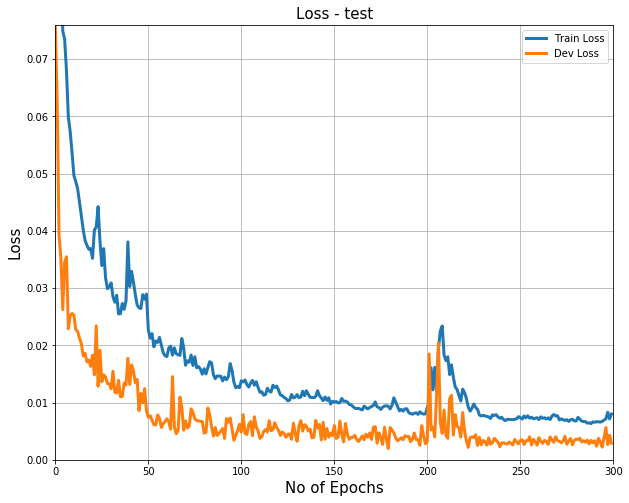

Training Set Score: 0.9371
Dev Set Score: 0.8453
Test Set Score: -6.4914
Training Set MSE: 1767.2775
Dev Set MSE: 1110.0884
Test Set MSE: 2068.6703


In [11]:
plot_loss(history_LSTM, title='test')
#plt.savefig('loss_LSTM_512_1024_lb25_well_' + str(i))
train_mse, train_acc = mean_squared_error(y_train_act, y_pred_train), r2_score(y_train_act, y_pred_train)
dev_mse, dev_acc = mean_squared_error(y_dev_act, y_pred_dev), r2_score(y_dev_act, y_pred_dev)
test_mse, test_acc = mean_squared_error(y_test_act, y_pred_test), r2_score(y_test_act, y_pred_test)

print('Training Set Score: %1.4f' % train_acc)
print('Dev Set Score: %1.4f' % dev_acc)
print('Test Set Score: %1.4f' % test_acc)

print('Training Set MSE: %1.4f' % train_mse)
print('Dev Set MSE: %1.4f' % dev_mse)
print('Test Set MSE: %1.4f' % test_mse)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


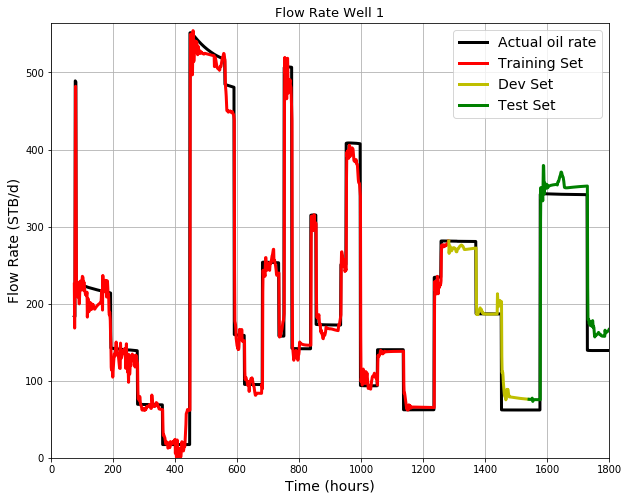

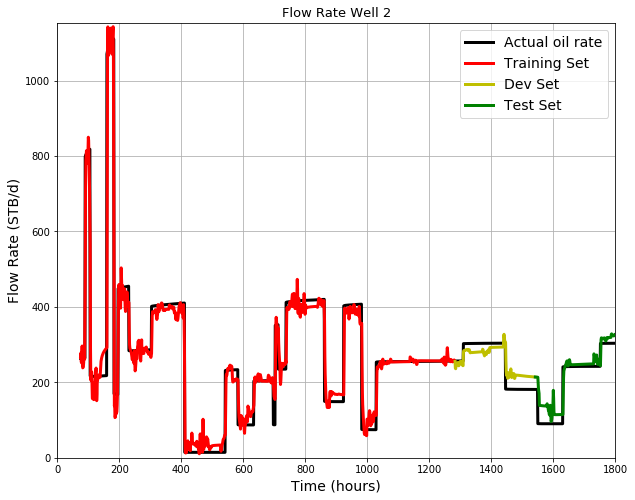

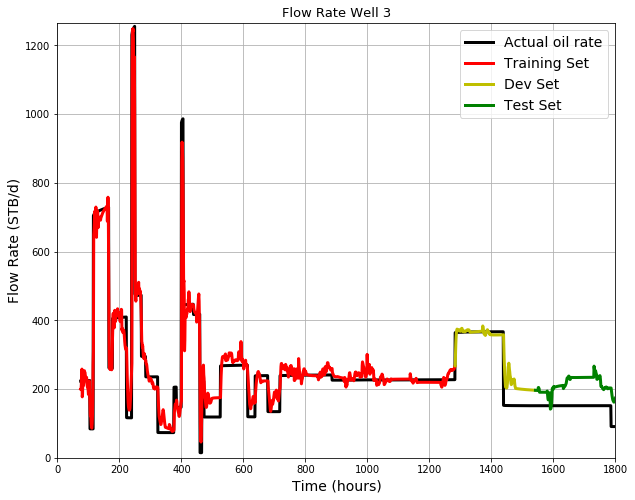

In [12]:
for i in range(y_act.shape[1]):
    plot_pred_rate(t[-len(y_act):].as_matrix(),
                   y_act[:, i], y_pred[:, i], dev_fraction=dev_fraction, test_fraction=test_fraction, well=i+1)
    plt.savefig('traindev_LSTM_512_1024_lb25_well_' + str(i))

GRU

Train on 1235 samples, validate on 245 samples
Epoch 1/300
1235/1235 [==============================] - 4s 3ms/sample - loss: 0.2858 - dense_5_loss: 0.0873 - dense_6_loss: 0.0922 - dense_7_loss: 0.0689 - dense_5_mae: 0.2662 - dense_5_accuracy: 0.0000e+00 - dense_6_mae: 0.2794 - dense_6_accuracy: 0.0000e+00 - dense_7_mae: 0.2331 - dense_7_accuracy: 0.0000e+00 - val_loss: 0.0805 - val_dense_5_loss: 0.0339 - val_dense_6_loss: 0.0173 - val_dense_7_loss: 0.0293 - val_dense_5_mae: 0.1478 - val_dense_5_accuracy: 0.0000e+00 - val_dense_6_mae: 0.0910 - val_dense_6_accuracy: 0.0000e+00 - val_dense_7_mae: 0.1213 - val_dense_7_accuracy: 0.0000e+00
Epoch 2/300
1235/1235 [==============================] - 0s 254us/sample - loss: 0.1421 - dense_5_loss: 0.0324 - dense_6_loss: 0.0586 - dense_7_loss: 0.0444 - dense_5_mae: 0.1465 - dense_5_accuracy: 0.0000e+00 - dense_6_mae: 0.1875 - dense_6_accuracy: 0.0000e+00 - dense_7_mae: 0.1551 - dense_7_accuracy: 0.0000e+00 - val_loss: 0.0636 - val_dense_5_loss: 0

Epoch 15/300
1235/1235 [==============================] - 0s 228us/sample - loss: 0.0350 - dense_5_loss: 0.0110 - dense_6_loss: 0.0101 - dense_7_loss: 0.0102 - dense_5_mae: 0.0725 - dense_5_accuracy: 0.0000e+00 - dense_6_mae: 0.0721 - dense_6_accuracy: 8.0972e-04 - dense_7_mae: 0.0671 - dense_7_accuracy: 8.0972e-04 - val_loss: 0.0196 - val_dense_5_loss: 0.0059 - val_dense_6_loss: 0.0061 - val_dense_7_loss: 0.0076 - val_dense_5_mae: 0.0661 - val_dense_5_accuracy: 0.0000e+00 - val_dense_6_mae: 0.0763 - val_dense_6_accuracy: 0.0000e+00 - val_dense_7_mae: 0.0856 - val_dense_7_accuracy: 0.0000e+00
Epoch 16/300
1235/1235 [==============================] - 0s 228us/sample - loss: 0.0340 - dense_5_loss: 0.0111 - dense_6_loss: 0.0096 - dense_7_loss: 0.0097 - dense_5_mae: 0.0820 - dense_5_accuracy: 0.0000e+00 - dense_6_mae: 0.0689 - dense_6_accuracy: 8.0972e-04 - dense_7_mae: 0.0661 - dense_7_accuracy: 8.0972e-04 - val_loss: 0.0197 - val_dense_5_loss: 0.0053 - val_dense_6_loss: 0.0064 - val_dens

Epoch 29/300
1235/1235 [==============================] - 0s 220us/sample - loss: 0.0248 - dense_5_loss: 0.0096 - dense_6_loss: 0.0063 - dense_7_loss: 0.0066 - dense_5_mae: 0.0658 - dense_5_accuracy: 0.0000e+00 - dense_6_mae: 0.0569 - dense_6_accuracy: 8.0972e-04 - dense_7_mae: 0.0544 - dense_7_accuracy: 8.0972e-04 - val_loss: 0.0121 - val_dense_5_loss: 0.0033 - val_dense_6_loss: 0.0041 - val_dense_7_loss: 0.0047 - val_dense_5_mae: 0.0498 - val_dense_5_accuracy: 0.0000e+00 - val_dense_6_mae: 0.0492 - val_dense_6_accuracy: 0.0000e+00 - val_dense_7_mae: 0.0673 - val_dense_7_accuracy: 0.0000e+00
Epoch 30/300
1235/1235 [==============================] - 0s 216us/sample - loss: 0.0276 - dense_5_loss: 0.0105 - dense_6_loss: 0.0060 - dense_7_loss: 0.0069 - dense_5_mae: 0.0845 - dense_5_accuracy: 0.0000e+00 - dense_6_mae: 0.0570 - dense_6_accuracy: 8.0972e-04 - dense_7_mae: 0.0616 - dense_7_accuracy: 8.0972e-04 - val_loss: 0.0095 - val_dense_5_loss: 0.0015 - val_dense_6_loss: 0.0041 - val_dens

Epoch 43/300
1235/1235 [==============================] - 0s 214us/sample - loss: 0.0191 - dense_5_loss: 0.0063 - dense_6_loss: 0.0050 - dense_7_loss: 0.0052 - dense_5_mae: 0.0545 - dense_5_accuracy: 0.0000e+00 - dense_6_mae: 0.0509 - dense_6_accuracy: 8.0972e-04 - dense_7_mae: 0.0500 - dense_7_accuracy: 8.0972e-04 - val_loss: 0.0096 - val_dense_5_loss: 0.0037 - val_dense_6_loss: 0.0035 - val_dense_7_loss: 0.0024 - val_dense_5_mae: 0.0527 - val_dense_5_accuracy: 0.0000e+00 - val_dense_6_mae: 0.0413 - val_dense_6_accuracy: 0.0000e+00 - val_dense_7_mae: 0.0463 - val_dense_7_accuracy: 0.0000e+00
Epoch 44/300
1235/1235 [==============================] - 0s 215us/sample - loss: 0.0176 - dense_5_loss: 0.0058 - dense_6_loss: 0.0046 - dense_7_loss: 0.0051 - dense_5_mae: 0.0510 - dense_5_accuracy: 0.0000e+00 - dense_6_mae: 0.0488 - dense_6_accuracy: 8.0972e-04 - dense_7_mae: 0.0492 - dense_7_accuracy: 8.0972e-04 - val_loss: 0.0051 - val_dense_5_loss: 0.0019 - val_dense_6_loss: 9.2148e-04 - val_

Epoch 57/300
1235/1235 [==============================] - 0s 221us/sample - loss: 0.0156 - dense_5_loss: 0.0049 - dense_6_loss: 0.0041 - dense_7_loss: 0.0043 - dense_5_mae: 0.0467 - dense_5_accuracy: 0.0000e+00 - dense_6_mae: 0.0484 - dense_6_accuracy: 8.0972e-04 - dense_7_mae: 0.0449 - dense_7_accuracy: 8.0972e-04 - val_loss: 0.0059 - val_dense_5_loss: 0.0023 - val_dense_6_loss: 0.0016 - val_dense_7_loss: 0.0020 - val_dense_5_mae: 0.0378 - val_dense_5_accuracy: 0.0000e+00 - val_dense_6_mae: 0.0383 - val_dense_6_accuracy: 0.0000e+00 - val_dense_7_mae: 0.0348 - val_dense_7_accuracy: 0.0000e+00
Epoch 58/300
1235/1235 [==============================] - 0s 219us/sample - loss: 0.0152 - dense_5_loss: 0.0059 - dense_6_loss: 0.0037 - dense_7_loss: 0.0042 - dense_5_mae: 0.0507 - dense_5_accuracy: 0.0000e+00 - dense_6_mae: 0.0408 - dense_6_accuracy: 8.0972e-04 - dense_7_mae: 0.0462 - dense_7_accuracy: 8.0972e-04 - val_loss: 0.0052 - val_dense_5_loss: 0.0018 - val_dense_6_loss: 0.0013 - val_dens

Epoch 71/300
1235/1235 [==============================] - 0s 223us/sample - loss: 0.0132 - dense_5_loss: 0.0043 - dense_6_loss: 0.0032 - dense_7_loss: 0.0039 - dense_5_mae: 0.0413 - dense_5_accuracy: 0.0000e+00 - dense_6_mae: 0.0380 - dense_6_accuracy: 8.0972e-04 - dense_7_mae: 0.0429 - dense_7_accuracy: 8.0972e-04 - val_loss: 0.0044 - val_dense_5_loss: 0.0011 - val_dense_6_loss: 0.0016 - val_dense_7_loss: 0.0016 - val_dense_5_mae: 0.0243 - val_dense_5_accuracy: 0.0000e+00 - val_dense_6_mae: 0.0313 - val_dense_6_accuracy: 0.0000e+00 - val_dense_7_mae: 0.0357 - val_dense_7_accuracy: 0.0000e+00
Epoch 72/300
1235/1235 [==============================] - 0s 222us/sample - loss: 0.0126 - dense_5_loss: 0.0039 - dense_6_loss: 0.0033 - dense_7_loss: 0.0035 - dense_5_mae: 0.0419 - dense_5_accuracy: 0.0000e+00 - dense_6_mae: 0.0365 - dense_6_accuracy: 8.0972e-04 - dense_7_mae: 0.0403 - dense_7_accuracy: 8.0972e-04 - val_loss: 0.0030 - val_dense_5_loss: 9.7279e-04 - val_dense_6_loss: 5.8182e-04 - 

Epoch 85/300
1235/1235 [==============================] - 0s 215us/sample - loss: 0.0099 - dense_5_loss: 0.0033 - dense_6_loss: 0.0025 - dense_7_loss: 0.0028 - dense_5_mae: 0.0339 - dense_5_accuracy: 0.0000e+00 - dense_6_mae: 0.0330 - dense_6_accuracy: 8.0972e-04 - dense_7_mae: 0.0348 - dense_7_accuracy: 8.0972e-04 - val_loss: 0.0029 - val_dense_5_loss: 7.7126e-04 - val_dense_6_loss: 3.7491e-04 - val_dense_7_loss: 0.0017 - val_dense_5_mae: 0.0177 - val_dense_5_accuracy: 0.0000e+00 - val_dense_6_mae: 0.0144 - val_dense_6_accuracy: 0.0000e+00 - val_dense_7_mae: 0.0353 - val_dense_7_accuracy: 0.0000e+00
Epoch 86/300
1235/1235 [==============================] - 0s 224us/sample - loss: 0.0102 - dense_5_loss: 0.0036 - dense_6_loss: 0.0026 - dense_7_loss: 0.0029 - dense_5_mae: 0.0356 - dense_5_accuracy: 0.0000e+00 - dense_6_mae: 0.0339 - dense_6_accuracy: 8.0972e-04 - dense_7_mae: 0.0340 - dense_7_accuracy: 8.0972e-04 - val_loss: 0.0040 - val_dense_5_loss: 0.0012 - val_dense_6_loss: 0.0013 - 

Epoch 99/300
1235/1235 [==============================] - 0s 215us/sample - loss: 0.0120 - dense_5_loss: 0.0036 - dense_6_loss: 0.0033 - dense_7_loss: 0.0032 - dense_5_mae: 0.0434 - dense_5_accuracy: 0.0000e+00 - dense_6_mae: 0.0412 - dense_6_accuracy: 8.0972e-04 - dense_7_mae: 0.0409 - dense_7_accuracy: 8.0972e-04 - val_loss: 0.0042 - val_dense_5_loss: 9.1929e-04 - val_dense_6_loss: 0.0015 - val_dense_7_loss: 0.0017 - val_dense_5_mae: 0.0228 - val_dense_5_accuracy: 0.0000e+00 - val_dense_6_mae: 0.0316 - val_dense_6_accuracy: 0.0000e+00 - val_dense_7_mae: 0.0290 - val_dense_7_accuracy: 0.0000e+00
Epoch 100/300
1235/1235 [==============================] - 0s 214us/sample - loss: 0.0103 - dense_5_loss: 0.0034 - dense_6_loss: 0.0026 - dense_7_loss: 0.0029 - dense_5_mae: 0.0367 - dense_5_accuracy: 0.0000e+00 - dense_6_mae: 0.0329 - dense_6_accuracy: 8.0972e-04 - dense_7_mae: 0.0371 - dense_7_accuracy: 8.0972e-04 - val_loss: 0.0046 - val_dense_5_loss: 0.0019 - val_dense_6_loss: 7.8547e-04 -

1235/1235 [==============================] - 0s 219us/sample - loss: 0.0085 - dense_5_loss: 0.0030 - dense_6_loss: 0.0021 - dense_7_loss: 0.0023 - dense_5_mae: 0.0341 - dense_5_accuracy: 0.0000e+00 - dense_6_mae: 0.0288 - dense_6_accuracy: 8.0972e-04 - dense_7_mae: 0.0308 - dense_7_accuracy: 8.0972e-04 - val_loss: 0.0024 - val_dense_5_loss: 6.3732e-04 - val_dense_6_loss: 3.5817e-04 - val_dense_7_loss: 0.0014 - val_dense_5_mae: 0.0167 - val_dense_5_accuracy: 0.0000e+00 - val_dense_6_mae: 0.0150 - val_dense_6_accuracy: 0.0000e+00 - val_dense_7_mae: 0.0269 - val_dense_7_accuracy: 0.0000e+00
Epoch 113/300
1235/1235 [==============================] - 0s 219us/sample - loss: 0.0086 - dense_5_loss: 0.0031 - dense_6_loss: 0.0022 - dense_7_loss: 0.0023 - dense_5_mae: 0.0336 - dense_5_accuracy: 0.0000e+00 - dense_6_mae: 0.0314 - dense_6_accuracy: 8.0972e-04 - dense_7_mae: 0.0286 - dense_7_accuracy: 8.0972e-04 - val_loss: 0.0027 - val_dense_5_loss: 9.1383e-04 - val_dense_6_loss: 9.1904e-04 - val_

Epoch 126/300
1235/1235 [==============================] - 0s 222us/sample - loss: 0.0095 - dense_5_loss: 0.0028 - dense_6_loss: 0.0025 - dense_7_loss: 0.0030 - dense_5_mae: 0.0333 - dense_5_accuracy: 0.0000e+00 - dense_6_mae: 0.0350 - dense_6_accuracy: 8.0972e-04 - dense_7_mae: 0.0394 - dense_7_accuracy: 8.0972e-04 - val_loss: 0.0041 - val_dense_5_loss: 0.0014 - val_dense_6_loss: 0.0016 - val_dense_7_loss: 0.0011 - val_dense_5_mae: 0.0266 - val_dense_5_accuracy: 0.0000e+00 - val_dense_6_mae: 0.0283 - val_dense_6_accuracy: 0.0000e+00 - val_dense_7_mae: 0.0308 - val_dense_7_accuracy: 0.0000e+00
Epoch 127/300
1235/1235 [==============================] - 0s 236us/sample - loss: 0.0095 - dense_5_loss: 0.0031 - dense_6_loss: 0.0025 - dense_7_loss: 0.0027 - dense_5_mae: 0.0353 - dense_5_accuracy: 0.0000e+00 - dense_6_mae: 0.0344 - dense_6_accuracy: 8.0972e-04 - dense_7_mae: 0.0335 - dense_7_accuracy: 8.0972e-04 - val_loss: 0.0035 - val_dense_5_loss: 6.5995e-04 - val_dense_6_loss: 0.0012 - va

Epoch 140/300
1235/1235 [==============================] - 0s 214us/sample - loss: 0.0101 - dense_5_loss: 0.0031 - dense_6_loss: 0.0026 - dense_7_loss: 0.0030 - dense_5_mae: 0.0351 - dense_5_accuracy: 0.0000e+00 - dense_6_mae: 0.0387 - dense_6_accuracy: 8.0972e-04 - dense_7_mae: 0.0352 - dense_7_accuracy: 8.0972e-04 - val_loss: 0.0041 - val_dense_5_loss: 0.0012 - val_dense_6_loss: 0.0014 - val_dense_7_loss: 0.0015 - val_dense_5_mae: 0.0237 - val_dense_5_accuracy: 0.0000e+00 - val_dense_6_mae: 0.0275 - val_dense_6_accuracy: 0.0000e+00 - val_dense_7_mae: 0.0355 - val_dense_7_accuracy: 0.0000e+00
Epoch 141/300
1235/1235 [==============================] - 0s 223us/sample - loss: 0.0100 - dense_5_loss: 0.0032 - dense_6_loss: 0.0022 - dense_7_loss: 0.0034 - dense_5_mae: 0.0346 - dense_5_accuracy: 0.0000e+00 - dense_6_mae: 0.0321 - dense_6_accuracy: 8.0972e-04 - dense_7_mae: 0.0411 - dense_7_accuracy: 8.0972e-04 - val_loss: 0.0030 - val_dense_5_loss: 5.4202e-04 - val_dense_6_loss: 2.9801e-04 

Epoch 154/300
1235/1235 [==============================] - 0s 215us/sample - loss: 0.0080 - dense_5_loss: 0.0030 - dense_6_loss: 0.0021 - dense_7_loss: 0.0019 - dense_5_mae: 0.0335 - dense_5_accuracy: 0.0000e+00 - dense_6_mae: 0.0299 - dense_6_accuracy: 8.0972e-04 - dense_7_mae: 0.0255 - dense_7_accuracy: 8.0972e-04 - val_loss: 0.0032 - val_dense_5_loss: 0.0014 - val_dense_6_loss: 6.7022e-04 - val_dense_7_loss: 0.0011 - val_dense_5_mae: 0.0321 - val_dense_5_accuracy: 0.0000e+00 - val_dense_6_mae: 0.0188 - val_dense_6_accuracy: 0.0000e+00 - val_dense_7_mae: 0.0249 - val_dense_7_accuracy: 0.0000e+00
Epoch 155/300
1235/1235 [==============================] - 0s 215us/sample - loss: 0.0077 - dense_5_loss: 0.0031 - dense_6_loss: 0.0018 - dense_7_loss: 0.0018 - dense_5_mae: 0.0341 - dense_5_accuracy: 0.0000e+00 - dense_6_mae: 0.0267 - dense_6_accuracy: 8.0972e-04 - dense_7_mae: 0.0257 - dense_7_accuracy: 8.0972e-04 - val_loss: 0.0026 - val_dense_5_loss: 8.5682e-04 - val_dense_6_loss: 5.2581e

1235/1235 [==============================] - 0s 216us/sample - loss: 0.0091 - dense_5_loss: 0.0026 - dense_6_loss: 0.0027 - dense_7_loss: 0.0026 - dense_5_mae: 0.0313 - dense_5_accuracy: 0.0000e+00 - dense_6_mae: 0.0392 - dense_6_accuracy: 8.0972e-04 - dense_7_mae: 0.0365 - dense_7_accuracy: 8.0972e-04 - val_loss: 0.0040 - val_dense_5_loss: 9.9374e-04 - val_dense_6_loss: 0.0017 - val_dense_7_loss: 0.0013 - val_dense_5_mae: 0.0248 - val_dense_5_accuracy: 0.0000e+00 - val_dense_6_mae: 0.0326 - val_dense_6_accuracy: 0.0000e+00 - val_dense_7_mae: 0.0293 - val_dense_7_accuracy: 0.0000e+00
Epoch 168/300
1235/1235 [==============================] - 0s 212us/sample - loss: 0.0092 - dense_5_loss: 0.0027 - dense_6_loss: 0.0034 - dense_7_loss: 0.0022 - dense_5_mae: 0.0312 - dense_5_accuracy: 0.0000e+00 - dense_6_mae: 0.0430 - dense_6_accuracy: 8.0972e-04 - dense_7_mae: 0.0284 - dense_7_accuracy: 8.0972e-04 - val_loss: 0.0041 - val_dense_5_loss: 9.4161e-04 - val_dense_6_loss: 0.0019 - val_dense_7_

Epoch 181/300
1235/1235 [==============================] - 0s 223us/sample - loss: 0.0079 - dense_5_loss: 0.0025 - dense_6_loss: 0.0020 - dense_7_loss: 0.0023 - dense_5_mae: 0.0291 - dense_5_accuracy: 0.0000e+00 - dense_6_mae: 0.0307 - dense_6_accuracy: 8.0972e-04 - dense_7_mae: 0.0322 - dense_7_accuracy: 8.0972e-04 - val_loss: 0.0059 - val_dense_5_loss: 0.0020 - val_dense_6_loss: 0.0022 - val_dense_7_loss: 0.0018 - val_dense_5_mae: 0.0369 - val_dense_5_accuracy: 0.0000e+00 - val_dense_6_mae: 0.0399 - val_dense_6_accuracy: 0.0000e+00 - val_dense_7_mae: 0.0348 - val_dense_7_accuracy: 0.0000e+00
Epoch 182/300
1235/1235 [==============================] - 0s 232us/sample - loss: 0.0090 - dense_5_loss: 0.0029 - dense_6_loss: 0.0028 - dense_7_loss: 0.0023 - dense_5_mae: 0.0336 - dense_5_accuracy: 0.0000e+00 - dense_6_mae: 0.0393 - dense_6_accuracy: 8.0972e-04 - dense_7_mae: 0.0292 - dense_7_accuracy: 8.0972e-04 - val_loss: 0.0038 - val_dense_5_loss: 7.8997e-04 - val_dense_6_loss: 0.0013 - va

1235/1235 [==============================] - 0s 215us/sample - loss: 0.0084 - dense_5_loss: 0.0030 - dense_6_loss: 0.0021 - dense_7_loss: 0.0022 - dense_5_mae: 0.0346 - dense_5_accuracy: 0.0000e+00 - dense_6_mae: 0.0306 - dense_6_accuracy: 8.0972e-04 - dense_7_mae: 0.0299 - dense_7_accuracy: 8.0972e-04 - val_loss: 0.0039 - val_dense_5_loss: 0.0013 - val_dense_6_loss: 0.0016 - val_dense_7_loss: 9.6671e-04 - val_dense_5_mae: 0.0307 - val_dense_5_accuracy: 0.0000e+00 - val_dense_6_mae: 0.0301 - val_dense_6_accuracy: 0.0000e+00 - val_dense_7_mae: 0.0288 - val_dense_7_accuracy: 0.0000e+00
Epoch 195/300
1235/1235 [==============================] - 0s 212us/sample - loss: 0.0073 - dense_5_loss: 0.0025 - dense_6_loss: 0.0018 - dense_7_loss: 0.0021 - dense_5_mae: 0.0307 - dense_5_accuracy: 0.0000e+00 - dense_6_mae: 0.0285 - dense_6_accuracy: 8.0972e-04 - dense_7_mae: 0.0277 - dense_7_accuracy: 8.0972e-04 - val_loss: 0.0033 - val_dense_5_loss: 5.2501e-04 - val_dense_6_loss: 3.4497e-04 - val_dens

Epoch 208/300
1235/1235 [==============================] - 0s 216us/sample - loss: 0.0083 - dense_5_loss: 0.0034 - dense_6_loss: 0.0018 - dense_7_loss: 0.0021 - dense_5_mae: 0.0395 - dense_5_accuracy: 0.0000e+00 - dense_6_mae: 0.0285 - dense_6_accuracy: 8.0972e-04 - dense_7_mae: 0.0290 - dense_7_accuracy: 8.0972e-04 - val_loss: 0.0036 - val_dense_5_loss: 0.0011 - val_dense_6_loss: 0.0012 - val_dense_7_loss: 0.0013 - val_dense_5_mae: 0.0260 - val_dense_5_accuracy: 0.0000e+00 - val_dense_6_mae: 0.0262 - val_dense_6_accuracy: 0.0000e+00 - val_dense_7_mae: 0.0342 - val_dense_7_accuracy: 0.0000e+00
Epoch 209/300
1235/1235 [==============================] - 0s 216us/sample - loss: 0.0082 - dense_5_loss: 0.0033 - dense_6_loss: 0.0016 - dense_7_loss: 0.0021 - dense_5_mae: 0.0378 - dense_5_accuracy: 0.0000e+00 - dense_6_mae: 0.0255 - dense_6_accuracy: 8.0972e-04 - dense_7_mae: 0.0278 - dense_7_accuracy: 8.0972e-04 - val_loss: 0.0041 - val_dense_5_loss: 0.0020 - val_dense_6_loss: 3.8083e-04 - va

1235/1235 [==============================] - 0s 302us/sample - loss: 0.0064 - dense_5_loss: 0.0022 - dense_6_loss: 0.0015 - dense_7_loss: 0.0017 - dense_5_mae: 0.0270 - dense_5_accuracy: 0.0000e+00 - dense_6_mae: 0.0253 - dense_6_accuracy: 8.0972e-04 - dense_7_mae: 0.0235 - dense_7_accuracy: 8.0972e-04 - val_loss: 0.0033 - val_dense_5_loss: 7.3195e-04 - val_dense_6_loss: 6.3622e-04 - val_dense_7_loss: 0.0019 - val_dense_5_mae: 0.0192 - val_dense_5_accuracy: 0.0000e+00 - val_dense_6_mae: 0.0183 - val_dense_6_accuracy: 0.0000e+00 - val_dense_7_mae: 0.0366 - val_dense_7_accuracy: 0.0000e+00
Epoch 222/300
1235/1235 [==============================] - 0s 253us/sample - loss: 0.0067 - dense_5_loss: 0.0022 - dense_6_loss: 0.0016 - dense_7_loss: 0.0019 - dense_5_mae: 0.0267 - dense_5_accuracy: 0.0000e+00 - dense_6_mae: 0.0257 - dense_6_accuracy: 8.0972e-04 - dense_7_mae: 0.0257 - dense_7_accuracy: 8.0972e-04 - val_loss: 0.0031 - val_dense_5_loss: 0.0013 - val_dense_6_loss: 8.3077e-04 - val_dens

Epoch 235/300
1235/1235 [==============================] - 0s 216us/sample - loss: 0.0069 - dense_5_loss: 0.0023 - dense_6_loss: 0.0016 - dense_7_loss: 0.0020 - dense_5_mae: 0.0266 - dense_5_accuracy: 0.0000e+00 - dense_6_mae: 0.0263 - dense_6_accuracy: 8.0972e-04 - dense_7_mae: 0.0254 - dense_7_accuracy: 8.0972e-04 - val_loss: 0.0029 - val_dense_5_loss: 7.8436e-04 - val_dense_6_loss: 2.8423e-04 - val_dense_7_loss: 0.0019 - val_dense_5_mae: 0.0215 - val_dense_5_accuracy: 0.0000e+00 - val_dense_6_mae: 0.0118 - val_dense_6_accuracy: 0.0000e+00 - val_dense_7_mae: 0.0361 - val_dense_7_accuracy: 0.0000e+00
Epoch 236/300
1235/1235 [==============================] - 0s 233us/sample - loss: 0.0070 - dense_5_loss: 0.0023 - dense_6_loss: 0.0018 - dense_7_loss: 0.0020 - dense_5_mae: 0.0275 - dense_5_accuracy: 0.0000e+00 - dense_6_mae: 0.0279 - dense_6_accuracy: 8.0972e-04 - dense_7_mae: 0.0265 - dense_7_accuracy: 8.0972e-04 - val_loss: 0.0036 - val_dense_5_loss: 0.0011 - val_dense_6_loss: 0.0015 

1235/1235 [==============================] - 0s 220us/sample - loss: 0.0117 - dense_5_loss: 0.0058 - dense_6_loss: 0.0024 - dense_7_loss: 0.0019 - dense_5_mae: 0.0666 - dense_5_accuracy: 0.0000e+00 - dense_6_mae: 0.0353 - dense_6_accuracy: 8.0972e-04 - dense_7_mae: 0.0257 - dense_7_accuracy: 8.0972e-04 - val_loss: 0.0019 - val_dense_5_loss: 0.0013 - val_dense_6_loss: 2.2537e-04 - val_dense_7_loss: 4.3148e-04 - val_dense_5_mae: 0.0253 - val_dense_5_accuracy: 0.0000e+00 - val_dense_6_mae: 0.0090 - val_dense_6_accuracy: 0.0000e+00 - val_dense_7_mae: 0.0130 - val_dense_7_accuracy: 0.0000e+00
Epoch 249/300
1235/1235 [==============================] - 0s 214us/sample - loss: 0.0122 - dense_5_loss: 0.0055 - dense_6_loss: 0.0021 - dense_7_loss: 0.0029 - dense_5_mae: 0.0627 - dense_5_accuracy: 0.0000e+00 - dense_6_mae: 0.0323 - dense_6_accuracy: 8.0972e-04 - dense_7_mae: 0.0383 - dense_7_accuracy: 8.0972e-04 - val_loss: 0.0015 - val_dense_5_loss: 3.5759e-04 - val_dense_6_loss: 5.5662e-04 - val_

Epoch 262/300
1235/1235 [==============================] - 0s 224us/sample - loss: 0.0532 - dense_5_loss: 0.0294 - dense_6_loss: 0.0111 - dense_7_loss: 0.0101 - dense_5_mae: 0.1269 - dense_5_accuracy: 0.0000e+00 - dense_6_mae: 0.0834 - dense_6_accuracy: 8.0972e-04 - dense_7_mae: 0.0724 - dense_7_accuracy: 8.0972e-04 - val_loss: 0.0097 - val_dense_5_loss: 0.0051 - val_dense_6_loss: 0.0020 - val_dense_7_loss: 0.0025 - val_dense_5_mae: 0.0628 - val_dense_5_accuracy: 0.0000e+00 - val_dense_6_mae: 0.0420 - val_dense_6_accuracy: 0.0000e+00 - val_dense_7_mae: 0.0494 - val_dense_7_accuracy: 0.0000e+00
Epoch 263/300
1235/1235 [==============================] - 0s 222us/sample - loss: 0.0366 - dense_5_loss: 0.0218 - dense_6_loss: 0.0044 - dense_7_loss: 0.0050 - dense_5_mae: 0.1259 - dense_5_accuracy: 0.0000e+00 - dense_6_mae: 0.0496 - dense_6_accuracy: 8.0972e-04 - dense_7_mae: 0.0505 - dense_7_accuracy: 8.0972e-04 - val_loss: 0.0128 - val_dense_5_loss: 0.0093 - val_dense_6_loss: 0.0013 - val_de

Epoch 276/300
1235/1235 [==============================] - 0s 215us/sample - loss: 0.0091 - dense_5_loss: 0.0033 - dense_6_loss: 0.0022 - dense_7_loss: 0.0024 - dense_5_mae: 0.0362 - dense_5_accuracy: 0.0000e+00 - dense_6_mae: 0.0312 - dense_6_accuracy: 8.0972e-04 - dense_7_mae: 0.0331 - dense_7_accuracy: 8.0972e-04 - val_loss: 0.0022 - val_dense_5_loss: 4.5617e-04 - val_dense_6_loss: 0.0011 - val_dense_7_loss: 5.7543e-04 - val_dense_5_mae: 0.0127 - val_dense_5_accuracy: 0.0000e+00 - val_dense_6_mae: 0.0288 - val_dense_6_accuracy: 0.0000e+00 - val_dense_7_mae: 0.0156 - val_dense_7_accuracy: 0.0000e+00
Epoch 277/300
1235/1235 [==============================] - 0s 217us/sample - loss: 0.0092 - dense_5_loss: 0.0035 - dense_6_loss: 0.0024 - dense_7_loss: 0.0022 - dense_5_mae: 0.0391 - dense_5_accuracy: 0.0000e+00 - dense_6_mae: 0.0360 - dense_6_accuracy: 8.0972e-04 - dense_7_mae: 0.0276 - dense_7_accuracy: 8.0972e-04 - val_loss: 0.0039 - val_dense_5_loss: 0.0018 - val_dense_6_loss: 4.3878e

1235/1235 [==============================] - 0s 213us/sample - loss: 0.0070 - dense_5_loss: 0.0026 - dense_6_loss: 0.0016 - dense_7_loss: 0.0019 - dense_5_mae: 0.0292 - dense_5_accuracy: 0.0000e+00 - dense_6_mae: 0.0261 - dense_6_accuracy: 8.0972e-04 - dense_7_mae: 0.0238 - dense_7_accuracy: 8.0972e-04 - val_loss: 0.0020 - val_dense_5_loss: 6.7038e-04 - val_dense_6_loss: 3.7753e-04 - val_dense_7_loss: 9.0483e-04 - val_dense_5_mae: 0.0167 - val_dense_5_accuracy: 0.0000e+00 - val_dense_6_mae: 0.0123 - val_dense_6_accuracy: 0.0000e+00 - val_dense_7_mae: 0.0233 - val_dense_7_accuracy: 0.0000e+00
Epoch 290/300
1235/1235 [==============================] - 0s 218us/sample - loss: 0.0070 - dense_5_loss: 0.0025 - dense_6_loss: 0.0016 - dense_7_loss: 0.0019 - dense_5_mae: 0.0285 - dense_5_accuracy: 0.0000e+00 - dense_6_mae: 0.0260 - dense_6_accuracy: 8.0972e-04 - dense_7_mae: 0.0238 - dense_7_accuracy: 8.0972e-04 - val_loss: 0.0021 - val_dense_5_loss: 5.6752e-04 - val_dense_6_loss: 7.1444e-04 - 

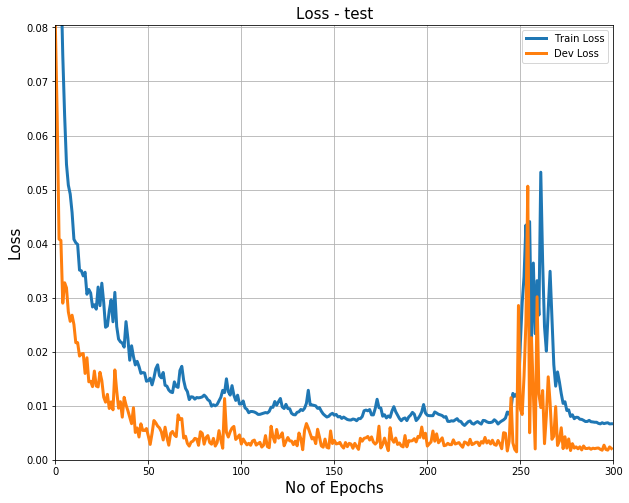

Training Set Score: 0.9431
Dev Set Score: 0.8861
Test Set Score: -2.2309
Training Set MSE: 1587.3113
Dev Set MSE: 773.9691
Test Set MSE: 1126.0272


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:40: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


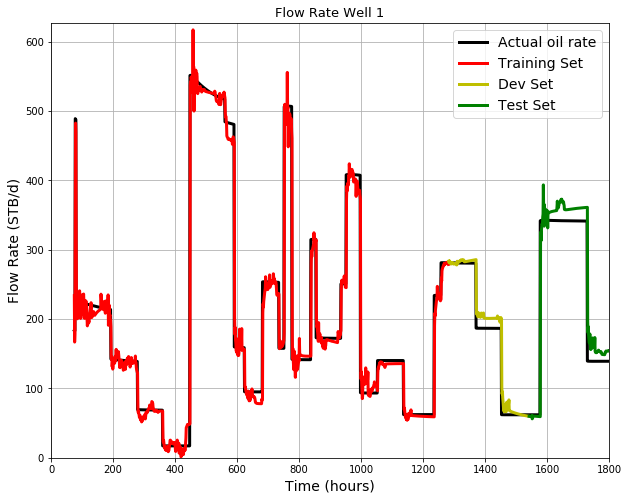

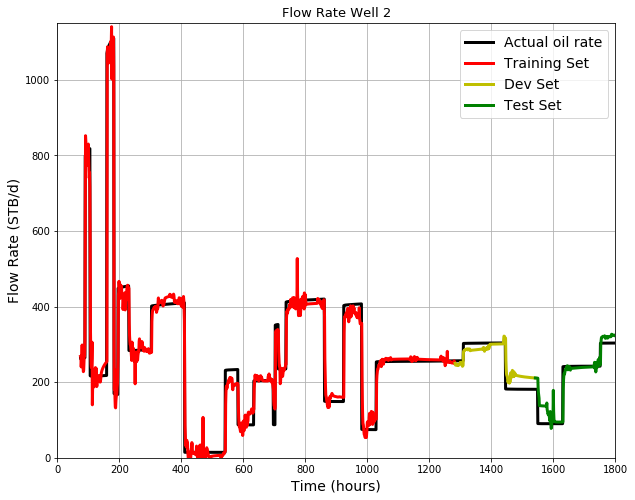

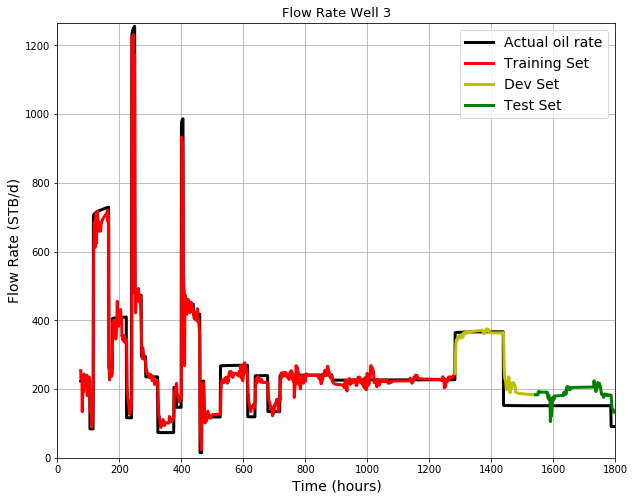

In [13]:
model_GRU, history_GRU = run_model(x_train, y_train, x_dev, y_dev, epochs=300, batch_size=300, method='GRU')

# Training
y_pred_train_pre = model_GRU.predict(x_train)
y_pred_train_scaled = np.concatenate((y_pred_train_pre[0], y_pred_train_pre[1], y_pred_train_pre[2]), axis=1)
y_pred_train = scaler_y.inverse_transform(y_pred_train_scaled)
y_train_act = scaler_y.inverse_transform(y_train)

# Dev
y_pred_dev_pre = model_GRU.predict(x_dev)
y_pred_dev_scaled = np.concatenate((y_pred_dev_pre[0], y_pred_dev_pre[1], y_pred_dev_pre[2]), axis=1)
y_pred_dev = scaler_y.inverse_transform(y_pred_dev_scaled)
y_dev_act = scaler_y.inverse_transform(y_dev)

# Test
y_pred_test_pre = model_GRU.predict(x_test)
y_pred_test_scaled = np.concatenate((y_pred_test_pre[0], y_pred_test_pre[1], y_pred_test_pre[2]), axis=1)
y_pred_test = scaler_y.inverse_transform(y_pred_test_scaled)
y_test_act = scaler_y.inverse_transform(y_test)

# Train-Dev-Test
y_act = np.concatenate([y_train_act, y_dev_act, y_test_act])
y_pred = np.concatenate([y_pred_train, y_pred_dev, y_pred_test])

plot_loss(history_GRU, title='test')
#plt.savefig('loss_LSTM_512_1024_lb25_well_' + str(i))
train_mse, train_acc = mean_squared_error(y_train_act, y_pred_train), r2_score(y_train_act, y_pred_train)
dev_mse, dev_acc = mean_squared_error(y_dev_act, y_pred_dev), r2_score(y_dev_act, y_pred_dev)
test_mse, test_acc = mean_squared_error(y_test_act, y_pred_test), r2_score(y_test_act, y_pred_test)

print('Training Set Score: %1.4f' % train_acc)
print('Dev Set Score: %1.4f' % dev_acc)
print('Test Set Score: %1.4f' % test_acc)

print('Training Set MSE: %1.4f' % train_mse)
print('Dev Set MSE: %1.4f' % dev_mse)
print('Test Set MSE: %1.4f' % test_mse)

for i in range(y_act.shape[1]):
    plot_pred_rate(t[-len(y_act):].as_matrix(),
                   y_act[:, i], y_pred[:, i], dev_fraction=dev_fraction, test_fraction=test_fraction, well=i+1)
    plt.savefig('traindev_LSTM_512_1024_lb25_well_' + str(i))

Simple RNN

Train on 1235 samples, validate on 245 samples
Epoch 1/300
1235/1235 [==============================] - 3s 2ms/sample - loss: 12.0172 - dense_9_loss: 3.1418 - dense_10_loss: 6.7121 - dense_11_loss: 0.4486 - dense_9_mae: 1.6138 - dense_9_accuracy: 0.0000e+00 - dense_10_mae: 2.2232 - dense_10_accuracy: 0.0000e+00 - dense_11_mae: 0.5220 - dense_11_accuracy: 0.0000e+00 - val_loss: 8.3104 - val_dense_9_loss: 0.5485 - val_dense_10_loss: 6.6026 - val_dense_11_loss: 1.1593 - val_dense_9_mae: 0.7159 - val_dense_9_accuracy: 0.0000e+00 - val_dense_10_mae: 2.5654 - val_dense_10_accuracy: 0.0000e+00 - val_dense_11_mae: 1.0658 - val_dense_11_accuracy: 0.0000e+00
Epoch 2/300
1235/1235 [==============================] - 0s 176us/sample - loss: 11.0136 - dense_9_loss: 2.7927 - dense_10_loss: 4.4034 - dense_11_loss: 4.7120 - dense_9_mae: 1.4244 - dense_9_accuracy: 0.0000e+00 - dense_10_mae: 1.9801 - dense_10_accuracy: 8.0972e-04 - dense_11_mae: 1.4464 - dense_11_accuracy: 0.0000e+00 - val_loss: 1.9158 -

1235/1235 [==============================] - 0s 204us/sample - loss: 0.1816 - dense_9_loss: 0.0705 - dense_10_loss: 0.0526 - dense_11_loss: 0.0446 - dense_9_mae: 0.2224 - dense_9_accuracy: 0.0000e+00 - dense_10_mae: 0.1894 - dense_10_accuracy: 0.0000e+00 - dense_11_mae: 0.1687 - dense_11_accuracy: 0.0000e+00 - val_loss: 0.0193 - val_dense_9_loss: 0.0087 - val_dense_10_loss: 0.0032 - val_dense_11_loss: 0.0074 - val_dense_9_mae: 0.0803 - val_dense_9_accuracy: 0.0000e+00 - val_dense_10_mae: 0.0520 - val_dense_10_accuracy: 0.0000e+00 - val_dense_11_mae: 0.0669 - val_dense_11_accuracy: 0.0000e+00
Epoch 15/300
1235/1235 [==============================] - 0s 194us/sample - loss: 0.1449 - dense_9_loss: 0.0523 - dense_10_loss: 0.0393 - dense_11_loss: 0.0350 - dense_9_mae: 0.1960 - dense_9_accuracy: 0.0000e+00 - dense_10_mae: 0.1562 - dense_10_accuracy: 0.0000e+00 - dense_11_mae: 0.1489 - dense_11_accuracy: 0.0000e+00 - val_loss: 0.0193 - val_dense_9_loss: 0.0109 - val_dense_10_loss: 0.0043 - va

1235/1235 [==============================] - 0s 167us/sample - loss: 0.0780 - dense_9_loss: 0.0308 - dense_10_loss: 0.0202 - dense_11_loss: 0.0154 - dense_9_mae: 0.1400 - dense_9_accuracy: 0.0000e+00 - dense_10_mae: 0.1076 - dense_10_accuracy: 0.0000e+00 - dense_11_mae: 0.0816 - dense_11_accuracy: 0.0000e+00 - val_loss: 0.0147 - val_dense_9_loss: 0.0091 - val_dense_10_loss: 0.0020 - val_dense_11_loss: 0.0036 - val_dense_9_mae: 0.0786 - val_dense_9_accuracy: 0.0000e+00 - val_dense_10_mae: 0.0359 - val_dense_10_accuracy: 0.0000e+00 - val_dense_11_mae: 0.0576 - val_dense_11_accuracy: 0.0000e+00
Epoch 28/300
1235/1235 [==============================] - 0s 181us/sample - loss: 0.0776 - dense_9_loss: 0.0306 - dense_10_loss: 0.0196 - dense_11_loss: 0.0154 - dense_9_mae: 0.1403 - dense_9_accuracy: 0.0000e+00 - dense_10_mae: 0.1068 - dense_10_accuracy: 0.0000e+00 - dense_11_mae: 0.0868 - dense_11_accuracy: 0.0000e+00 - val_loss: 0.0164 - val_dense_9_loss: 0.0109 - val_dense_10_loss: 0.0022 - va

1235/1235 [==============================] - 0s 199us/sample - loss: 0.0738 - dense_9_loss: 0.0277 - dense_10_loss: 0.0196 - dense_11_loss: 0.0150 - dense_9_mae: 0.1331 - dense_9_accuracy: 0.0000e+00 - dense_10_mae: 0.1066 - dense_10_accuracy: 0.0000e+00 - dense_11_mae: 0.0859 - dense_11_accuracy: 0.0000e+00 - val_loss: 0.0126 - val_dense_9_loss: 0.0081 - val_dense_10_loss: 0.0016 - val_dense_11_loss: 0.0028 - val_dense_9_mae: 0.0756 - val_dense_9_accuracy: 0.0000e+00 - val_dense_10_mae: 0.0319 - val_dense_10_accuracy: 0.0000e+00 - val_dense_11_mae: 0.0496 - val_dense_11_accuracy: 0.0000e+00
Epoch 41/300
1235/1235 [==============================] - 0s 183us/sample - loss: 0.0718 - dense_9_loss: 0.0277 - dense_10_loss: 0.0184 - dense_11_loss: 0.0144 - dense_9_mae: 0.1339 - dense_9_accuracy: 0.0000e+00 - dense_10_mae: 0.1032 - dense_10_accuracy: 0.0000e+00 - dense_11_mae: 0.0812 - dense_11_accuracy: 0.0000e+00 - val_loss: 0.0094 - val_dense_9_loss: 0.0053 - val_dense_10_loss: 0.0012 - va

1235/1235 [==============================] - 0s 185us/sample - loss: 0.0712 - dense_9_loss: 0.0264 - dense_10_loss: 0.0189 - dense_11_loss: 0.0145 - dense_9_mae: 0.1278 - dense_9_accuracy: 0.0000e+00 - dense_10_mae: 0.1028 - dense_10_accuracy: 0.0000e+00 - dense_11_mae: 0.0849 - dense_11_accuracy: 0.0000e+00 - val_loss: 0.0106 - val_dense_9_loss: 0.0060 - val_dense_10_loss: 0.0019 - val_dense_11_loss: 0.0026 - val_dense_9_mae: 0.0637 - val_dense_9_accuracy: 0.0000e+00 - val_dense_10_mae: 0.0342 - val_dense_10_accuracy: 0.0000e+00 - val_dense_11_mae: 0.0465 - val_dense_11_accuracy: 0.0000e+00
Epoch 54/300
1235/1235 [==============================] - 0s 164us/sample - loss: 0.0696 - dense_9_loss: 0.0266 - dense_10_loss: 0.0181 - dense_11_loss: 0.0140 - dense_9_mae: 0.1280 - dense_9_accuracy: 0.0000e+00 - dense_10_mae: 0.1018 - dense_10_accuracy: 0.0000e+00 - dense_11_mae: 0.0802 - dense_11_accuracy: 0.0000e+00 - val_loss: 0.0095 - val_dense_9_loss: 0.0060 - val_dense_10_loss: 0.0011 - va

1235/1235 [==============================] - 0s 165us/sample - loss: 0.0777 - dense_9_loss: 0.0333 - dense_10_loss: 0.0183 - dense_11_loss: 0.0156 - dense_9_mae: 0.1426 - dense_9_accuracy: 0.0000e+00 - dense_10_mae: 0.1025 - dense_10_accuracy: 0.0000e+00 - dense_11_mae: 0.0881 - dense_11_accuracy: 0.0000e+00 - val_loss: 0.0086 - val_dense_9_loss: 0.0039 - val_dense_10_loss: 0.0012 - val_dense_11_loss: 0.0035 - val_dense_9_mae: 0.0500 - val_dense_9_accuracy: 0.0000e+00 - val_dense_10_mae: 0.0254 - val_dense_10_accuracy: 0.0000e+00 - val_dense_11_mae: 0.0533 - val_dense_11_accuracy: 0.0000e+00
Epoch 67/300
1235/1235 [==============================] - 0s 165us/sample - loss: 0.0757 - dense_9_loss: 0.0299 - dense_10_loss: 0.0194 - dense_11_loss: 0.0147 - dense_9_mae: 0.1354 - dense_9_accuracy: 0.0000e+00 - dense_10_mae: 0.1035 - dense_10_accuracy: 0.0000e+00 - dense_11_mae: 0.0834 - dense_11_accuracy: 0.0000e+00 - val_loss: 0.0305 - val_dense_9_loss: 0.0231 - val_dense_10_loss: 0.0035 - va

1235/1235 [==============================] - 0s 216us/sample - loss: 0.0687 - dense_9_loss: 0.0266 - dense_10_loss: 0.0185 - dense_11_loss: 0.0133 - dense_9_mae: 0.1314 - dense_9_accuracy: 0.0000e+00 - dense_10_mae: 0.1017 - dense_10_accuracy: 0.0000e+00 - dense_11_mae: 0.0736 - dense_11_accuracy: 0.0000e+00 - val_loss: 0.0252 - val_dense_9_loss: 0.0186 - val_dense_10_loss: 0.0031 - val_dense_11_loss: 0.0035 - val_dense_9_mae: 0.1287 - val_dense_9_accuracy: 0.0000e+00 - val_dense_10_mae: 0.0431 - val_dense_10_accuracy: 0.0000e+00 - val_dense_11_mae: 0.0460 - val_dense_11_accuracy: 0.0000e+00
Epoch 80/300
1235/1235 [==============================] - 0s 182us/sample - loss: 0.0648 - dense_9_loss: 0.0242 - dense_10_loss: 0.0174 - dense_11_loss: 0.0147 - dense_9_mae: 0.1263 - dense_9_accuracy: 0.0000e+00 - dense_10_mae: 0.0968 - dense_10_accuracy: 0.0000e+00 - dense_11_mae: 0.0859 - dense_11_accuracy: 0.0000e+00 - val_loss: 0.0080 - val_dense_9_loss: 0.0034 - val_dense_10_loss: 0.0015 - va

1235/1235 [==============================] - 0s 166us/sample - loss: 0.0615 - dense_9_loss: 0.0205 - dense_10_loss: 0.0175 - dense_11_loss: 0.0159 - dense_9_mae: 0.1166 - dense_9_accuracy: 0.0000e+00 - dense_10_mae: 0.0970 - dense_10_accuracy: 0.0000e+00 - dense_11_mae: 0.0925 - dense_11_accuracy: 0.0000e+00 - val_loss: 0.0069 - val_dense_9_loss: 0.0024 - val_dense_10_loss: 0.0011 - val_dense_11_loss: 0.0034 - val_dense_9_mae: 0.0394 - val_dense_9_accuracy: 0.0000e+00 - val_dense_10_mae: 0.0229 - val_dense_10_accuracy: 0.0000e+00 - val_dense_11_mae: 0.0500 - val_dense_11_accuracy: 0.0000e+00
Epoch 93/300
1235/1235 [==============================] - 0s 163us/sample - loss: 0.0639 - dense_9_loss: 0.0194 - dense_10_loss: 0.0196 - dense_11_loss: 0.0149 - dense_9_mae: 0.1137 - dense_9_accuracy: 0.0000e+00 - dense_10_mae: 0.1067 - dense_10_accuracy: 0.0000e+00 - dense_11_mae: 0.0853 - dense_11_accuracy: 0.0000e+00 - val_loss: 0.0056 - val_dense_9_loss: 0.0016 - val_dense_10_loss: 0.0011 - va

1235/1235 [==============================] - 0s 188us/sample - loss: 0.0623 - dense_9_loss: 0.0219 - dense_10_loss: 0.0180 - dense_11_loss: 0.0143 - dense_9_mae: 0.1120 - dense_9_accuracy: 0.0000e+00 - dense_10_mae: 0.1004 - dense_10_accuracy: 0.0000e+00 - dense_11_mae: 0.0778 - dense_11_accuracy: 0.0000e+00 - val_loss: 0.0092 - val_dense_9_loss: 0.0029 - val_dense_10_loss: 0.0030 - val_dense_11_loss: 0.0032 - val_dense_9_mae: 0.0434 - val_dense_9_accuracy: 0.0000e+00 - val_dense_10_mae: 0.0438 - val_dense_10_accuracy: 0.0000e+00 - val_dense_11_mae: 0.0527 - val_dense_11_accuracy: 0.0000e+00
Epoch 106/300
1235/1235 [==============================] - 0s 179us/sample - loss: 0.0640 - dense_9_loss: 0.0218 - dense_10_loss: 0.0183 - dense_11_loss: 0.0143 - dense_9_mae: 0.1127 - dense_9_accuracy: 0.0000e+00 - dense_10_mae: 0.1050 - dense_10_accuracy: 0.0000e+00 - dense_11_mae: 0.0827 - dense_11_accuracy: 0.0000e+00 - val_loss: 0.0172 - val_dense_9_loss: 0.0138 - val_dense_10_loss: 9.5640e-04

1235/1235 [==============================] - 0s 168us/sample - loss: 0.0632 - dense_9_loss: 0.0249 - dense_10_loss: 0.0182 - dense_11_loss: 0.0134 - dense_9_mae: 0.1279 - dense_9_accuracy: 0.0000e+00 - dense_10_mae: 0.1022 - dense_10_accuracy: 0.0000e+00 - dense_11_mae: 0.0779 - dense_11_accuracy: 0.0000e+00 - val_loss: 0.0097 - val_dense_9_loss: 0.0042 - val_dense_10_loss: 0.0025 - val_dense_11_loss: 0.0030 - val_dense_9_mae: 0.0555 - val_dense_9_accuracy: 0.0000e+00 - val_dense_10_mae: 0.0401 - val_dense_10_accuracy: 0.0000e+00 - val_dense_11_mae: 0.0499 - val_dense_11_accuracy: 0.0000e+00
Epoch 119/300
1235/1235 [==============================] - 0s 170us/sample - loss: 0.0694 - dense_9_loss: 0.0216 - dense_10_loss: 0.0211 - dense_11_loss: 0.0164 - dense_9_mae: 0.1267 - dense_9_accuracy: 0.0000e+00 - dense_10_mae: 0.1147 - dense_10_accuracy: 0.0000e+00 - dense_11_mae: 0.0960 - dense_11_accuracy: 0.0000e+00 - val_loss: 0.0102 - val_dense_9_loss: 0.0027 - val_dense_10_loss: 0.0026 - v

1235/1235 [==============================] - 0s 176us/sample - loss: 0.0562 - dense_9_loss: 0.0152 - dense_10_loss: 0.0184 - dense_11_loss: 0.0143 - dense_9_mae: 0.0935 - dense_9_accuracy: 0.0000e+00 - dense_10_mae: 0.1054 - dense_10_accuracy: 8.0972e-04 - dense_11_mae: 0.0828 - dense_11_accuracy: 0.0000e+00 - val_loss: 0.0065 - val_dense_9_loss: 0.0034 - val_dense_10_loss: 0.0011 - val_dense_11_loss: 0.0021 - val_dense_9_mae: 0.0452 - val_dense_9_accuracy: 0.0000e+00 - val_dense_10_mae: 0.0199 - val_dense_10_accuracy: 0.0000e+00 - val_dense_11_mae: 0.0362 - val_dense_11_accuracy: 0.0000e+00
Epoch 132/300
1235/1235 [==============================] - 0s 176us/sample - loss: 0.0555 - dense_9_loss: 0.0144 - dense_10_loss: 0.0186 - dense_11_loss: 0.0140 - dense_9_mae: 0.0952 - dense_9_accuracy: 0.0000e+00 - dense_10_mae: 0.0995 - dense_10_accuracy: 0.0000e+00 - dense_11_mae: 0.0788 - dense_11_accuracy: 0.0000e+00 - val_loss: 0.0068 - val_dense_9_loss: 0.0020 - val_dense_10_loss: 0.0022 - v

1235/1235 [==============================] - 0s 177us/sample - loss: 0.0552 - dense_9_loss: 0.0182 - dense_10_loss: 0.0159 - dense_11_loss: 0.0132 - dense_9_mae: 0.1019 - dense_9_accuracy: 0.0000e+00 - dense_10_mae: 0.0959 - dense_10_accuracy: 8.0972e-04 - dense_11_mae: 0.0792 - dense_11_accuracy: 0.0000e+00 - val_loss: 0.0194 - val_dense_9_loss: 0.0147 - val_dense_10_loss: 0.0021 - val_dense_11_loss: 0.0026 - val_dense_9_mae: 0.1168 - val_dense_9_accuracy: 0.0000e+00 - val_dense_10_mae: 0.0288 - val_dense_10_accuracy: 0.0000e+00 - val_dense_11_mae: 0.0444 - val_dense_11_accuracy: 0.0000e+00
Epoch 145/300
1235/1235 [==============================] - 0s 163us/sample - loss: 0.0574 - dense_9_loss: 0.0196 - dense_10_loss: 0.0176 - dense_11_loss: 0.0133 - dense_9_mae: 0.1067 - dense_9_accuracy: 0.0000e+00 - dense_10_mae: 0.1016 - dense_10_accuracy: 0.0000e+00 - dense_11_mae: 0.0813 - dense_11_accuracy: 0.0000e+00 - val_loss: 0.0118 - val_dense_9_loss: 0.0053 - val_dense_10_loss: 0.0033 - v

1235/1235 [==============================] - 0s 166us/sample - loss: 0.0547 - dense_9_loss: 0.0170 - dense_10_loss: 0.0175 - dense_11_loss: 0.0132 - dense_9_mae: 0.0971 - dense_9_accuracy: 0.0000e+00 - dense_10_mae: 0.1010 - dense_10_accuracy: 0.0000e+00 - dense_11_mae: 0.0756 - dense_11_accuracy: 0.0000e+00 - val_loss: 0.0073 - val_dense_9_loss: 0.0016 - val_dense_10_loss: 0.0032 - val_dense_11_loss: 0.0024 - val_dense_9_mae: 0.0293 - val_dense_9_accuracy: 0.0000e+00 - val_dense_10_mae: 0.0429 - val_dense_10_accuracy: 0.0000e+00 - val_dense_11_mae: 0.0423 - val_dense_11_accuracy: 0.0000e+00
Epoch 158/300
1235/1235 [==============================] - 0s 164us/sample - loss: 0.0556 - dense_9_loss: 0.0196 - dense_10_loss: 0.0154 - dense_11_loss: 0.0128 - dense_9_mae: 0.1051 - dense_9_accuracy: 0.0000e+00 - dense_10_mae: 0.0953 - dense_10_accuracy: 8.0972e-04 - dense_11_mae: 0.0780 - dense_11_accuracy: 0.0000e+00 - val_loss: 0.0174 - val_dense_9_loss: 0.0124 - val_dense_10_loss: 0.0028 - v

1235/1235 [==============================] - 0s 171us/sample - loss: 0.0567 - dense_9_loss: 0.0232 - dense_10_loss: 0.0156 - dense_11_loss: 0.0125 - dense_9_mae: 0.1177 - dense_9_accuracy: 0.0000e+00 - dense_10_mae: 0.0990 - dense_10_accuracy: 8.0972e-04 - dense_11_mae: 0.0731 - dense_11_accuracy: 0.0000e+00 - val_loss: 0.0108 - val_dense_9_loss: 0.0048 - val_dense_10_loss: 0.0020 - val_dense_11_loss: 0.0040 - val_dense_9_mae: 0.0579 - val_dense_9_accuracy: 0.0000e+00 - val_dense_10_mae: 0.0335 - val_dense_10_accuracy: 0.0000e+00 - val_dense_11_mae: 0.0412 - val_dense_11_accuracy: 0.0000e+00
Epoch 171/300
1235/1235 [==============================] - 0s 222us/sample - loss: 0.0614 - dense_9_loss: 0.0191 - dense_10_loss: 0.0175 - dense_11_loss: 0.0163 - dense_9_mae: 0.1207 - dense_9_accuracy: 0.0000e+00 - dense_10_mae: 0.1011 - dense_10_accuracy: 0.0000e+00 - dense_11_mae: 0.0941 - dense_11_accuracy: 0.0000e+00 - val_loss: 0.0120 - val_dense_9_loss: 0.0038 - val_dense_10_loss: 0.0015 - v

1235/1235 [==============================] - 0s 174us/sample - loss: 0.0454 - dense_9_loss: 0.0118 - dense_10_loss: 0.0147 - dense_11_loss: 0.0121 - dense_9_mae: 0.0810 - dense_9_accuracy: 0.0000e+00 - dense_10_mae: 0.0946 - dense_10_accuracy: 8.0972e-04 - dense_11_mae: 0.0739 - dense_11_accuracy: 0.0000e+00 - val_loss: 0.0100 - val_dense_9_loss: 0.0045 - val_dense_10_loss: 0.0028 - val_dense_11_loss: 0.0026 - val_dense_9_mae: 0.0540 - val_dense_9_accuracy: 0.0000e+00 - val_dense_10_mae: 0.0448 - val_dense_10_accuracy: 0.0000e+00 - val_dense_11_mae: 0.0426 - val_dense_11_accuracy: 0.0000e+00
Epoch 184/300
1235/1235 [==============================] - 0s 176us/sample - loss: 0.0472 - dense_9_loss: 0.0125 - dense_10_loss: 0.0149 - dense_11_loss: 0.0133 - dense_9_mae: 0.0855 - dense_9_accuracy: 0.0000e+00 - dense_10_mae: 0.0958 - dense_10_accuracy: 8.0972e-04 - dense_11_mae: 0.0802 - dense_11_accuracy: 0.0000e+00 - val_loss: 0.0061 - val_dense_9_loss: 0.0013 - val_dense_10_loss: 0.0018 - v

1235/1235 [==============================] - 0s 202us/sample - loss: 0.0511 - dense_9_loss: 0.0143 - dense_10_loss: 0.0168 - dense_11_loss: 0.0133 - dense_9_mae: 0.0970 - dense_9_accuracy: 0.0000e+00 - dense_10_mae: 0.1058 - dense_10_accuracy: 8.0972e-04 - dense_11_mae: 0.0818 - dense_11_accuracy: 0.0000e+00 - val_loss: 0.0088 - val_dense_9_loss: 0.0031 - val_dense_10_loss: 0.0019 - val_dense_11_loss: 0.0039 - val_dense_9_mae: 0.0460 - val_dense_9_accuracy: 0.0000e+00 - val_dense_10_mae: 0.0341 - val_dense_10_accuracy: 0.0000e+00 - val_dense_11_mae: 0.0526 - val_dense_11_accuracy: 0.0000e+00
Epoch 197/300
1235/1235 [==============================] - 0s 174us/sample - loss: 0.0490 - dense_9_loss: 0.0133 - dense_10_loss: 0.0152 - dense_11_loss: 0.0131 - dense_9_mae: 0.0940 - dense_9_accuracy: 0.0000e+00 - dense_10_mae: 0.0910 - dense_10_accuracy: 8.0972e-04 - dense_11_mae: 0.0780 - dense_11_accuracy: 0.0000e+00 - val_loss: 0.0106 - val_dense_9_loss: 0.0019 - val_dense_10_loss: 0.0047 - v

1235/1235 [==============================] - 0s 172us/sample - loss: 0.0444 - dense_9_loss: 0.0111 - dense_10_loss: 0.0142 - dense_11_loss: 0.0124 - dense_9_mae: 0.0829 - dense_9_accuracy: 0.0000e+00 - dense_10_mae: 0.0905 - dense_10_accuracy: 8.0972e-04 - dense_11_mae: 0.0738 - dense_11_accuracy: 0.0000e+00 - val_loss: 0.0081 - val_dense_9_loss: 0.0015 - val_dense_10_loss: 0.0030 - val_dense_11_loss: 0.0037 - val_dense_9_mae: 0.0266 - val_dense_9_accuracy: 0.0000e+00 - val_dense_10_mae: 0.0438 - val_dense_10_accuracy: 0.0000e+00 - val_dense_11_mae: 0.0511 - val_dense_11_accuracy: 0.0000e+00
Epoch 210/300
1235/1235 [==============================] - 0s 165us/sample - loss: 0.0458 - dense_9_loss: 0.0140 - dense_10_loss: 0.0135 - dense_11_loss: 0.0120 - dense_9_mae: 0.0900 - dense_9_accuracy: 0.0000e+00 - dense_10_mae: 0.0892 - dense_10_accuracy: 8.0972e-04 - dense_11_mae: 0.0739 - dense_11_accuracy: 0.0000e+00 - val_loss: 0.0069 - val_dense_9_loss: 0.0018 - val_dense_10_loss: 0.0018 - v

1235/1235 [==============================] - 0s 172us/sample - loss: 0.0470 - dense_9_loss: 0.0132 - dense_10_loss: 0.0147 - dense_11_loss: 0.0124 - dense_9_mae: 0.0842 - dense_9_accuracy: 0.0000e+00 - dense_10_mae: 0.0948 - dense_10_accuracy: 8.0972e-04 - dense_11_mae: 0.0776 - dense_11_accuracy: 0.0000e+00 - val_loss: 0.0108 - val_dense_9_loss: 0.0056 - val_dense_10_loss: 0.0013 - val_dense_11_loss: 0.0040 - val_dense_9_mae: 0.0579 - val_dense_9_accuracy: 0.0000e+00 - val_dense_10_mae: 0.0255 - val_dense_10_accuracy: 0.0000e+00 - val_dense_11_mae: 0.0609 - val_dense_11_accuracy: 0.0000e+00
Epoch 223/300
1235/1235 [==============================] - 0s 192us/sample - loss: 0.0534 - dense_9_loss: 0.0136 - dense_10_loss: 0.0185 - dense_11_loss: 0.0135 - dense_9_mae: 0.0892 - dense_9_accuracy: 0.0000e+00 - dense_10_mae: 0.1032 - dense_10_accuracy: 0.0000e+00 - dense_11_mae: 0.0779 - dense_11_accuracy: 0.0000e+00 - val_loss: 0.0182 - val_dense_9_loss: 0.0093 - val_dense_10_loss: 0.0052 - v

1235/1235 [==============================] - 0s 187us/sample - loss: 0.0593 - dense_9_loss: 0.0155 - dense_10_loss: 0.0212 - dense_11_loss: 0.0150 - dense_9_mae: 0.0893 - dense_9_accuracy: 0.0000e+00 - dense_10_mae: 0.1077 - dense_10_accuracy: 0.0000e+00 - dense_11_mae: 0.0815 - dense_11_accuracy: 0.0000e+00 - val_loss: 0.0070 - val_dense_9_loss: 0.0015 - val_dense_10_loss: 0.0019 - val_dense_11_loss: 0.0036 - val_dense_9_mae: 0.0251 - val_dense_9_accuracy: 0.0000e+00 - val_dense_10_mae: 0.0331 - val_dense_10_accuracy: 0.0000e+00 - val_dense_11_mae: 0.0446 - val_dense_11_accuracy: 0.0000e+00
Epoch 236/300
1235/1235 [==============================] - 0s 180us/sample - loss: 0.0495 - dense_9_loss: 0.0161 - dense_10_loss: 0.0143 - dense_11_loss: 0.0134 - dense_9_mae: 0.0899 - dense_9_accuracy: 0.0000e+00 - dense_10_mae: 0.0924 - dense_10_accuracy: 8.0972e-04 - dense_11_mae: 0.0754 - dense_11_accuracy: 0.0000e+00 - val_loss: 0.0223 - val_dense_9_loss: 0.0094 - val_dense_10_loss: 0.0089 - v

1235/1235 [==============================] - 0s 174us/sample - loss: 0.0555 - dense_9_loss: 0.0144 - dense_10_loss: 0.0192 - dense_11_loss: 0.0134 - dense_9_mae: 0.0945 - dense_9_accuracy: 0.0000e+00 - dense_10_mae: 0.1099 - dense_10_accuracy: 8.0972e-04 - dense_11_mae: 0.0823 - dense_11_accuracy: 0.0000e+00 - val_loss: 0.0209 - val_dense_9_loss: 0.0101 - val_dense_10_loss: 0.0058 - val_dense_11_loss: 0.0050 - val_dense_9_mae: 0.0840 - val_dense_9_accuracy: 0.0000e+00 - val_dense_10_mae: 0.0664 - val_dense_10_accuracy: 0.0000e+00 - val_dense_11_mae: 0.0653 - val_dense_11_accuracy: 0.0000e+00
Epoch 249/300
1235/1235 [==============================] - 0s 170us/sample - loss: 0.0582 - dense_9_loss: 0.0159 - dense_10_loss: 0.0201 - dense_11_loss: 0.0135 - dense_9_mae: 0.1036 - dense_9_accuracy: 0.0000e+00 - dense_10_mae: 0.1054 - dense_10_accuracy: 8.0972e-04 - dense_11_mae: 0.0776 - dense_11_accuracy: 0.0000e+00 - val_loss: 0.0096 - val_dense_9_loss: 0.0032 - val_dense_10_loss: 0.0036 - v

1235/1235 [==============================] - 0s 165us/sample - loss: 0.0547 - dense_9_loss: 0.0119 - dense_10_loss: 0.0197 - dense_11_loss: 0.0151 - dense_9_mae: 0.0839 - dense_9_accuracy: 0.0000e+00 - dense_10_mae: 0.1060 - dense_10_accuracy: 0.0000e+00 - dense_11_mae: 0.0873 - dense_11_accuracy: 0.0000e+00 - val_loss: 0.0076 - val_dense_9_loss: 0.0015 - val_dense_10_loss: 0.0028 - val_dense_11_loss: 0.0032 - val_dense_9_mae: 0.0224 - val_dense_9_accuracy: 0.0000e+00 - val_dense_10_mae: 0.0459 - val_dense_10_accuracy: 0.0000e+00 - val_dense_11_mae: 0.0530 - val_dense_11_accuracy: 0.0000e+00
Epoch 262/300
1235/1235 [==============================] - 0s 175us/sample - loss: 0.0442 - dense_9_loss: 0.0122 - dense_10_loss: 0.0141 - dense_11_loss: 0.0128 - dense_9_mae: 0.0812 - dense_9_accuracy: 0.0000e+00 - dense_10_mae: 0.0869 - dense_10_accuracy: 8.0972e-04 - dense_11_mae: 0.0744 - dense_11_accuracy: 0.0000e+00 - val_loss: 0.0155 - val_dense_9_loss: 0.0021 - val_dense_10_loss: 0.0091 - v

1235/1235 [==============================] - 0s 166us/sample - loss: 0.0395 - dense_9_loss: 0.0107 - dense_10_loss: 0.0117 - dense_11_loss: 0.0116 - dense_9_mae: 0.0750 - dense_9_accuracy: 0.0000e+00 - dense_10_mae: 0.0832 - dense_10_accuracy: 8.0972e-04 - dense_11_mae: 0.0696 - dense_11_accuracy: 0.0000e+00 - val_loss: 0.0104 - val_dense_9_loss: 0.0035 - val_dense_10_loss: 0.0036 - val_dense_11_loss: 0.0032 - val_dense_9_mae: 0.0491 - val_dense_9_accuracy: 0.0000e+00 - val_dense_10_mae: 0.0468 - val_dense_10_accuracy: 0.0000e+00 - val_dense_11_mae: 0.0509 - val_dense_11_accuracy: 0.0000e+00
Epoch 275/300
1235/1235 [==============================] - 0s 176us/sample - loss: 0.0400 - dense_9_loss: 0.0107 - dense_10_loss: 0.0122 - dense_11_loss: 0.0116 - dense_9_mae: 0.0746 - dense_9_accuracy: 0.0000e+00 - dense_10_mae: 0.0846 - dense_10_accuracy: 8.0972e-04 - dense_11_mae: 0.0746 - dense_11_accuracy: 0.0000e+00 - val_loss: 0.0106 - val_dense_9_loss: 0.0051 - val_dense_10_loss: 0.0024 - v

1235/1235 [==============================] - 0s 240us/sample - loss: 0.0488 - dense_9_loss: 0.0128 - dense_10_loss: 0.0155 - dense_11_loss: 0.0133 - dense_9_mae: 0.0822 - dense_9_accuracy: 0.0000e+00 - dense_10_mae: 0.0930 - dense_10_accuracy: 8.0972e-04 - dense_11_mae: 0.0758 - dense_11_accuracy: 0.0000e+00 - val_loss: 0.0073 - val_dense_9_loss: 0.0019 - val_dense_10_loss: 0.0017 - val_dense_11_loss: 0.0038 - val_dense_9_mae: 0.0271 - val_dense_9_accuracy: 0.0000e+00 - val_dense_10_mae: 0.0276 - val_dense_10_accuracy: 0.0000e+00 - val_dense_11_mae: 0.0505 - val_dense_11_accuracy: 0.0000e+00
Epoch 288/300
1235/1235 [==============================] - 0s 181us/sample - loss: 0.0449 - dense_9_loss: 0.0145 - dense_10_loss: 0.0125 - dense_11_loss: 0.0122 - dense_9_mae: 0.0846 - dense_9_accuracy: 0.0000e+00 - dense_10_mae: 0.0854 - dense_10_accuracy: 8.0972e-04 - dense_11_mae: 0.0736 - dense_11_accuracy: 0.0000e+00 - val_loss: 0.0114 - val_dense_9_loss: 0.0047 - val_dense_10_loss: 0.0036 - v

1235/1235 [==============================] - 0s 177us/sample - loss: 0.0507 - dense_9_loss: 0.0133 - dense_10_loss: 0.0164 - dense_11_loss: 0.0144 - dense_9_mae: 0.0887 - dense_9_accuracy: 0.0000e+00 - dense_10_mae: 0.0964 - dense_10_accuracy: 8.0972e-04 - dense_11_mae: 0.0832 - dense_11_accuracy: 0.0000e+00 - val_loss: 0.0068 - val_dense_9_loss: 0.0016 - val_dense_10_loss: 0.0022 - val_dense_11_loss: 0.0030 - val_dense_9_mae: 0.0315 - val_dense_9_accuracy: 0.0000e+00 - val_dense_10_mae: 0.0344 - val_dense_10_accuracy: 0.0000e+00 - val_dense_11_mae: 0.0406 - val_dense_11_accuracy: 0.0000e+00
Completed in 70.91410446166992 seconds


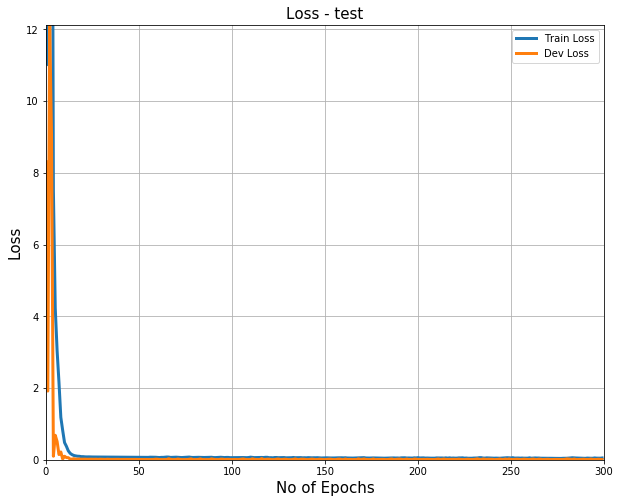

Training Set Score: 0.5225
Dev Set Score: 0.6191
Test Set Score: -25.7010
Training Set MSE: 13492.5283
Dev Set MSE: 2661.4664
Test Set MSE: 8903.3690


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


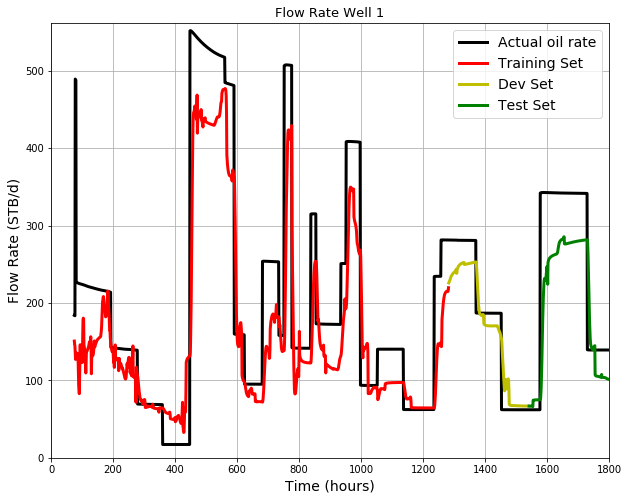

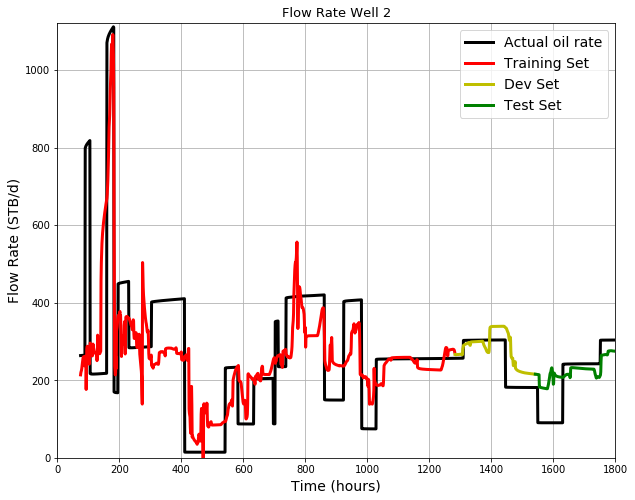

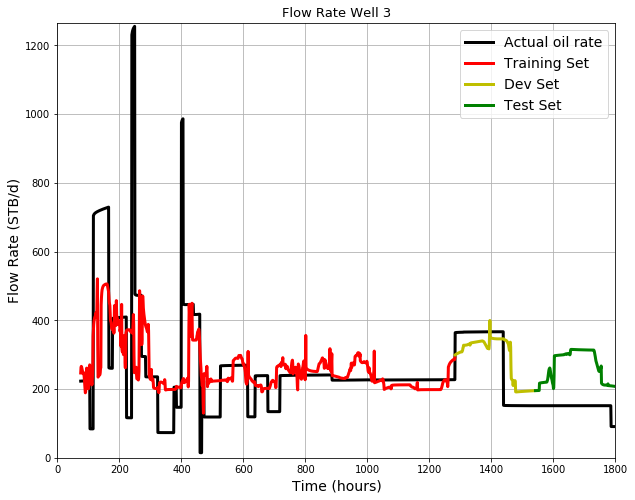

In [14]:
import time
start_time = time.time()
model_RNN, history_RNN = run_model(x_train, y_train, x_dev, y_dev, epochs=300, batch_size=300, method='Simple RNN')
# Measure running time
print("Completed in %s seconds" % (time.time() - start_time))

# Training
y_pred_train_pre = model_RNN.predict(x_train)
y_pred_train_scaled = np.concatenate((y_pred_train_pre[0], y_pred_train_pre[1], y_pred_train_pre[2]), axis=1)
y_pred_train = scaler_y.inverse_transform(y_pred_train_scaled)
y_train_act = scaler_y.inverse_transform(y_train)

# Dev
y_pred_dev_pre = model_RNN.predict(x_dev)
y_pred_dev_scaled = np.concatenate((y_pred_dev_pre[0], y_pred_dev_pre[1], y_pred_dev_pre[2]), axis=1)
y_pred_dev = scaler_y.inverse_transform(y_pred_dev_scaled)
y_dev_act = scaler_y.inverse_transform(y_dev)

# Test
y_pred_test_pre = model_RNN.predict(x_test)
y_pred_test_scaled = np.concatenate((y_pred_test_pre[0], y_pred_test_pre[1], y_pred_test_pre[2]), axis=1)
y_pred_test = scaler_y.inverse_transform(y_pred_test_scaled)
y_test_act = scaler_y.inverse_transform(y_test)

# Train-Dev-Test
y_act = np.concatenate([y_train_act, y_dev_act, y_test_act])
y_pred = np.concatenate([y_pred_train, y_pred_dev, y_pred_test])

plot_loss(history_RNN, title='test')
#plt.savefig('loss_LSTM_512_1024_lb25_well_' + str(i))
train_mse, train_acc = mean_squared_error(y_train_act, y_pred_train), r2_score(y_train_act, y_pred_train)
dev_mse, dev_acc = mean_squared_error(y_dev_act, y_pred_dev), r2_score(y_dev_act, y_pred_dev)
test_mse, test_acc = mean_squared_error(y_test_act, y_pred_test), r2_score(y_test_act, y_pred_test)

print('Training Set Score: %1.4f' % train_acc)
print('Dev Set Score: %1.4f' % dev_acc)
print('Test Set Score: %1.4f' % test_acc)

print('Training Set MSE: %1.4f' % train_mse)
print('Dev Set MSE: %1.4f' % dev_mse)
print('Test Set MSE: %1.4f' % test_mse)

for i in range(y_act.shape[1]):
    plot_pred_rate(t[-len(y_act):].as_matrix(),
                   y_act[:, i], y_pred[:, i], dev_fraction=dev_fraction, test_fraction=test_fraction, well=i+1)
    plt.savefig('traindev_LSTM_512_1024_lb25_well_' + str(i))

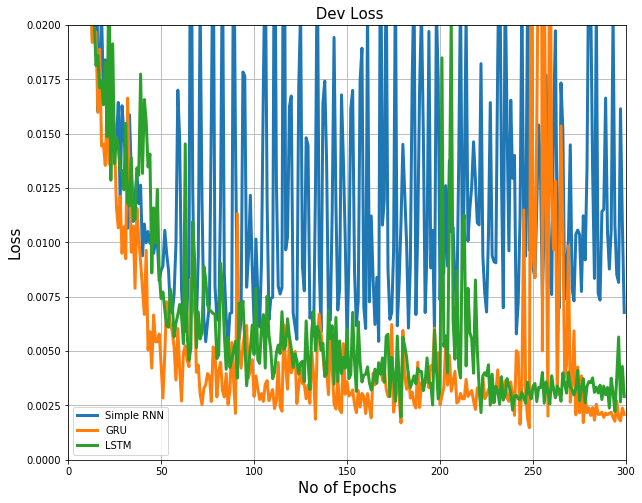

In [15]:
histories = {'Simple RNN': history_RNN,
            'GRU': history_GRU,
            'LSTM': history_LSTM}
plot_loss_comparison(histories)

## BHP Prediction

In [16]:
# Group the input
Y_raw = pd.concat([p['WBHP:P1'], p['WBHP:P2'], p['WBHP:P3']], axis=1, join='inner')
X_raw = pd.concat([qo['WOPR:P1'], qo['WOPR:P2'], qo['WOPR:P3'],
                   qw['WWPR:P1'], qw['WWPR:P2'], qw['WWPR:P3'],
                   wc['WWCT:P1'], wc['WWCT:P2'], wc['WWCT:P3']], axis=1, join='inner')

# Split train-dev and test sets
test_fraction = 0.15
x_traindev_raw, x_test_raw, y_traindev_raw, y_test_raw = train_test_split(X_raw,
                                                  Y_raw,
                                                  test_size=test_fraction,
                                                  shuffle=False)

# Split train and dev sets
dev_fraction = 0.15 # of total dataset
x_train_raw, x_dev_raw, y_train_raw, y_dev_raw = train_test_split(x_traindev_raw,
                                                  y_traindev_raw,
                                                  test_size= dev_fraction/(1-test_fraction),
                                                  shuffle=False)

# Data Scaling
scaler_x = MinMaxScaler()
x_train_norm = scaler_x.fit_transform(x_train_raw.as_matrix())
x_dev_norm = scaler_x.transform(x_dev_raw.as_matrix())
x_test_norm = scaler_x.transform(x_test_raw.as_matrix())

scaler_y = MinMaxScaler()
y_train_norm = scaler_y.fit_transform(y_train_raw.as_matrix())
y_dev_norm = scaler_y.transform(y_dev_raw.as_matrix())
y_test_norm = scaler_y.transform(y_test_raw.as_matrix())

# Create time blocks
x_train, y_train = create_timeblock(x_train_norm, y_train_norm, look_back=25)
x_dev, y_dev = create_timeblock(x_dev_norm, y_dev_norm, look_back=25)
x_test, y_test = create_timeblock(x_test_norm, y_test_norm, look_back=25)

# of data:  1235
# of data:  245
# of data:  246


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:23: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:29: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:30: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [19]:
def run_model(x_train, y_train, x_dev, y_dev, epochs=500, batch_size=400, method='LSTM'):
    classifier = {'GRU' : GRU,
                  'LSTM' : LSTM,
                  'Simple RNN' : SimpleRNN}

    inputs = keras.Input(shape=(x_train.shape[1], x_train.shape[2]))

    X = classifier[method](512, return_sequences=True)(inputs)
    X = classifier[method](1024, return_sequences=True)(X)
    
    X = TimeDistributed(Dense(256, activation='relu'))(X)
    #X = Dropout(0.6)(X)
    
    out1 = Dense(1, activation='linear')(Flatten()(X))
    out2 = Dense(1, activation='linear')(Flatten()(X))
    out3 = Dense(1, activation='linear')(Flatten()(X))
    
    model = keras.Model(inputs=inputs, outputs=[out1, out2, out3])
    
    #parallel_model = multi_gpu_model(model, gpus=8)

    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae','accuracy'])
    history = model.fit(x_train, [y_train[:, 0], y_train[:, 1], y_train[:, 2]], 
                        epochs=epochs, batch_size=batch_size,
                        validation_data=(x_dev, [y_dev[:, 0], y_dev[:, 1], y_dev[:, 2]]), 
                        verbose=1, shuffle=False)
    return model, history

In [20]:
model, history = run_model(x_train, y_train, x_dev, y_dev, epochs=1000, batch_size=200, method='LSTM')

Train on 1235 samples, validate on 245 samples
Epoch 1/1000
1235/1235 [==============================] - 4s 3ms/sample - loss: 0.5715 - dense_17_loss: 0.1439 - dense_18_loss: 0.2257 - dense_19_loss: 0.1453 - dense_17_mae: 0.3176 - dense_17_accuracy: 0.0000e+00 - dense_18_mae: 0.4284 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.3251 - dense_19_accuracy: 8.0972e-04 - val_loss: 0.2052 - val_dense_17_loss: 0.0287 - val_dense_18_loss: 0.0773 - val_dense_19_loss: 0.0572 - val_dense_17_mae: 0.1526 - val_dense_17_accuracy: 0.0000e+00 - val_dense_18_mae: 0.3060 - val_dense_18_accuracy: 0.0000e+00 - val_dense_19_mae: 0.2642 - val_dense_19_accuracy: 0.0000e+00
Epoch 2/1000
1235/1235 [==============================] - 0s 307us/sample - loss: 0.2208 - dense_17_loss: 0.0524 - dense_18_loss: 0.0629 - dense_19_loss: 0.0943 - dense_17_mae: 0.1804 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.1898 - dense_18_accuracy: 0.0000e+00 - dense_19_mae: 0.2701 - dense_19_accuracy: 0.0000e+00 - val_loss:

1235/1235 [==============================] - 0s 307us/sample - loss: 0.0313 - dense_17_loss: 0.0151 - dense_18_loss: 0.0059 - dense_19_loss: 0.0069 - dense_17_mae: 0.0916 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0540 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0508 - dense_19_accuracy: 0.0000e+00 - val_loss: 0.0157 - val_dense_17_loss: 0.0135 - val_dense_18_loss: 7.3897e-04 - val_dense_19_loss: 0.0058 - val_dense_17_mae: 0.0890 - val_dense_17_accuracy: 0.0000e+00 - val_dense_18_mae: 0.0211 - val_dense_18_accuracy: 0.0000e+00 - val_dense_19_mae: 0.0521 - val_dense_19_accuracy: 0.0000e+00
Epoch 15/1000
1235/1235 [==============================] - 0s 313us/sample - loss: 0.0333 - dense_17_loss: 0.0159 - dense_18_loss: 0.0070 - dense_19_loss: 0.0084 - dense_17_mae: 0.1042 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0539 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0665 - dense_19_accuracy: 8.0972e-04 - val_loss: 0.0078 - val_dense_17_loss: 0.0047 - val_dense_18_lo

1235/1235 [==============================] - 0s 314us/sample - loss: 0.0339 - dense_17_loss: 0.0127 - dense_18_loss: 0.0080 - dense_19_loss: 0.0126 - dense_17_mae: 0.0901 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0662 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0799 - dense_19_accuracy: 8.0972e-04 - val_loss: 0.0127 - val_dense_17_loss: 0.0025 - val_dense_18_loss: 0.0016 - val_dense_19_loss: 0.0049 - val_dense_17_mae: 0.0484 - val_dense_17_accuracy: 0.0000e+00 - val_dense_18_mae: 0.0398 - val_dense_18_accuracy: 0.0000e+00 - val_dense_19_mae: 0.0678 - val_dense_19_accuracy: 0.0000e+00
Epoch 28/1000
1235/1235 [==============================] - 0s 302us/sample - loss: 0.0330 - dense_17_loss: 0.0118 - dense_18_loss: 0.0080 - dense_19_loss: 0.0101 - dense_17_mae: 0.0866 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0692 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0786 - dense_19_accuracy: 8.0972e-04 - val_loss: 0.0195 - val_dense_17_loss: 0.0069 - val_dense_18_loss: 

1235/1235 [==============================] - 0s 313us/sample - loss: 0.0152 - dense_17_loss: 0.0048 - dense_18_loss: 0.0046 - dense_19_loss: 0.0041 - dense_17_mae: 0.0394 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0491 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0366 - dense_19_accuracy: 8.0972e-04 - val_loss: 0.0029 - val_dense_17_loss: 5.5225e-04 - val_dense_18_loss: 0.0014 - val_dense_19_loss: 4.0834e-04 - val_dense_17_mae: 0.0172 - val_dense_17_accuracy: 0.0000e+00 - val_dense_18_mae: 0.0323 - val_dense_18_accuracy: 0.0000e+00 - val_dense_19_mae: 0.0187 - val_dense_19_accuracy: 0.0000e+00
Epoch 41/1000
1235/1235 [==============================] - 0s 302us/sample - loss: 0.0173 - dense_17_loss: 0.0061 - dense_18_loss: 0.0064 - dense_19_loss: 0.0042 - dense_17_mae: 0.0489 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0602 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0352 - dense_19_accuracy: 8.0972e-04 - val_loss: 0.0031 - val_dense_17_loss: 7.1993e-04 - val_den

1235/1235 [==============================] - 0s 304us/sample - loss: 0.0148 - dense_17_loss: 0.0061 - dense_18_loss: 0.0034 - dense_19_loss: 0.0040 - dense_17_mae: 0.0516 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0379 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0383 - dense_19_accuracy: 8.0972e-04 - val_loss: 0.0022 - val_dense_17_loss: 5.9312e-04 - val_dense_18_loss: 7.1281e-04 - val_dense_19_loss: 3.8510e-04 - val_dense_17_mae: 0.0239 - val_dense_17_accuracy: 0.0000e+00 - val_dense_18_mae: 0.0229 - val_dense_18_accuracy: 0.0000e+00 - val_dense_19_mae: 0.0184 - val_dense_19_accuracy: 0.0000e+00
Epoch 54/1000
1235/1235 [==============================] - 0s 309us/sample - loss: 0.0150 - dense_17_loss: 0.0066 - dense_18_loss: 0.0032 - dense_19_loss: 0.0037 - dense_17_mae: 0.0641 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0382 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0398 - dense_19_accuracy: 8.0972e-04 - val_loss: 0.0035 - val_dense_17_loss: 0.0013 - val_den

1235/1235 [==============================] - 0s 303us/sample - loss: 0.0290 - dense_17_loss: 0.0126 - dense_18_loss: 0.0067 - dense_19_loss: 0.0082 - dense_17_mae: 0.0943 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0637 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0740 - dense_19_accuracy: 8.0972e-04 - val_loss: 0.0146 - val_dense_17_loss: 0.0073 - val_dense_18_loss: 0.0039 - val_dense_19_loss: 0.0064 - val_dense_17_mae: 0.0738 - val_dense_17_accuracy: 0.0000e+00 - val_dense_18_mae: 0.0549 - val_dense_18_accuracy: 0.0000e+00 - val_dense_19_mae: 0.0616 - val_dense_19_accuracy: 0.0000e+00
Epoch 67/1000
1235/1235 [==============================] - 0s 300us/sample - loss: 0.0256 - dense_17_loss: 0.0108 - dense_18_loss: 0.0046 - dense_19_loss: 0.0074 - dense_17_mae: 0.0889 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0534 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0769 - dense_19_accuracy: 8.0972e-04 - val_loss: 0.0140 - val_dense_17_loss: 0.0103 - val_dense_18_loss: 

1235/1235 [==============================] - 0s 312us/sample - loss: 0.0105 - dense_17_loss: 0.0041 - dense_18_loss: 0.0024 - dense_19_loss: 0.0031 - dense_17_mae: 0.0353 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0293 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0355 - dense_19_accuracy: 8.0972e-04 - val_loss: 0.0017 - val_dense_17_loss: 5.3900e-04 - val_dense_18_loss: 3.4463e-04 - val_dense_19_loss: 3.6241e-04 - val_dense_17_mae: 0.0164 - val_dense_17_accuracy: 0.0000e+00 - val_dense_18_mae: 0.0125 - val_dense_18_accuracy: 0.0000e+00 - val_dense_19_mae: 0.0140 - val_dense_19_accuracy: 0.0000e+00
Epoch 80/1000
1235/1235 [==============================] - 0s 310us/sample - loss: 0.0097 - dense_17_loss: 0.0037 - dense_18_loss: 0.0023 - dense_19_loss: 0.0027 - dense_17_mae: 0.0342 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0294 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0331 - dense_19_accuracy: 8.0972e-04 - val_loss: 0.0016 - val_dense_17_loss: 3.9150e-04 - val

1235/1235 [==============================] - 0s 303us/sample - loss: 0.0082 - dense_17_loss: 0.0033 - dense_18_loss: 0.0022 - dense_19_loss: 0.0021 - dense_17_mae: 0.0341 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0318 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0261 - dense_19_accuracy: 8.0972e-04 - val_loss: 0.0018 - val_dense_17_loss: 7.1837e-04 - val_dense_18_loss: 5.8480e-04 - val_dense_19_loss: 5.9486e-04 - val_dense_17_mae: 0.0180 - val_dense_17_accuracy: 0.0000e+00 - val_dense_18_mae: 0.0181 - val_dense_18_accuracy: 0.0000e+00 - val_dense_19_mae: 0.0181 - val_dense_19_accuracy: 0.0000e+00
Epoch 93/1000
1235/1235 [==============================] - 0s 304us/sample - loss: 0.0088 - dense_17_loss: 0.0035 - dense_18_loss: 0.0021 - dense_19_loss: 0.0023 - dense_17_mae: 0.0386 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0325 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0326 - dense_19_accuracy: 8.0972e-04 - val_loss: 0.0021 - val_dense_17_loss: 7.6385e-04 - val

1235/1235 [==============================] - 0s 297us/sample - loss: 0.0094 - dense_17_loss: 0.0037 - dense_18_loss: 0.0028 - dense_19_loss: 0.0021 - dense_17_mae: 0.0406 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0383 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0274 - dense_19_accuracy: 8.0972e-04 - val_loss: 0.0027 - val_dense_17_loss: 0.0015 - val_dense_18_loss: 8.5281e-04 - val_dense_19_loss: 4.4781e-04 - val_dense_17_mae: 0.0291 - val_dense_17_accuracy: 0.0000e+00 - val_dense_18_mae: 0.0270 - val_dense_18_accuracy: 0.0000e+00 - val_dense_19_mae: 0.0159 - val_dense_19_accuracy: 0.0000e+00
Epoch 106/1000
1235/1235 [==============================] - 0s 305us/sample - loss: 0.0099 - dense_17_loss: 0.0039 - dense_18_loss: 0.0030 - dense_19_loss: 0.0020 - dense_17_mae: 0.0456 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0425 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0281 - dense_19_accuracy: 8.0972e-04 - val_loss: 0.0023 - val_dense_17_loss: 5.5261e-04 - val_de

1235/1235 [==============================] - 0s 308us/sample - loss: 0.0086 - dense_17_loss: 0.0044 - dense_18_loss: 0.0015 - dense_19_loss: 0.0021 - dense_17_mae: 0.0474 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0243 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0285 - dense_19_accuracy: 8.0972e-04 - val_loss: 0.0030 - val_dense_17_loss: 0.0022 - val_dense_18_loss: 2.8132e-04 - val_dense_19_loss: 5.4489e-04 - val_dense_17_mae: 0.0431 - val_dense_17_accuracy: 0.0000e+00 - val_dense_18_mae: 0.0068 - val_dense_18_accuracy: 0.0000e+00 - val_dense_19_mae: 0.0175 - val_dense_19_accuracy: 0.0000e+00
Epoch 119/1000
1235/1235 [==============================] - 0s 305us/sample - loss: 0.0096 - dense_17_loss: 0.0053 - dense_18_loss: 0.0015 - dense_19_loss: 0.0020 - dense_17_mae: 0.0598 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0224 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0306 - dense_19_accuracy: 8.0972e-04 - val_loss: 0.0018 - val_dense_17_loss: 9.5529e-04 - val_de

1235/1235 [==============================] - 0s 302us/sample - loss: 0.0079 - dense_17_loss: 0.0030 - dense_18_loss: 0.0015 - dense_19_loss: 0.0025 - dense_17_mae: 0.0375 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0242 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0385 - dense_19_accuracy: 8.0972e-04 - val_loss: 0.0017 - val_dense_17_loss: 7.2995e-04 - val_dense_18_loss: 4.5848e-04 - val_dense_19_loss: 9.2509e-04 - val_dense_17_mae: 0.0157 - val_dense_17_accuracy: 0.0000e+00 - val_dense_18_mae: 0.0140 - val_dense_18_accuracy: 0.0000e+00 - val_dense_19_mae: 0.0212 - val_dense_19_accuracy: 0.0000e+00
Epoch 132/1000
1235/1235 [==============================] - 0s 303us/sample - loss: 0.0087 - dense_17_loss: 0.0031 - dense_18_loss: 0.0021 - dense_19_loss: 0.0031 - dense_17_mae: 0.0366 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0355 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0387 - dense_19_accuracy: 8.0972e-04 - val_loss: 0.0036 - val_dense_17_loss: 9.2066e-04 - va

1235/1235 [==============================] - 0s 303us/sample - loss: 0.0080 - dense_17_loss: 0.0029 - dense_18_loss: 0.0021 - dense_19_loss: 0.0025 - dense_17_mae: 0.0359 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0364 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0372 - dense_19_accuracy: 8.0972e-04 - val_loss: 0.0022 - val_dense_17_loss: 5.2869e-04 - val_dense_18_loss: 5.1824e-04 - val_dense_19_loss: 7.0972e-04 - val_dense_17_mae: 0.0239 - val_dense_17_accuracy: 0.0000e+00 - val_dense_18_mae: 0.0120 - val_dense_18_accuracy: 0.0000e+00 - val_dense_19_mae: 0.0274 - val_dense_19_accuracy: 0.0000e+00
Epoch 145/1000
1235/1235 [==============================] - 0s 302us/sample - loss: 0.0077 - dense_17_loss: 0.0027 - dense_18_loss: 0.0023 - dense_19_loss: 0.0022 - dense_17_mae: 0.0370 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0333 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0334 - dense_19_accuracy: 8.0972e-04 - val_loss: 0.0050 - val_dense_17_loss: 0.0018 - val_de

1235/1235 [==============================] - 0s 304us/sample - loss: 0.0083 - dense_17_loss: 0.0040 - dense_18_loss: 0.0022 - dense_19_loss: 0.0016 - dense_17_mae: 0.0472 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0328 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0227 - dense_19_accuracy: 8.0972e-04 - val_loss: 0.0049 - val_dense_17_loss: 0.0034 - val_dense_18_loss: 5.4443e-04 - val_dense_19_loss: 3.3741e-04 - val_dense_17_mae: 0.0600 - val_dense_17_accuracy: 0.0000e+00 - val_dense_18_mae: 0.0214 - val_dense_18_accuracy: 0.0000e+00 - val_dense_19_mae: 0.0188 - val_dense_19_accuracy: 0.0000e+00
Epoch 158/1000
1235/1235 [==============================] - 0s 304us/sample - loss: 0.0083 - dense_17_loss: 0.0046 - dense_18_loss: 0.0018 - dense_19_loss: 0.0015 - dense_17_mae: 0.0485 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0320 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0230 - dense_19_accuracy: 8.0972e-04 - val_loss: 0.0017 - val_dense_17_loss: 6.9021e-04 - val_de

1235/1235 [==============================] - 0s 306us/sample - loss: 0.0060 - dense_17_loss: 0.0023 - dense_18_loss: 0.0016 - dense_19_loss: 0.0018 - dense_17_mae: 0.0284 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0259 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0271 - dense_19_accuracy: 8.0972e-04 - val_loss: 9.7344e-04 - val_dense_17_loss: 2.2810e-04 - val_dense_18_loss: 3.0343e-04 - val_dense_19_loss: 2.0777e-04 - val_dense_17_mae: 0.0091 - val_dense_17_accuracy: 0.0000e+00 - val_dense_18_mae: 0.0125 - val_dense_18_accuracy: 0.0000e+00 - val_dense_19_mae: 0.0123 - val_dense_19_accuracy: 0.0000e+00
Epoch 171/1000
1235/1235 [==============================] - 0s 301us/sample - loss: 0.0059 - dense_17_loss: 0.0021 - dense_18_loss: 0.0016 - dense_19_loss: 0.0015 - dense_17_mae: 0.0272 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0309 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0254 - dense_19_accuracy: 8.0972e-04 - val_loss: 0.0014 - val_dense_17_loss: 5.2384e-04 

1235/1235 [==============================] - 0s 305us/sample - loss: 0.0080 - dense_17_loss: 0.0030 - dense_18_loss: 0.0018 - dense_19_loss: 0.0030 - dense_17_mae: 0.0373 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0306 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0387 - dense_19_accuracy: 8.0972e-04 - val_loss: 0.0052 - val_dense_17_loss: 0.0015 - val_dense_18_loss: 4.3990e-04 - val_dense_19_loss: 0.0017 - val_dense_17_mae: 0.0430 - val_dense_17_accuracy: 0.0000e+00 - val_dense_18_mae: 0.0198 - val_dense_18_accuracy: 0.0000e+00 - val_dense_19_mae: 0.0443 - val_dense_19_accuracy: 0.0000e+00
Epoch 184/1000
1235/1235 [==============================] - 0s 305us/sample - loss: 0.0087 - dense_17_loss: 0.0035 - dense_18_loss: 0.0017 - dense_19_loss: 0.0025 - dense_17_mae: 0.0472 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0284 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0404 - dense_19_accuracy: 8.0972e-04 - val_loss: 0.0039 - val_dense_17_loss: 0.0012 - val_dense_18_l

1235/1235 [==============================] - 0s 325us/sample - loss: 0.0197 - dense_17_loss: 0.0049 - dense_18_loss: 0.0064 - dense_19_loss: 0.0063 - dense_17_mae: 0.0545 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0687 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0728 - dense_19_accuracy: 8.0972e-04 - val_loss: 0.0124 - val_dense_17_loss: 0.0104 - val_dense_18_loss: 0.0019 - val_dense_19_loss: 0.0035 - val_dense_17_mae: 0.0764 - val_dense_17_accuracy: 0.0000e+00 - val_dense_18_mae: 0.0273 - val_dense_18_accuracy: 0.0000e+00 - val_dense_19_mae: 0.0530 - val_dense_19_accuracy: 0.0000e+00
Epoch 197/1000
1235/1235 [==============================] - 0s 318us/sample - loss: 0.0323 - dense_17_loss: 0.0098 - dense_18_loss: 0.0096 - dense_19_loss: 0.0106 - dense_17_mae: 0.0856 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0716 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0815 - dense_19_accuracy: 8.0972e-04 - val_loss: 0.0076 - val_dense_17_loss: 0.0020 - val_dense_18_loss:

1235/1235 [==============================] - 0s 308us/sample - loss: 0.0077 - dense_17_loss: 0.0025 - dense_18_loss: 0.0018 - dense_19_loss: 0.0028 - dense_17_mae: 0.0314 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0289 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0357 - dense_19_accuracy: 8.0972e-04 - val_loss: 0.0014 - val_dense_17_loss: 2.5197e-04 - val_dense_18_loss: 2.8997e-04 - val_dense_19_loss: 4.4300e-04 - val_dense_17_mae: 0.0114 - val_dense_17_accuracy: 0.0000e+00 - val_dense_18_mae: 0.0102 - val_dense_18_accuracy: 0.0000e+00 - val_dense_19_mae: 0.0195 - val_dense_19_accuracy: 0.0000e+00
Epoch 210/1000
1235/1235 [==============================] - 0s 308us/sample - loss: 0.0078 - dense_17_loss: 0.0020 - dense_18_loss: 0.0022 - dense_19_loss: 0.0029 - dense_17_mae: 0.0249 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0385 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0418 - dense_19_accuracy: 8.0972e-04 - val_loss: 0.0020 - val_dense_17_loss: 2.0048e-04 - va

Epoch 222/1000
1235/1235 [==============================] - 0s 305us/sample - loss: 0.0040 - dense_17_loss: 0.0015 - dense_18_loss: 0.0010 - dense_19_loss: 0.0010 - dense_17_mae: 0.0166 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0178 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0156 - dense_19_accuracy: 8.0972e-04 - val_loss: 0.0013 - val_dense_17_loss: 3.8439e-04 - val_dense_18_loss: 3.0938e-04 - val_dense_19_loss: 3.3657e-04 - val_dense_17_mae: 0.0169 - val_dense_17_accuracy: 0.0000e+00 - val_dense_18_mae: 0.0168 - val_dense_18_accuracy: 0.0000e+00 - val_dense_19_mae: 0.0188 - val_dense_19_accuracy: 0.0000e+00
Epoch 223/1000
1235/1235 [==============================] - 0s 303us/sample - loss: 0.0039 - dense_17_loss: 0.0015 - dense_18_loss: 9.9411e-04 - dense_19_loss: 9.9439e-04 - dense_17_mae: 0.0160 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0173 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0162 - dense_19_accuracy: 8.0972e-04 - val_loss: 7.2954e-04 - val_den

Epoch 235/1000
1235/1235 [==============================] - 0s 310us/sample - loss: 0.0045 - dense_17_loss: 0.0018 - dense_18_loss: 0.0012 - dense_19_loss: 0.0012 - dense_17_mae: 0.0221 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0212 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0204 - dense_19_accuracy: 8.0972e-04 - val_loss: 8.0653e-04 - val_dense_17_loss: 2.2701e-04 - val_dense_18_loss: 2.6675e-04 - val_dense_19_loss: 1.4622e-04 - val_dense_17_mae: 0.0098 - val_dense_17_accuracy: 0.0000e+00 - val_dense_18_mae: 0.0101 - val_dense_18_accuracy: 0.0000e+00 - val_dense_19_mae: 0.0098 - val_dense_19_accuracy: 0.0000e+00
Epoch 236/1000
1235/1235 [==============================] - 0s 323us/sample - loss: 0.0053 - dense_17_loss: 0.0018 - dense_18_loss: 0.0016 - dense_19_loss: 0.0014 - dense_17_mae: 0.0241 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0295 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0262 - dense_19_accuracy: 8.0972e-04 - val_loss: 0.0014 - val_dense_17_lo

Epoch 248/1000
1235/1235 [==============================] - 0s 306us/sample - loss: 0.0044 - dense_17_loss: 0.0017 - dense_18_loss: 9.4147e-04 - dense_19_loss: 0.0013 - dense_17_mae: 0.0243 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0162 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0234 - dense_19_accuracy: 8.0972e-04 - val_loss: 6.8246e-04 - val_dense_17_loss: 2.7456e-04 - val_dense_18_loss: 1.7020e-04 - val_dense_19_loss: 1.5886e-04 - val_dense_17_mae: 0.0118 - val_dense_17_accuracy: 0.0000e+00 - val_dense_18_mae: 0.0075 - val_dense_18_accuracy: 0.0000e+00 - val_dense_19_mae: 0.0098 - val_dense_19_accuracy: 0.0000e+00
Epoch 249/1000
1235/1235 [==============================] - 0s 303us/sample - loss: 0.0047 - dense_17_loss: 0.0018 - dense_18_loss: 0.0011 - dense_19_loss: 0.0014 - dense_17_mae: 0.0239 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0204 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0257 - dense_19_accuracy: 8.0972e-04 - val_loss: 8.6402e-04 - val_den

Epoch 261/1000
1235/1235 [==============================] - 0s 303us/sample - loss: 0.0047 - dense_17_loss: 0.0017 - dense_18_loss: 0.0013 - dense_19_loss: 0.0012 - dense_17_mae: 0.0245 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0246 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0225 - dense_19_accuracy: 8.0972e-04 - val_loss: 0.0021 - val_dense_17_loss: 6.6787e-04 - val_dense_18_loss: 5.0956e-04 - val_dense_19_loss: 4.1165e-04 - val_dense_17_mae: 0.0274 - val_dense_17_accuracy: 0.0000e+00 - val_dense_18_mae: 0.0234 - val_dense_18_accuracy: 0.0000e+00 - val_dense_19_mae: 0.0217 - val_dense_19_accuracy: 0.0000e+00
Epoch 262/1000
1235/1235 [==============================] - 0s 302us/sample - loss: 0.0040 - dense_17_loss: 0.0016 - dense_18_loss: 0.0010 - dense_19_loss: 0.0010 - dense_17_mae: 0.0213 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0190 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0173 - dense_19_accuracy: 8.0972e-04 - val_loss: 6.6805e-04 - val_dense_17_lo

Epoch 274/1000
1235/1235 [==============================] - 0s 304us/sample - loss: 0.0045 - dense_17_loss: 0.0017 - dense_18_loss: 0.0014 - dense_19_loss: 0.0011 - dense_17_mae: 0.0216 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0269 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0209 - dense_19_accuracy: 8.0972e-04 - val_loss: 0.0019 - val_dense_17_loss: 3.2156e-04 - val_dense_18_loss: 7.4582e-04 - val_dense_19_loss: 2.1040e-04 - val_dense_17_mae: 0.0172 - val_dense_17_accuracy: 0.0000e+00 - val_dense_18_mae: 0.0269 - val_dense_18_accuracy: 0.0000e+00 - val_dense_19_mae: 0.0136 - val_dense_19_accuracy: 0.0000e+00
Epoch 275/1000
1235/1235 [==============================] - 0s 299us/sample - loss: 0.0044 - dense_17_loss: 0.0015 - dense_18_loss: 0.0013 - dense_19_loss: 0.0011 - dense_17_mae: 0.0206 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0257 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0192 - dense_19_accuracy: 8.0972e-04 - val_loss: 0.0020 - val_dense_17_loss: 

Epoch 287/1000
1235/1235 [==============================] - 0s 305us/sample - loss: 0.0045 - dense_17_loss: 0.0017 - dense_18_loss: 0.0013 - dense_19_loss: 0.0011 - dense_17_mae: 0.0222 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0246 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0209 - dense_19_accuracy: 8.0972e-04 - val_loss: 6.7157e-04 - val_dense_17_loss: 3.0763e-04 - val_dense_18_loss: 1.5976e-04 - val_dense_19_loss: 1.0686e-04 - val_dense_17_mae: 0.0133 - val_dense_17_accuracy: 0.0000e+00 - val_dense_18_mae: 0.0059 - val_dense_18_accuracy: 0.0000e+00 - val_dense_19_mae: 0.0080 - val_dense_19_accuracy: 0.0000e+00
Epoch 288/1000
1235/1235 [==============================] - 0s 299us/sample - loss: 0.0046 - dense_17_loss: 0.0018 - dense_18_loss: 0.0013 - dense_19_loss: 0.0010 - dense_17_mae: 0.0248 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0261 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0179 - dense_19_accuracy: 8.0972e-04 - val_loss: 9.6647e-04 - val_dense_1

Epoch 300/1000
1235/1235 [==============================] - 0s 303us/sample - loss: 0.0064 - dense_17_loss: 0.0031 - dense_18_loss: 0.0010 - dense_19_loss: 0.0020 - dense_17_mae: 0.0406 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0203 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0356 - dense_19_accuracy: 8.0972e-04 - val_loss: 0.0034 - val_dense_17_loss: 8.5748e-04 - val_dense_18_loss: 4.1386e-04 - val_dense_19_loss: 0.0010 - val_dense_17_mae: 0.0302 - val_dense_17_accuracy: 0.0000e+00 - val_dense_18_mae: 0.0176 - val_dense_18_accuracy: 0.0000e+00 - val_dense_19_mae: 0.0354 - val_dense_19_accuracy: 0.0000e+00
Epoch 301/1000
1235/1235 [==============================] - 0s 309us/sample - loss: 0.0062 - dense_17_loss: 0.0026 - dense_18_loss: 9.0233e-04 - dense_19_loss: 0.0020 - dense_17_mae: 0.0408 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0163 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0346 - dense_19_accuracy: 8.0972e-04 - val_loss: 0.0026 - val_dense_17_loss: 

1235/1235 [==============================] - 0s 311us/sample - loss: 0.0046 - dense_17_loss: 0.0015 - dense_18_loss: 0.0014 - dense_19_loss: 0.0014 - dense_17_mae: 0.0185 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0255 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0242 - dense_19_accuracy: 8.0972e-04 - val_loss: 8.9463e-04 - val_dense_17_loss: 2.4217e-04 - val_dense_18_loss: 3.8414e-04 - val_dense_19_loss: 1.2207e-04 - val_dense_17_mae: 0.0118 - val_dense_17_accuracy: 0.0000e+00 - val_dense_18_mae: 0.0156 - val_dense_18_accuracy: 0.0000e+00 - val_dense_19_mae: 0.0082 - val_dense_19_accuracy: 0.0000e+00
Epoch 314/1000
1235/1235 [==============================] - 0s 309us/sample - loss: 0.0050 - dense_17_loss: 0.0016 - dense_18_loss: 0.0016 - dense_19_loss: 0.0014 - dense_17_mae: 0.0192 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0299 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0274 - dense_19_accuracy: 8.0972e-04 - val_loss: 0.0011 - val_dense_17_loss: 1.8611e-04 

Epoch 326/1000
1235/1235 [==============================] - 0s 316us/sample - loss: 0.0035 - dense_17_loss: 0.0015 - dense_18_loss: 6.8806e-04 - dense_19_loss: 9.6568e-04 - dense_17_mae: 0.0186 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0125 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0170 - dense_19_accuracy: 8.0972e-04 - val_loss: 9.3588e-04 - val_dense_17_loss: 3.7401e-04 - val_dense_18_loss: 2.1700e-04 - val_dense_19_loss: 9.7138e-05 - val_dense_17_mae: 0.0197 - val_dense_17_accuracy: 0.0000e+00 - val_dense_18_mae: 0.0115 - val_dense_18_accuracy: 0.0000e+00 - val_dense_19_mae: 0.0068 - val_dense_19_accuracy: 0.0000e+00
Epoch 327/1000
1235/1235 [==============================] - 0s 323us/sample - loss: 0.0033 - dense_17_loss: 0.0014 - dense_18_loss: 6.7663e-04 - dense_19_loss: 9.1473e-04 - dense_17_mae: 0.0180 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0122 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0170 - dense_19_accuracy: 8.0972e-04 - val_loss: 0.0010 -

Epoch 339/1000
1235/1235 [==============================] - 0s 305us/sample - loss: 0.0039 - dense_17_loss: 0.0016 - dense_18_loss: 0.0012 - dense_19_loss: 8.6279e-04 - dense_17_mae: 0.0209 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0245 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0162 - dense_19_accuracy: 8.0972e-04 - val_loss: 0.0015 - val_dense_17_loss: 3.5165e-04 - val_dense_18_loss: 6.7434e-04 - val_dense_19_loss: 3.1575e-04 - val_dense_17_mae: 0.0146 - val_dense_17_accuracy: 0.0000e+00 - val_dense_18_mae: 0.0244 - val_dense_18_accuracy: 0.0000e+00 - val_dense_19_mae: 0.0131 - val_dense_19_accuracy: 0.0000e+00
Epoch 340/1000
1235/1235 [==============================] - 0s 303us/sample - loss: 0.0043 - dense_17_loss: 0.0018 - dense_18_loss: 0.0011 - dense_19_loss: 0.0011 - dense_17_mae: 0.0238 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0236 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0208 - dense_19_accuracy: 8.0972e-04 - val_loss: 0.0024 - val_dense_17_lo

Epoch 352/1000
1235/1235 [==============================] - 0s 302us/sample - loss: 0.0099 - dense_17_loss: 0.0047 - dense_18_loss: 0.0024 - dense_19_loss: 0.0017 - dense_17_mae: 0.0554 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0412 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0306 - dense_19_accuracy: 8.0972e-04 - val_loss: 0.0089 - val_dense_17_loss: 0.0053 - val_dense_18_loss: 0.0016 - val_dense_19_loss: 0.0022 - val_dense_17_mae: 0.0715 - val_dense_17_accuracy: 0.0000e+00 - val_dense_18_mae: 0.0398 - val_dense_18_accuracy: 0.0000e+00 - val_dense_19_mae: 0.0371 - val_dense_19_accuracy: 0.0000e+00
Epoch 353/1000
1235/1235 [==============================] - 0s 328us/sample - loss: 0.0107 - dense_17_loss: 0.0050 - dense_18_loss: 0.0023 - dense_19_loss: 0.0028 - dense_17_mae: 0.0593 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0364 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0395 - dense_19_accuracy: 8.0972e-04 - val_loss: 0.0025 - val_dense_17_loss: 4.6062e-04 -

1235/1235 [==============================] - 0s 296us/sample - loss: 0.0109 - dense_17_loss: 0.0026 - dense_18_loss: 0.0027 - dense_19_loss: 0.0050 - dense_17_mae: 0.0287 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0382 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0560 - dense_19_accuracy: 8.0972e-04 - val_loss: 0.0026 - val_dense_17_loss: 2.9649e-04 - val_dense_18_loss: 0.0015 - val_dense_19_loss: 7.7867e-04 - val_dense_17_mae: 0.0140 - val_dense_17_accuracy: 0.0000e+00 - val_dense_18_mae: 0.0250 - val_dense_18_accuracy: 0.0000e+00 - val_dense_19_mae: 0.0283 - val_dense_19_accuracy: 0.0000e+00
Epoch 366/1000
1235/1235 [==============================] - 0s 300us/sample - loss: 0.0093 - dense_17_loss: 0.0034 - dense_18_loss: 0.0023 - dense_19_loss: 0.0028 - dense_17_mae: 0.0443 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0367 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0434 - dense_19_accuracy: 8.0972e-04 - val_loss: 0.0051 - val_dense_17_loss: 0.0023 - val_dense_

1235/1235 [==============================] - 0s 304us/sample - loss: 0.0043 - dense_17_loss: 0.0019 - dense_18_loss: 9.0864e-04 - dense_19_loss: 0.0011 - dense_17_mae: 0.0284 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0188 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0189 - dense_19_accuracy: 8.0972e-04 - val_loss: 0.0013 - val_dense_17_loss: 0.0011 - val_dense_18_loss: 2.0595e-04 - val_dense_19_loss: 1.3113e-04 - val_dense_17_mae: 0.0246 - val_dense_17_accuracy: 0.0000e+00 - val_dense_18_mae: 0.0072 - val_dense_18_accuracy: 0.0000e+00 - val_dense_19_mae: 0.0089 - val_dense_19_accuracy: 0.0000e+00
Epoch 379/1000
1235/1235 [==============================] - 0s 303us/sample - loss: 0.0050 - dense_17_loss: 0.0024 - dense_18_loss: 0.0011 - dense_19_loss: 0.0011 - dense_17_mae: 0.0326 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0222 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0205 - dense_19_accuracy: 8.0972e-04 - val_loss: 0.0016 - val_dense_17_loss: 5.7100e-04 - va

Epoch 391/1000
1235/1235 [==============================] - 0s 308us/sample - loss: 0.0042 - dense_17_loss: 0.0017 - dense_18_loss: 0.0011 - dense_19_loss: 0.0011 - dense_17_mae: 0.0230 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0228 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0205 - dense_19_accuracy: 8.0972e-04 - val_loss: 0.0030 - val_dense_17_loss: 9.5281e-04 - val_dense_18_loss: 6.5339e-04 - val_dense_19_loss: 5.6669e-04 - val_dense_17_mae: 0.0330 - val_dense_17_accuracy: 0.0000e+00 - val_dense_18_mae: 0.0268 - val_dense_18_accuracy: 0.0000e+00 - val_dense_19_mae: 0.0260 - val_dense_19_accuracy: 0.0000e+00
Epoch 392/1000
1235/1235 [==============================] - 0s 311us/sample - loss: 0.0041 - dense_17_loss: 0.0016 - dense_18_loss: 0.0010 - dense_19_loss: 0.0010 - dense_17_mae: 0.0233 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0198 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0191 - dense_19_accuracy: 8.0972e-04 - val_loss: 9.6338e-04 - val_dense_17_lo

Epoch 404/1000
1235/1235 [==============================] - 0s 307us/sample - loss: 0.0037 - dense_17_loss: 0.0016 - dense_18_loss: 6.9755e-04 - dense_19_loss: 9.6595e-04 - dense_17_mae: 0.0219 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0149 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0193 - dense_19_accuracy: 8.0972e-04 - val_loss: 7.7466e-04 - val_dense_17_loss: 2.6672e-04 - val_dense_18_loss: 2.3893e-04 - val_dense_19_loss: 1.3491e-04 - val_dense_17_mae: 0.0150 - val_dense_17_accuracy: 0.0000e+00 - val_dense_18_mae: 0.0091 - val_dense_18_accuracy: 0.0000e+00 - val_dense_19_mae: 0.0103 - val_dense_19_accuracy: 0.0000e+00
Epoch 405/1000
1235/1235 [==============================] - 0s 307us/sample - loss: 0.0035 - dense_17_loss: 0.0015 - dense_18_loss: 7.3771e-04 - dense_19_loss: 9.9766e-04 - dense_17_mae: 0.0190 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0153 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0179 - dense_19_accuracy: 8.0972e-04 - val_loss: 0.0024 -

Epoch 417/1000
1235/1235 [==============================] - 0s 325us/sample - loss: 0.0040 - dense_17_loss: 0.0019 - dense_18_loss: 7.9091e-04 - dense_19_loss: 0.0010 - dense_17_mae: 0.0264 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0166 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0188 - dense_19_accuracy: 8.0972e-04 - val_loss: 7.2062e-04 - val_dense_17_loss: 2.5436e-04 - val_dense_18_loss: 1.7613e-04 - val_dense_19_loss: 1.6196e-04 - val_dense_17_mae: 0.0122 - val_dense_17_accuracy: 0.0000e+00 - val_dense_18_mae: 0.0069 - val_dense_18_accuracy: 0.0000e+00 - val_dense_19_mae: 0.0085 - val_dense_19_accuracy: 0.0000e+00
Epoch 418/1000
1235/1235 [==============================] - 0s 305us/sample - loss: 0.0047 - dense_17_loss: 0.0021 - dense_18_loss: 9.5775e-04 - dense_19_loss: 0.0011 - dense_17_mae: 0.0309 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0215 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0231 - dense_19_accuracy: 8.0972e-04 - val_loss: 9.0149e-04 - val

Epoch 430/1000
1235/1235 [==============================] - 0s 306us/sample - loss: 0.0043 - dense_17_loss: 0.0018 - dense_18_loss: 9.1856e-04 - dense_19_loss: 0.0011 - dense_17_mae: 0.0273 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0200 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0223 - dense_19_accuracy: 8.0972e-04 - val_loss: 0.0022 - val_dense_17_loss: 8.9284e-04 - val_dense_18_loss: 4.7068e-04 - val_dense_19_loss: 2.8671e-04 - val_dense_17_mae: 0.0326 - val_dense_17_accuracy: 0.0000e+00 - val_dense_18_mae: 0.0228 - val_dense_18_accuracy: 0.0000e+00 - val_dense_19_mae: 0.0180 - val_dense_19_accuracy: 0.0000e+00
Epoch 431/1000
1235/1235 [==============================] - 0s 307us/sample - loss: 0.0037 - dense_17_loss: 0.0017 - dense_18_loss: 8.0587e-04 - dense_19_loss: 9.6995e-04 - dense_17_mae: 0.0220 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0170 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0181 - dense_19_accuracy: 8.0972e-04 - val_loss: 6.7695e-04 - val

Epoch 443/1000
1235/1235 [==============================] - 0s 301us/sample - loss: 0.0043 - dense_17_loss: 0.0015 - dense_18_loss: 0.0011 - dense_19_loss: 0.0013 - dense_17_mae: 0.0209 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0236 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0279 - dense_19_accuracy: 8.0972e-04 - val_loss: 0.0022 - val_dense_17_loss: 3.8719e-04 - val_dense_18_loss: 6.8387e-04 - val_dense_19_loss: 3.6437e-04 - val_dense_17_mae: 0.0203 - val_dense_17_accuracy: 0.0000e+00 - val_dense_18_mae: 0.0275 - val_dense_18_accuracy: 0.0000e+00 - val_dense_19_mae: 0.0195 - val_dense_19_accuracy: 0.0000e+00
Epoch 444/1000
1235/1235 [==============================] - 0s 306us/sample - loss: 0.0042 - dense_17_loss: 0.0015 - dense_18_loss: 9.9871e-04 - dense_19_loss: 0.0013 - dense_17_mae: 0.0207 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0216 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0263 - dense_19_accuracy: 8.0972e-04 - val_loss: 0.0022 - val_dense_17_lo

Epoch 456/1000
1235/1235 [==============================] - 0s 306us/sample - loss: 0.0037 - dense_17_loss: 0.0019 - dense_18_loss: 6.8422e-04 - dense_19_loss: 8.2772e-04 - dense_17_mae: 0.0256 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0151 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0158 - dense_19_accuracy: 8.0972e-04 - val_loss: 7.4420e-04 - val_dense_17_loss: 2.7083e-04 - val_dense_18_loss: 2.3058e-04 - val_dense_19_loss: 1.1014e-04 - val_dense_17_mae: 0.0131 - val_dense_17_accuracy: 0.0000e+00 - val_dense_18_mae: 0.0078 - val_dense_18_accuracy: 0.0000e+00 - val_dense_19_mae: 0.0079 - val_dense_19_accuracy: 0.0000e+00
Epoch 457/1000
1235/1235 [==============================] - 0s 304us/sample - loss: 0.0044 - dense_17_loss: 0.0021 - dense_18_loss: 0.0010 - dense_19_loss: 7.9478e-04 - dense_17_mae: 0.0312 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0222 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0142 - dense_19_accuracy: 8.0972e-04 - val_loss: 9.5044e-04 -

Epoch 469/1000
1235/1235 [==============================] - 0s 306us/sample - loss: 0.0049 - dense_17_loss: 0.0017 - dense_18_loss: 9.5436e-04 - dense_19_loss: 0.0020 - dense_17_mae: 0.0234 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0200 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0339 - dense_19_accuracy: 8.0972e-04 - val_loss: 0.0044 - val_dense_17_loss: 8.1885e-04 - val_dense_18_loss: 7.1390e-04 - val_dense_19_loss: 0.0015 - val_dense_17_mae: 0.0318 - val_dense_17_accuracy: 0.0000e+00 - val_dense_18_mae: 0.0292 - val_dense_18_accuracy: 0.0000e+00 - val_dense_19_mae: 0.0428 - val_dense_19_accuracy: 0.0000e+00
Epoch 470/1000
1235/1235 [==============================] - 0s 307us/sample - loss: 0.0053 - dense_17_loss: 0.0019 - dense_18_loss: 0.0011 - dense_19_loss: 0.0019 - dense_17_mae: 0.0294 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0237 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0330 - dense_19_accuracy: 8.0972e-04 - val_loss: 0.0014 - val_dense_17_loss: 

1235/1235 [==============================] - 0s 305us/sample - loss: 0.0061 - dense_17_loss: 0.0021 - dense_18_loss: 0.0022 - dense_19_loss: 0.0012 - dense_17_mae: 0.0292 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0388 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0228 - dense_19_accuracy: 8.0972e-04 - val_loss: 0.0015 - val_dense_17_loss: 3.0429e-04 - val_dense_18_loss: 7.2927e-04 - val_dense_19_loss: 8.0974e-04 - val_dense_17_mae: 0.0145 - val_dense_17_accuracy: 0.0000e+00 - val_dense_18_mae: 0.0156 - val_dense_18_accuracy: 0.0000e+00 - val_dense_19_mae: 0.0225 - val_dense_19_accuracy: 0.0000e+00
Epoch 483/1000
1235/1235 [==============================] - 0s 315us/sample - loss: 0.0072 - dense_17_loss: 0.0025 - dense_18_loss: 0.0024 - dense_19_loss: 0.0018 - dense_17_mae: 0.0369 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0368 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0339 - dense_19_accuracy: 8.0972e-04 - val_loss: 0.0033 - val_dense_17_loss: 5.7905e-04 - va

Epoch 495/1000
1235/1235 [==============================] - 0s 301us/sample - loss: 0.0032 - dense_17_loss: 0.0015 - dense_18_loss: 6.6347e-04 - dense_19_loss: 7.0688e-04 - dense_17_mae: 0.0227 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0145 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0126 - dense_19_accuracy: 8.0972e-04 - val_loss: 0.0014 - val_dense_17_loss: 4.9458e-04 - val_dense_18_loss: 3.3701e-04 - val_dense_19_loss: 2.2288e-04 - val_dense_17_mae: 0.0226 - val_dense_17_accuracy: 0.0000e+00 - val_dense_18_mae: 0.0181 - val_dense_18_accuracy: 0.0000e+00 - val_dense_19_mae: 0.0157 - val_dense_19_accuracy: 0.0000e+00
Epoch 496/1000
1235/1235 [==============================] - 0s 305us/sample - loss: 0.0030 - dense_17_loss: 0.0013 - dense_18_loss: 6.4751e-04 - dense_19_loss: 7.0152e-04 - dense_17_mae: 0.0152 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0141 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0123 - dense_19_accuracy: 8.0972e-04 - val_loss: 9.2230e-04 -

Epoch 508/1000
1235/1235 [==============================] - 0s 304us/sample - loss: 0.0031 - dense_17_loss: 0.0014 - dense_18_loss: 6.0470e-04 - dense_19_loss: 8.6415e-04 - dense_17_mae: 0.0182 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0122 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0166 - dense_19_accuracy: 8.0972e-04 - val_loss: 5.3661e-04 - val_dense_17_loss: 1.9559e-04 - val_dense_18_loss: 1.2737e-04 - val_dense_19_loss: 8.9338e-05 - val_dense_17_mae: 0.0097 - val_dense_17_accuracy: 0.0000e+00 - val_dense_18_mae: 0.0074 - val_dense_18_accuracy: 0.0000e+00 - val_dense_19_mae: 0.0071 - val_dense_19_accuracy: 0.0000e+00
Epoch 509/1000
1235/1235 [==============================] - 0s 299us/sample - loss: 0.0034 - dense_17_loss: 0.0014 - dense_18_loss: 6.7361e-04 - dense_19_loss: 9.3880e-04 - dense_17_mae: 0.0197 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0159 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0199 - dense_19_accuracy: 8.0972e-04 - val_loss: 7.7024e-

Epoch 521/1000
1235/1235 [==============================] - 0s 306us/sample - loss: 0.0051 - dense_17_loss: 0.0019 - dense_18_loss: 0.0019 - dense_19_loss: 0.0012 - dense_17_mae: 0.0256 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0349 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0219 - dense_19_accuracy: 8.0972e-04 - val_loss: 0.0046 - val_dense_17_loss: 0.0013 - val_dense_18_loss: 0.0011 - val_dense_19_loss: 6.9686e-04 - val_dense_17_mae: 0.0409 - val_dense_17_accuracy: 0.0000e+00 - val_dense_18_mae: 0.0341 - val_dense_18_accuracy: 0.0000e+00 - val_dense_19_mae: 0.0292 - val_dense_19_accuracy: 0.0000e+00
Epoch 522/1000
1235/1235 [==============================] - 0s 306us/sample - loss: 0.0055 - dense_17_loss: 0.0020 - dense_18_loss: 0.0020 - dense_19_loss: 9.7643e-04 - dense_17_mae: 0.0309 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0361 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0210 - dense_19_accuracy: 8.0972e-04 - val_loss: 0.0019 - val_dense_17_loss: 4.67

Epoch 534/1000
1235/1235 [==============================] - 0s 304us/sample - loss: 0.0061 - dense_17_loss: 0.0026 - dense_18_loss: 9.9757e-04 - dense_19_loss: 0.0021 - dense_17_mae: 0.0328 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0215 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0370 - dense_19_accuracy: 8.0972e-04 - val_loss: 0.0021 - val_dense_17_loss: 5.5058e-04 - val_dense_18_loss: 7.9492e-04 - val_dense_19_loss: 0.0017 - val_dense_17_mae: 0.0192 - val_dense_17_accuracy: 0.0000e+00 - val_dense_18_mae: 0.0139 - val_dense_18_accuracy: 0.0000e+00 - val_dense_19_mae: 0.0249 - val_dense_19_accuracy: 0.0000e+00
Epoch 535/1000
1235/1235 [==============================] - 0s 302us/sample - loss: 0.0069 - dense_17_loss: 0.0029 - dense_18_loss: 0.0012 - dense_19_loss: 0.0023 - dense_17_mae: 0.0410 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0265 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0396 - dense_19_accuracy: 8.0972e-04 - val_loss: 0.0027 - val_dense_17_loss: 

1235/1235 [==============================] - 0s 332us/sample - loss: 0.0150 - dense_17_loss: 0.0058 - dense_18_loss: 0.0028 - dense_19_loss: 0.0054 - dense_17_mae: 0.0630 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0374 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0624 - dense_19_accuracy: 8.0972e-04 - val_loss: 0.0083 - val_dense_17_loss: 0.0071 - val_dense_18_loss: 5.6385e-04 - val_dense_19_loss: 0.0043 - val_dense_17_mae: 0.0522 - val_dense_17_accuracy: 0.0000e+00 - val_dense_18_mae: 0.0185 - val_dense_18_accuracy: 0.0000e+00 - val_dense_19_mae: 0.0486 - val_dense_19_accuracy: 0.0000e+00
Epoch 548/1000
1235/1235 [==============================] - 0s 310us/sample - loss: 0.0220 - dense_17_loss: 0.0074 - dense_18_loss: 0.0048 - dense_19_loss: 0.0085 - dense_17_mae: 0.0687 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0541 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0725 - dense_19_accuracy: 8.0972e-04 - val_loss: 0.0098 - val_dense_17_loss: 4.0675e-04 - val_dense_

1235/1235 [==============================] - 0s 309us/sample - loss: 0.0138 - dense_17_loss: 0.0039 - dense_18_loss: 0.0032 - dense_19_loss: 0.0055 - dense_17_mae: 0.0471 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0416 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0604 - dense_19_accuracy: 8.0972e-04 - val_loss: 0.0046 - val_dense_17_loss: 0.0036 - val_dense_18_loss: 5.1512e-04 - val_dense_19_loss: 8.3150e-04 - val_dense_17_mae: 0.0438 - val_dense_17_accuracy: 0.0000e+00 - val_dense_18_mae: 0.0193 - val_dense_18_accuracy: 0.0000e+00 - val_dense_19_mae: 0.0302 - val_dense_19_accuracy: 0.0000e+00
Epoch 561/1000
1235/1235 [==============================] - 0s 309us/sample - loss: 0.0151 - dense_17_loss: 0.0070 - dense_18_loss: 0.0030 - dense_19_loss: 0.0042 - dense_17_mae: 0.0732 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0388 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0465 - dense_19_accuracy: 8.0972e-04 - val_loss: 0.0023 - val_dense_17_loss: 0.0019 - val_dense_

1235/1235 [==============================] - 0s 324us/sample - loss: 0.0034 - dense_17_loss: 0.0014 - dense_18_loss: 8.5769e-04 - dense_19_loss: 8.0678e-04 - dense_17_mae: 0.0184 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0185 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0142 - dense_19_accuracy: 8.0972e-04 - val_loss: 7.5289e-04 - val_dense_17_loss: 2.4863e-04 - val_dense_18_loss: 2.3340e-04 - val_dense_19_loss: 1.3245e-04 - val_dense_17_mae: 0.0134 - val_dense_17_accuracy: 0.0000e+00 - val_dense_18_mae: 0.0082 - val_dense_18_accuracy: 0.0000e+00 - val_dense_19_mae: 0.0103 - val_dense_19_accuracy: 0.0000e+00
Epoch 574/1000
1235/1235 [==============================] - 0s 326us/sample - loss: 0.0036 - dense_17_loss: 0.0014 - dense_18_loss: 9.4605e-04 - dense_19_loss: 8.4963e-04 - dense_17_mae: 0.0175 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0213 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0169 - dense_19_accuracy: 8.0972e-04 - val_loss: 0.0011 - val_dense_17_l

Epoch 586/1000
1235/1235 [==============================] - 0s 304us/sample - loss: 0.0028 - dense_17_loss: 0.0013 - dense_18_loss: 5.9154e-04 - dense_19_loss: 6.7101e-04 - dense_17_mae: 0.0149 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0126 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0112 - dense_19_accuracy: 8.0972e-04 - val_loss: 7.0529e-04 - val_dense_17_loss: 2.7880e-04 - val_dense_18_loss: 1.4364e-04 - val_dense_19_loss: 1.2375e-04 - val_dense_17_mae: 0.0133 - val_dense_17_accuracy: 0.0000e+00 - val_dense_18_mae: 0.0087 - val_dense_18_accuracy: 0.0000e+00 - val_dense_19_mae: 0.0098 - val_dense_19_accuracy: 0.0000e+00
Epoch 587/1000
1235/1235 [==============================] - 0s 304us/sample - loss: 0.0029 - dense_17_loss: 0.0013 - dense_18_loss: 5.8199e-04 - dense_19_loss: 6.8441e-04 - dense_17_mae: 0.0151 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0121 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0117 - dense_19_accuracy: 8.0972e-04 - val_loss: 0.0010 -

Epoch 599/1000
1235/1235 [==============================] - 0s 303us/sample - loss: 0.0032 - dense_17_loss: 0.0016 - dense_18_loss: 5.1698e-04 - dense_19_loss: 6.9251e-04 - dense_17_mae: 0.0255 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0095 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0123 - dense_19_accuracy: 8.0972e-04 - val_loss: 0.0013 - val_dense_17_loss: 8.5961e-04 - val_dense_18_loss: 1.6050e-04 - val_dense_19_loss: 1.2022e-04 - val_dense_17_mae: 0.0295 - val_dense_17_accuracy: 0.0000e+00 - val_dense_18_mae: 0.0105 - val_dense_18_accuracy: 0.0000e+00 - val_dense_19_mae: 0.0102 - val_dense_19_accuracy: 0.0000e+00
Epoch 600/1000
1235/1235 [==============================] - 0s 305us/sample - loss: 0.0031 - dense_17_loss: 0.0016 - dense_18_loss: 5.3000e-04 - dense_19_loss: 7.3082e-04 - dense_17_mae: 0.0214 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0105 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0138 - dense_19_accuracy: 8.0972e-04 - val_loss: 6.5229e-04 -

Epoch 612/1000
1235/1235 [==============================] - 0s 308us/sample - loss: 0.0037 - dense_17_loss: 0.0014 - dense_18_loss: 7.8295e-04 - dense_19_loss: 0.0011 - dense_17_mae: 0.0187 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0185 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0234 - dense_19_accuracy: 8.0972e-04 - val_loss: 0.0029 - val_dense_17_loss: 8.3035e-04 - val_dense_18_loss: 5.3900e-04 - val_dense_19_loss: 7.7698e-04 - val_dense_17_mae: 0.0312 - val_dense_17_accuracy: 0.0000e+00 - val_dense_18_mae: 0.0250 - val_dense_18_accuracy: 0.0000e+00 - val_dense_19_mae: 0.0305 - val_dense_19_accuracy: 0.0000e+00
Epoch 613/1000
1235/1235 [==============================] - 0s 301us/sample - loss: 0.0034 - dense_17_loss: 0.0014 - dense_18_loss: 7.4327e-04 - dense_19_loss: 9.8565e-04 - dense_17_mae: 0.0197 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0159 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0202 - dense_19_accuracy: 8.0972e-04 - val_loss: 5.5161e-04 - val

Epoch 625/1000
1235/1235 [==============================] - 0s 307us/sample - loss: 0.0033 - dense_17_loss: 0.0013 - dense_18_loss: 7.7627e-04 - dense_19_loss: 9.2239e-04 - dense_17_mae: 0.0154 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0174 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0179 - dense_19_accuracy: 8.0972e-04 - val_loss: 0.0027 - val_dense_17_loss: 6.3126e-04 - val_dense_18_loss: 5.8251e-04 - val_dense_19_loss: 6.6645e-04 - val_dense_17_mae: 0.0270 - val_dense_17_accuracy: 0.0000e+00 - val_dense_18_mae: 0.0261 - val_dense_18_accuracy: 0.0000e+00 - val_dense_19_mae: 0.0285 - val_dense_19_accuracy: 0.0000e+00
Epoch 626/1000
1235/1235 [==============================] - 0s 307us/sample - loss: 0.0033 - dense_17_loss: 0.0013 - dense_18_loss: 7.2842e-04 - dense_19_loss: 9.1722e-04 - dense_17_mae: 0.0178 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0167 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0198 - dense_19_accuracy: 8.0972e-04 - val_loss: 8.6965e-04 -

Epoch 638/1000
1235/1235 [==============================] - 0s 313us/sample - loss: 0.0035 - dense_17_loss: 0.0015 - dense_18_loss: 8.5657e-04 - dense_19_loss: 8.7407e-04 - dense_17_mae: 0.0216 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0201 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0186 - dense_19_accuracy: 8.0972e-04 - val_loss: 0.0018 - val_dense_17_loss: 1.8833e-04 - val_dense_18_loss: 5.3508e-04 - val_dense_19_loss: 4.4710e-04 - val_dense_17_mae: 0.0090 - val_dense_17_accuracy: 0.0000e+00 - val_dense_18_mae: 0.0242 - val_dense_18_accuracy: 0.0000e+00 - val_dense_19_mae: 0.0228 - val_dense_19_accuracy: 0.0000e+00
Epoch 639/1000
1235/1235 [==============================] - 0s 304us/sample - loss: 0.0035 - dense_17_loss: 0.0015 - dense_18_loss: 8.4161e-04 - dense_19_loss: 8.3424e-04 - dense_17_mae: 0.0195 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0198 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0179 - dense_19_accuracy: 8.0972e-04 - val_loss: 0.0022 - val

Epoch 651/1000
1235/1235 [==============================] - 0s 301us/sample - loss: 0.0038 - dense_17_loss: 0.0016 - dense_18_loss: 9.0272e-04 - dense_19_loss: 9.7174e-04 - dense_17_mae: 0.0218 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0205 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0204 - dense_19_accuracy: 8.0972e-04 - val_loss: 9.6502e-04 - val_dense_17_loss: 1.8064e-04 - val_dense_18_loss: 3.4266e-04 - val_dense_19_loss: 2.4561e-04 - val_dense_17_mae: 0.0087 - val_dense_17_accuracy: 0.0000e+00 - val_dense_18_mae: 0.0176 - val_dense_18_accuracy: 0.0000e+00 - val_dense_19_mae: 0.0101 - val_dense_19_accuracy: 0.0000e+00
Epoch 652/1000
1235/1235 [==============================] - 0s 304us/sample - loss: 0.0039 - dense_17_loss: 0.0018 - dense_18_loss: 7.2024e-04 - dense_19_loss: 0.0010 - dense_17_mae: 0.0259 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0172 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0217 - dense_19_accuracy: 8.0972e-04 - val_loss: 0.0014 - val

Epoch 664/1000
1235/1235 [==============================] - 0s 306us/sample - loss: 0.0038 - dense_17_loss: 0.0017 - dense_18_loss: 9.4667e-04 - dense_19_loss: 7.8571e-04 - dense_17_mae: 0.0279 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0221 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0160 - dense_19_accuracy: 8.0972e-04 - val_loss: 0.0024 - val_dense_17_loss: 8.2305e-04 - val_dense_18_loss: 3.1781e-04 - val_dense_19_loss: 0.0011 - val_dense_17_mae: 0.0260 - val_dense_17_accuracy: 0.0000e+00 - val_dense_18_mae: 0.0183 - val_dense_18_accuracy: 0.0000e+00 - val_dense_19_mae: 0.0328 - val_dense_19_accuracy: 0.0000e+00
Epoch 665/1000
1235/1235 [==============================] - 0s 304us/sample - loss: 0.0034 - dense_17_loss: 0.0014 - dense_18_loss: 6.3556e-04 - dense_19_loss: 0.0010 - dense_17_mae: 0.0194 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0141 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0227 - dense_19_accuracy: 8.0972e-04 - val_loss: 6.3064e-04 - val_den

Epoch 677/1000
1235/1235 [==============================] - 0s 311us/sample - loss: 0.0052 - dense_17_loss: 0.0021 - dense_18_loss: 0.0017 - dense_19_loss: 9.0176e-04 - dense_17_mae: 0.0319 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0341 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0195 - dense_19_accuracy: 8.0972e-04 - val_loss: 0.0015 - val_dense_17_loss: 3.4167e-04 - val_dense_18_loss: 4.9817e-04 - val_dense_19_loss: 5.7771e-04 - val_dense_17_mae: 0.0176 - val_dense_17_accuracy: 0.0000e+00 - val_dense_18_mae: 0.0168 - val_dense_18_accuracy: 0.0000e+00 - val_dense_19_mae: 0.0229 - val_dense_19_accuracy: 0.0000e+00
Epoch 678/1000
1235/1235 [==============================] - 0s 309us/sample - loss: 0.0048 - dense_17_loss: 0.0019 - dense_18_loss: 0.0014 - dense_19_loss: 0.0011 - dense_17_mae: 0.0280 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0278 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0224 - dense_19_accuracy: 8.0972e-04 - val_loss: 0.0052 - val_dense_17_lo

1235/1235 [==============================] - 0s 302us/sample - loss: 0.0047 - dense_17_loss: 0.0020 - dense_18_loss: 8.6872e-04 - dense_19_loss: 0.0015 - dense_17_mae: 0.0269 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0192 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0294 - dense_19_accuracy: 8.0972e-04 - val_loss: 0.0016 - val_dense_17_loss: 2.4868e-04 - val_dense_18_loss: 6.9173e-04 - val_dense_19_loss: 0.0011 - val_dense_17_mae: 0.0114 - val_dense_17_accuracy: 0.0000e+00 - val_dense_18_mae: 0.0153 - val_dense_18_accuracy: 0.0000e+00 - val_dense_19_mae: 0.0243 - val_dense_19_accuracy: 0.0000e+00
Epoch 691/1000
1235/1235 [==============================] - 0s 312us/sample - loss: 0.0056 - dense_17_loss: 0.0022 - dense_18_loss: 0.0012 - dense_19_loss: 0.0018 - dense_17_mae: 0.0334 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0259 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0343 - dense_19_accuracy: 8.0972e-04 - val_loss: 0.0021 - val_dense_17_loss: 2.2680e-04 - va

Epoch 703/1000
1235/1235 [==============================] - 0s 348us/sample - loss: 0.0028 - dense_17_loss: 0.0012 - dense_18_loss: 7.5332e-04 - dense_19_loss: 6.3255e-04 - dense_17_mae: 0.0122 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0167 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0122 - dense_19_accuracy: 8.0972e-04 - val_loss: 8.3673e-04 - val_dense_17_loss: 3.6076e-04 - val_dense_18_loss: 2.0069e-04 - val_dense_19_loss: 1.2273e-04 - val_dense_17_mae: 0.0181 - val_dense_17_accuracy: 0.0000e+00 - val_dense_18_mae: 0.0082 - val_dense_18_accuracy: 0.0000e+00 - val_dense_19_mae: 0.0095 - val_dense_19_accuracy: 0.0000e+00
Epoch 704/1000
1235/1235 [==============================] - 0s 316us/sample - loss: 0.0030 - dense_17_loss: 0.0011 - dense_18_loss: 9.4245e-04 - dense_19_loss: 6.1188e-04 - dense_17_mae: 0.0113 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0227 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0113 - dense_19_accuracy: 8.0972e-04 - val_loss: 0.0014 -

Epoch 716/1000
1235/1235 [==============================] - 0s 301us/sample - loss: 0.0032 - dense_17_loss: 0.0012 - dense_18_loss: 4.9373e-04 - dense_19_loss: 0.0012 - dense_17_mae: 0.0160 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0100 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0258 - dense_19_accuracy: 8.0972e-04 - val_loss: 0.0014 - val_dense_17_loss: 7.5443e-04 - val_dense_18_loss: 2.2491e-04 - val_dense_19_loss: 1.6428e-04 - val_dense_17_mae: 0.0285 - val_dense_17_accuracy: 0.0000e+00 - val_dense_18_mae: 0.0145 - val_dense_18_accuracy: 0.0000e+00 - val_dense_19_mae: 0.0123 - val_dense_19_accuracy: 0.0000e+00
Epoch 717/1000
1235/1235 [==============================] - 0s 302us/sample - loss: 0.0031 - dense_17_loss: 0.0012 - dense_18_loss: 5.0420e-04 - dense_19_loss: 0.0011 - dense_17_mae: 0.0154 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0104 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0241 - dense_19_accuracy: 8.0972e-04 - val_loss: 6.8525e-04 - val_den

Epoch 729/1000
1235/1235 [==============================] - 0s 336us/sample - loss: 0.0038 - dense_17_loss: 0.0017 - dense_18_loss: 9.1318e-04 - dense_19_loss: 8.3262e-04 - dense_17_mae: 0.0263 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0208 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0197 - dense_19_accuracy: 8.0972e-04 - val_loss: 0.0017 - val_dense_17_loss: 2.9326e-04 - val_dense_18_loss: 8.0339e-04 - val_dense_19_loss: 1.5687e-04 - val_dense_17_mae: 0.0120 - val_dense_17_accuracy: 0.0000e+00 - val_dense_18_mae: 0.0311 - val_dense_18_accuracy: 0.0000e+00 - val_dense_19_mae: 0.0115 - val_dense_19_accuracy: 0.0000e+00
Epoch 730/1000
1235/1235 [==============================] - 0s 325us/sample - loss: 0.0039 - dense_17_loss: 0.0018 - dense_18_loss: 9.3060e-04 - dense_19_loss: 8.6012e-04 - dense_17_mae: 0.0254 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0218 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0184 - dense_19_accuracy: 8.0972e-04 - val_loss: 0.0027 - val

Epoch 742/1000
1235/1235 [==============================] - 0s 308us/sample - loss: 0.0040 - dense_17_loss: 0.0023 - dense_18_loss: 7.5383e-04 - dense_19_loss: 6.7534e-04 - dense_17_mae: 0.0337 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0174 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0139 - dense_19_accuracy: 8.0972e-04 - val_loss: 0.0010 - val_dense_17_loss: 2.9060e-04 - val_dense_18_loss: 5.4667e-04 - val_dense_19_loss: 3.3261e-04 - val_dense_17_mae: 0.0135 - val_dense_17_accuracy: 0.0000e+00 - val_dense_18_mae: 0.0133 - val_dense_18_accuracy: 0.0000e+00 - val_dense_19_mae: 0.0152 - val_dense_19_accuracy: 0.0000e+00
Epoch 743/1000
1235/1235 [==============================] - 0s 303us/sample - loss: 0.0050 - dense_17_loss: 0.0024 - dense_18_loss: 0.0012 - dense_19_loss: 8.1396e-04 - dense_17_mae: 0.0384 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0278 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0181 - dense_19_accuracy: 8.0972e-04 - val_loss: 8.9365e-04 - val

Epoch 755/1000
1235/1235 [==============================] - 0s 305us/sample - loss: 0.0071 - dense_17_loss: 0.0026 - dense_18_loss: 0.0020 - dense_19_loss: 0.0021 - dense_17_mae: 0.0350 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0335 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0358 - dense_19_accuracy: 8.0972e-04 - val_loss: 0.0071 - val_dense_17_loss: 0.0023 - val_dense_18_loss: 0.0015 - val_dense_19_loss: 0.0017 - val_dense_17_mae: 0.0533 - val_dense_17_accuracy: 0.0000e+00 - val_dense_18_mae: 0.0421 - val_dense_18_accuracy: 0.0000e+00 - val_dense_19_mae: 0.0427 - val_dense_19_accuracy: 0.0000e+00
Epoch 756/1000
1235/1235 [==============================] - 0s 304us/sample - loss: 0.0080 - dense_17_loss: 0.0033 - dense_18_loss: 0.0024 - dense_19_loss: 0.0017 - dense_17_mae: 0.0472 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0424 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0297 - dense_19_accuracy: 8.0972e-04 - val_loss: 0.0026 - val_dense_17_loss: 0.0014 - val

1235/1235 [==============================] - 0s 310us/sample - loss: 0.0127 - dense_17_loss: 0.0052 - dense_18_loss: 0.0028 - dense_19_loss: 0.0037 - dense_17_mae: 0.0628 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0411 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0418 - dense_19_accuracy: 8.0972e-04 - val_loss: 0.0049 - val_dense_17_loss: 0.0015 - val_dense_18_loss: 0.0031 - val_dense_19_loss: 0.0016 - val_dense_17_mae: 0.0265 - val_dense_17_accuracy: 0.0000e+00 - val_dense_18_mae: 0.0370 - val_dense_18_accuracy: 0.0000e+00 - val_dense_19_mae: 0.0407 - val_dense_19_accuracy: 0.0000e+00
Epoch 769/1000
1235/1235 [==============================] - 0s 308us/sample - loss: 0.0163 - dense_17_loss: 0.0058 - dense_18_loss: 0.0058 - dense_19_loss: 0.0042 - dense_17_mae: 0.0574 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0593 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0494 - dense_19_accuracy: 8.0972e-04 - val_loss: 0.0063 - val_dense_17_loss: 0.0028 - val_dense_18_loss:

1235/1235 [==============================] - 0s 311us/sample - loss: 0.0131 - dense_17_loss: 0.0027 - dense_18_loss: 0.0056 - dense_19_loss: 0.0041 - dense_17_mae: 0.0343 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0547 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0485 - dense_19_accuracy: 8.0972e-04 - val_loss: 0.0051 - val_dense_17_loss: 4.7045e-04 - val_dense_18_loss: 0.0015 - val_dense_19_loss: 0.0031 - val_dense_17_mae: 0.0186 - val_dense_17_accuracy: 0.0000e+00 - val_dense_18_mae: 0.0418 - val_dense_18_accuracy: 0.0000e+00 - val_dense_19_mae: 0.0492 - val_dense_19_accuracy: 0.0000e+00
Epoch 782/1000
1235/1235 [==============================] - 0s 299us/sample - loss: 0.0130 - dense_17_loss: 0.0041 - dense_18_loss: 0.0021 - dense_19_loss: 0.0059 - dense_17_mae: 0.0508 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0325 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0622 - dense_19_accuracy: 8.0972e-04 - val_loss: 0.0062 - val_dense_17_loss: 0.0021 - val_dense_18_l

Epoch 794/1000
1235/1235 [==============================] - 0s 306us/sample - loss: 0.0038 - dense_17_loss: 0.0014 - dense_18_loss: 9.6717e-04 - dense_19_loss: 0.0011 - dense_17_mae: 0.0165 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0219 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0222 - dense_19_accuracy: 8.0972e-04 - val_loss: 0.0012 - val_dense_17_loss: 4.1130e-04 - val_dense_18_loss: 2.4885e-04 - val_dense_19_loss: 1.8716e-04 - val_dense_17_mae: 0.0199 - val_dense_17_accuracy: 0.0000e+00 - val_dense_18_mae: 0.0145 - val_dense_18_accuracy: 0.0000e+00 - val_dense_19_mae: 0.0141 - val_dense_19_accuracy: 0.0000e+00
Epoch 795/1000
1235/1235 [==============================] - 0s 311us/sample - loss: 0.0031 - dense_17_loss: 0.0013 - dense_18_loss: 6.6383e-04 - dense_19_loss: 7.8355e-04 - dense_17_mae: 0.0153 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0148 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0151 - dense_19_accuracy: 8.0972e-04 - val_loss: 5.9438e-04 - val

Epoch 807/1000
1235/1235 [==============================] - 0s 302us/sample - loss: 0.0026 - dense_17_loss: 0.0012 - dense_18_loss: 4.9933e-04 - dense_19_loss: 6.1959e-04 - dense_17_mae: 0.0130 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0097 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0104 - dense_19_accuracy: 8.0972e-04 - val_loss: 0.0011 - val_dense_17_loss: 3.8534e-04 - val_dense_18_loss: 1.9740e-04 - val_dense_19_loss: 1.8109e-04 - val_dense_17_mae: 0.0191 - val_dense_17_accuracy: 0.0000e+00 - val_dense_18_mae: 0.0135 - val_dense_18_accuracy: 0.0000e+00 - val_dense_19_mae: 0.0139 - val_dense_19_accuracy: 0.0000e+00
Epoch 808/1000
1235/1235 [==============================] - 0s 300us/sample - loss: 0.0026 - dense_17_loss: 0.0012 - dense_18_loss: 4.8708e-04 - dense_19_loss: 5.9916e-04 - dense_17_mae: 0.0126 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0092 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0094 - dense_19_accuracy: 8.0972e-04 - val_loss: 6.5231e-04 -

Epoch 820/1000
1235/1235 [==============================] - 0s 305us/sample - loss: 0.0030 - dense_17_loss: 0.0013 - dense_18_loss: 6.5132e-04 - dense_19_loss: 7.7571e-04 - dense_17_mae: 0.0158 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0165 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0175 - dense_19_accuracy: 8.0972e-04 - val_loss: 0.0012 - val_dense_17_loss: 3.4926e-04 - val_dense_18_loss: 2.4395e-04 - val_dense_19_loss: 2.2294e-04 - val_dense_17_mae: 0.0182 - val_dense_17_accuracy: 0.0000e+00 - val_dense_18_mae: 0.0133 - val_dense_18_accuracy: 0.0000e+00 - val_dense_19_mae: 0.0149 - val_dense_19_accuracy: 0.0000e+00
Epoch 821/1000
1235/1235 [==============================] - 0s 306us/sample - loss: 0.0031 - dense_17_loss: 0.0013 - dense_18_loss: 6.3889e-04 - dense_19_loss: 8.5283e-04 - dense_17_mae: 0.0168 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0145 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0190 - dense_19_accuracy: 8.0972e-04 - val_loss: 0.0022 - val

Epoch 833/1000
1235/1235 [==============================] - 0s 303us/sample - loss: 0.0033 - dense_17_loss: 0.0014 - dense_18_loss: 6.7072e-04 - dense_19_loss: 8.9037e-04 - dense_17_mae: 0.0174 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0163 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0202 - dense_19_accuracy: 8.0972e-04 - val_loss: 6.5404e-04 - val_dense_17_loss: 1.7900e-04 - val_dense_18_loss: 2.6872e-04 - val_dense_19_loss: 2.3414e-04 - val_dense_17_mae: 0.0087 - val_dense_17_accuracy: 0.0000e+00 - val_dense_18_mae: 0.0088 - val_dense_18_accuracy: 0.0000e+00 - val_dense_19_mae: 0.0095 - val_dense_19_accuracy: 0.0000e+00
Epoch 834/1000
1235/1235 [==============================] - 0s 308us/sample - loss: 0.0035 - dense_17_loss: 0.0014 - dense_18_loss: 8.4833e-04 - dense_19_loss: 9.7832e-04 - dense_17_mae: 0.0178 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0209 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0213 - dense_19_accuracy: 8.0972e-04 - val_loss: 0.0021 -

Epoch 846/1000
1235/1235 [==============================] - 0s 307us/sample - loss: 0.0026 - dense_17_loss: 0.0012 - dense_18_loss: 4.9441e-04 - dense_19_loss: 6.2727e-04 - dense_17_mae: 0.0126 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0098 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0125 - dense_19_accuracy: 8.0972e-04 - val_loss: 6.3400e-04 - val_dense_17_loss: 2.7581e-04 - val_dense_18_loss: 1.3471e-04 - val_dense_19_loss: 9.1825e-05 - val_dense_17_mae: 0.0146 - val_dense_17_accuracy: 0.0000e+00 - val_dense_18_mae: 0.0069 - val_dense_18_accuracy: 0.0000e+00 - val_dense_19_mae: 0.0059 - val_dense_19_accuracy: 0.0000e+00
Epoch 847/1000
1235/1235 [==============================] - 0s 310us/sample - loss: 0.0027 - dense_17_loss: 0.0012 - dense_18_loss: 5.4628e-04 - dense_19_loss: 6.8250e-04 - dense_17_mae: 0.0127 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0130 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0152 - dense_19_accuracy: 8.0972e-04 - val_loss: 8.8569e-

Epoch 859/1000
1235/1235 [==============================] - 0s 344us/sample - loss: 0.0031 - dense_17_loss: 0.0012 - dense_18_loss: 9.0016e-04 - dense_19_loss: 6.9079e-04 - dense_17_mae: 0.0132 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0215 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0159 - dense_19_accuracy: 8.0972e-04 - val_loss: 0.0018 - val_dense_17_loss: 4.2944e-04 - val_dense_18_loss: 6.3427e-04 - val_dense_19_loss: 4.5465e-04 - val_dense_17_mae: 0.0213 - val_dense_17_accuracy: 0.0000e+00 - val_dense_18_mae: 0.0262 - val_dense_18_accuracy: 0.0000e+00 - val_dense_19_mae: 0.0200 - val_dense_19_accuracy: 0.0000e+00
Epoch 860/1000
1235/1235 [==============================] - 0s 321us/sample - loss: 0.0028 - dense_17_loss: 0.0012 - dense_18_loss: 7.6055e-04 - dense_19_loss: 6.4670e-04 - dense_17_mae: 0.0133 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0175 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0131 - dense_19_accuracy: 8.0972e-04 - val_loss: 7.4263e-04 -

Epoch 872/1000
1235/1235 [==============================] - 0s 306us/sample - loss: 0.0036 - dense_17_loss: 0.0016 - dense_18_loss: 7.1799e-04 - dense_19_loss: 0.0011 - dense_17_mae: 0.0248 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0168 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0239 - dense_19_accuracy: 8.0972e-04 - val_loss: 0.0017 - val_dense_17_loss: 2.2768e-04 - val_dense_18_loss: 4.2502e-04 - val_dense_19_loss: 5.1633e-04 - val_dense_17_mae: 0.0094 - val_dense_17_accuracy: 0.0000e+00 - val_dense_18_mae: 0.0202 - val_dense_18_accuracy: 0.0000e+00 - val_dense_19_mae: 0.0234 - val_dense_19_accuracy: 0.0000e+00
Epoch 873/1000
1235/1235 [==============================] - 0s 304us/sample - loss: 0.0037 - dense_17_loss: 0.0017 - dense_18_loss: 6.0061e-04 - dense_19_loss: 0.0011 - dense_17_mae: 0.0232 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0146 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0259 - dense_19_accuracy: 8.0972e-04 - val_loss: 0.0026 - val_dense_1

Epoch 885/1000
1235/1235 [==============================] - 0s 325us/sample - loss: 0.0033 - dense_17_loss: 0.0016 - dense_18_loss: 5.8476e-04 - dense_19_loss: 8.0315e-04 - dense_17_mae: 0.0236 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0133 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0165 - dense_19_accuracy: 8.0972e-04 - val_loss: 6.1327e-04 - val_dense_17_loss: 2.3227e-04 - val_dense_18_loss: 1.1491e-04 - val_dense_19_loss: 1.1595e-04 - val_dense_17_mae: 0.0102 - val_dense_17_accuracy: 0.0000e+00 - val_dense_18_mae: 0.0074 - val_dense_18_accuracy: 0.0000e+00 - val_dense_19_mae: 0.0070 - val_dense_19_accuracy: 0.0000e+00
Epoch 886/1000
1235/1235 [==============================] - 0s 338us/sample - loss: 0.0038 - dense_17_loss: 0.0019 - dense_18_loss: 6.6289e-04 - dense_19_loss: 8.5982e-04 - dense_17_mae: 0.0288 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0163 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0198 - dense_19_accuracy: 8.0972e-04 - val_loss: 9.8827e-

Epoch 898/1000
1235/1235 [==============================] - 0s 307us/sample - loss: 0.0031 - dense_17_loss: 0.0013 - dense_18_loss: 9.0245e-04 - dense_19_loss: 6.4994e-04 - dense_17_mae: 0.0189 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0221 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0145 - dense_19_accuracy: 8.0972e-04 - val_loss: 0.0019 - val_dense_17_loss: 3.8723e-04 - val_dense_18_loss: 6.8327e-04 - val_dense_19_loss: 3.1057e-04 - val_dense_17_mae: 0.0189 - val_dense_17_accuracy: 0.0000e+00 - val_dense_18_mae: 0.0287 - val_dense_18_accuracy: 0.0000e+00 - val_dense_19_mae: 0.0190 - val_dense_19_accuracy: 0.0000e+00
Epoch 899/1000
1235/1235 [==============================] - 0s 309us/sample - loss: 0.0029 - dense_17_loss: 0.0012 - dense_18_loss: 8.3226e-04 - dense_19_loss: 6.2880e-04 - dense_17_mae: 0.0138 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0188 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0127 - dense_19_accuracy: 8.0972e-04 - val_loss: 5.4228e-04 -

Epoch 911/1000
1235/1235 [==============================] - 0s 304us/sample - loss: 0.0029 - dense_17_loss: 0.0012 - dense_18_loss: 5.4229e-04 - dense_19_loss: 9.2864e-04 - dense_17_mae: 0.0140 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0134 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0222 - dense_19_accuracy: 8.0972e-04 - val_loss: 0.0018 - val_dense_17_loss: 4.7023e-04 - val_dense_18_loss: 2.7004e-04 - val_dense_19_loss: 4.2881e-04 - val_dense_17_mae: 0.0229 - val_dense_17_accuracy: 0.0000e+00 - val_dense_18_mae: 0.0157 - val_dense_18_accuracy: 0.0000e+00 - val_dense_19_mae: 0.0222 - val_dense_19_accuracy: 0.0000e+00
Epoch 912/1000
1235/1235 [==============================] - 0s 297us/sample - loss: 0.0031 - dense_17_loss: 0.0012 - dense_18_loss: 4.9388e-04 - dense_19_loss: 0.0011 - dense_17_mae: 0.0174 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0103 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0260 - dense_19_accuracy: 8.0972e-04 - val_loss: 0.0020 - val_den

Epoch 924/1000
1235/1235 [==============================] - 0s 312us/sample - loss: 0.0032 - dense_17_loss: 0.0017 - dense_18_loss: 6.7226e-04 - dense_19_loss: 6.0947e-04 - dense_17_mae: 0.0259 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0161 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0133 - dense_19_accuracy: 8.0972e-04 - val_loss: 7.4595e-04 - val_dense_17_loss: 2.3948e-04 - val_dense_18_loss: 2.6400e-04 - val_dense_19_loss: 1.5528e-04 - val_dense_17_mae: 0.0101 - val_dense_17_accuracy: 0.0000e+00 - val_dense_18_mae: 0.0100 - val_dense_18_accuracy: 0.0000e+00 - val_dense_19_mae: 0.0110 - val_dense_19_accuracy: 0.0000e+00
Epoch 925/1000
1235/1235 [==============================] - 0s 302us/sample - loss: 0.0037 - dense_17_loss: 0.0019 - dense_18_loss: 9.4938e-04 - dense_19_loss: 5.4869e-04 - dense_17_mae: 0.0293 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0227 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0114 - dense_19_accuracy: 8.0972e-04 - val_loss: 0.0017 -

Epoch 937/1000
1235/1235 [==============================] - 0s 308us/sample - loss: 0.0050 - dense_17_loss: 0.0018 - dense_18_loss: 7.3046e-04 - dense_19_loss: 0.0019 - dense_17_mae: 0.0296 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0179 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0360 - dense_19_accuracy: 8.0972e-04 - val_loss: 0.0020 - val_dense_17_loss: 6.3261e-04 - val_dense_18_loss: 5.3123e-04 - val_dense_19_loss: 3.7296e-04 - val_dense_17_mae: 0.0266 - val_dense_17_accuracy: 0.0000e+00 - val_dense_18_mae: 0.0236 - val_dense_18_accuracy: 0.0000e+00 - val_dense_19_mae: 0.0207 - val_dense_19_accuracy: 0.0000e+00
Epoch 938/1000
1235/1235 [==============================] - 0s 302us/sample - loss: 0.0038 - dense_17_loss: 0.0015 - dense_18_loss: 7.2009e-04 - dense_19_loss: 0.0012 - dense_17_mae: 0.0207 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0167 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0252 - dense_19_accuracy: 8.0972e-04 - val_loss: 9.0866e-04 - val_den

Epoch 950/1000
1235/1235 [==============================] - 0s 302us/sample - loss: 0.0034 - dense_17_loss: 0.0012 - dense_18_loss: 9.6670e-04 - dense_19_loss: 9.1955e-04 - dense_17_mae: 0.0167 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0231 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0222 - dense_19_accuracy: 8.0972e-04 - val_loss: 0.0023 - val_dense_17_loss: 9.8394e-04 - val_dense_18_loss: 4.7405e-04 - val_dense_19_loss: 3.4750e-04 - val_dense_17_mae: 0.0330 - val_dense_17_accuracy: 0.0000e+00 - val_dense_18_mae: 0.0205 - val_dense_18_accuracy: 0.0000e+00 - val_dense_19_mae: 0.0186 - val_dense_19_accuracy: 0.0000e+00
Epoch 951/1000
1235/1235 [==============================] - 0s 306us/sample - loss: 0.0033 - dense_17_loss: 0.0013 - dense_18_loss: 8.3831e-04 - dense_19_loss: 8.8195e-04 - dense_17_mae: 0.0187 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0206 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0217 - dense_19_accuracy: 8.0972e-04 - val_loss: 0.0020 - val

Epoch 963/1000
1235/1235 [==============================] - 0s 303us/sample - loss: 0.0026 - dense_17_loss: 0.0012 - dense_18_loss: 5.5108e-04 - dense_19_loss: 6.1033e-04 - dense_17_mae: 0.0146 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0120 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0147 - dense_19_accuracy: 8.0972e-04 - val_loss: 9.8380e-04 - val_dense_17_loss: 4.4563e-04 - val_dense_18_loss: 1.9069e-04 - val_dense_19_loss: 1.7747e-04 - val_dense_17_mae: 0.0220 - val_dense_17_accuracy: 0.0000e+00 - val_dense_18_mae: 0.0068 - val_dense_18_accuracy: 0.0000e+00 - val_dense_19_mae: 0.0090 - val_dense_19_accuracy: 0.0000e+00
Epoch 964/1000
1235/1235 [==============================] - 0s 303us/sample - loss: 0.0026 - dense_17_loss: 0.0011 - dense_18_loss: 6.9326e-04 - dense_19_loss: 6.0356e-04 - dense_17_mae: 0.0136 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0184 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0137 - dense_19_accuracy: 8.0972e-04 - val_loss: 0.0017 -

Epoch 976/1000
1235/1235 [==============================] - 0s 319us/sample - loss: 0.0030 - dense_17_loss: 0.0011 - dense_18_loss: 8.8010e-04 - dense_19_loss: 7.3493e-04 - dense_17_mae: 0.0139 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0219 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0189 - dense_19_accuracy: 8.0972e-04 - val_loss: 0.0011 - val_dense_17_loss: 3.1075e-04 - val_dense_18_loss: 2.9382e-04 - val_dense_19_loss: 2.6713e-04 - val_dense_17_mae: 0.0164 - val_dense_17_accuracy: 0.0000e+00 - val_dense_18_mae: 0.0170 - val_dense_18_accuracy: 0.0000e+00 - val_dense_19_mae: 0.0149 - val_dense_19_accuracy: 0.0000e+00
Epoch 977/1000
1235/1235 [==============================] - 0s 307us/sample - loss: 0.0027 - dense_17_loss: 0.0011 - dense_18_loss: 6.6719e-04 - dense_19_loss: 6.6159e-04 - dense_17_mae: 0.0133 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0158 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0154 - dense_19_accuracy: 8.0972e-04 - val_loss: 8.4557e-04 -

Epoch 989/1000
1235/1235 [==============================] - 0s 303us/sample - loss: 0.0043 - dense_17_loss: 0.0023 - dense_18_loss: 8.5771e-04 - dense_19_loss: 9.0883e-04 - dense_17_mae: 0.0346 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0204 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0196 - dense_19_accuracy: 8.0972e-04 - val_loss: 0.0032 - val_dense_17_loss: 7.7253e-04 - val_dense_18_loss: 6.9260e-04 - val_dense_19_loss: 5.6915e-04 - val_dense_17_mae: 0.0285 - val_dense_17_accuracy: 0.0000e+00 - val_dense_18_mae: 0.0284 - val_dense_18_accuracy: 0.0000e+00 - val_dense_19_mae: 0.0265 - val_dense_19_accuracy: 0.0000e+00
Epoch 990/1000
1235/1235 [==============================] - 0s 307us/sample - loss: 0.0051 - dense_17_loss: 0.0026 - dense_18_loss: 0.0013 - dense_19_loss: 8.2962e-04 - dense_17_mae: 0.0397 - dense_17_accuracy: 8.0972e-04 - dense_18_mae: 0.0294 - dense_18_accuracy: 8.0972e-04 - dense_19_mae: 0.0197 - dense_19_accuracy: 8.0972e-04 - val_loss: 0.0028 - val_den

In [21]:
# Training
y_pred_train_pre = model.predict(x_train)
y_pred_train_scaled = np.concatenate((y_pred_train_pre[0], y_pred_train_pre[1], y_pred_train_pre[2]), axis=1)
y_pred_train = scaler_y.inverse_transform(y_pred_train_scaled)
y_train_act = scaler_y.inverse_transform(y_train)

# Dev
y_pred_dev_pre = model.predict(x_dev)
y_pred_dev_scaled = np.concatenate((y_pred_dev_pre[0], y_pred_dev_pre[1], y_pred_dev_pre[2]), axis=1)
y_pred_dev = scaler_y.inverse_transform(y_pred_dev_scaled)
y_dev_act = scaler_y.inverse_transform(y_dev)

# Test
y_pred_test_pre = model.predict(x_test)
y_pred_test_scaled = np.concatenate((y_pred_test_pre[0], y_pred_test_pre[1], y_pred_test_pre[2]), axis=1)
y_pred_test = scaler_y.inverse_transform(y_pred_test_scaled)
y_test_act = scaler_y.inverse_transform(y_test)

# Train-Dev-Test
y_act = np.concatenate([y_train_act, y_dev_act, y_test_act])
y_pred = np.concatenate([y_pred_train, y_pred_dev, y_pred_test])

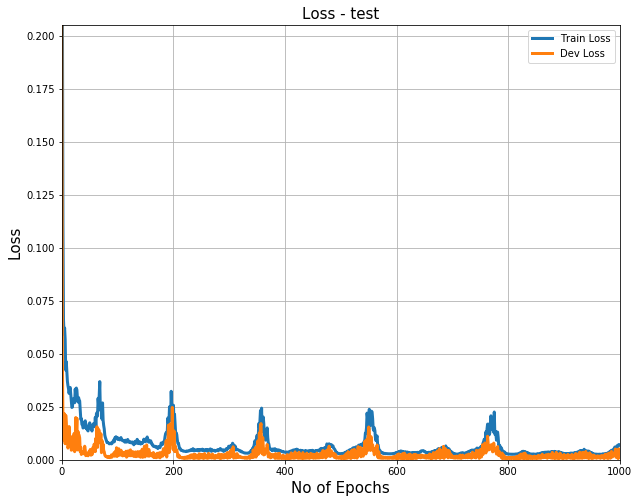

Training Set Score: 0.8935
Dev Set Score: 0.8269
Test Set Score: 0.6340
Training Set MSE: 36012.3181
Dev Set MSE: 25885.9076
Test Set MSE: 8223.4089


<Figure size 720x576 with 0 Axes>

In [22]:
plot_loss(history, title='test')
plt.savefig('loss_LSTM_512_1024_lb25_well_' + str(i))
train_mse, train_acc = mean_squared_error(y_train_act, y_pred_train), r2_score(y_train_act, y_pred_train)
dev_mse, dev_acc = mean_squared_error(y_dev_act, y_pred_dev), r2_score(y_dev_act, y_pred_dev)
test_mse, test_acc = mean_squared_error(y_test_act, y_pred_test), r2_score(y_test_act, y_pred_test)

print('Training Set Score: %1.4f' % train_acc)
print('Dev Set Score: %1.4f' % dev_acc)
print('Test Set Score: %1.4f' % test_acc)

print('Training Set MSE: %1.4f' % train_mse)
print('Dev Set MSE: %1.4f' % dev_mse)
print('Test Set MSE: %1.4f' % test_mse)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


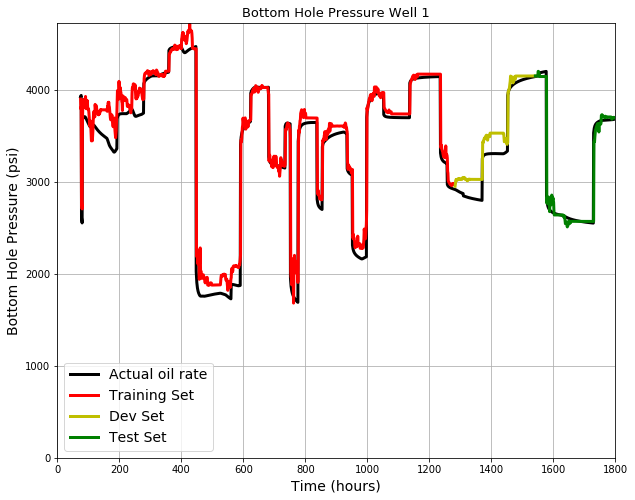

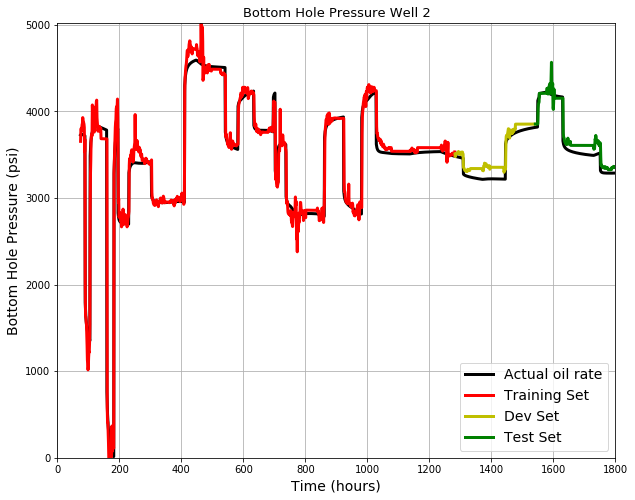

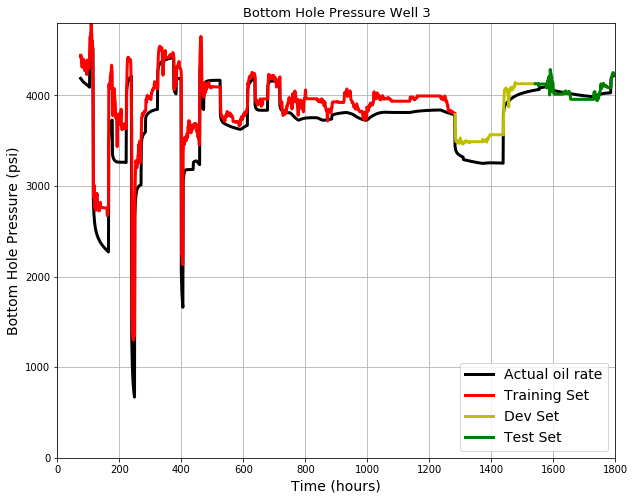

In [23]:


for i in range(y_act.shape[1]):
    plot_pressure(t[-len(y_act):].as_matrix(),
                   y_act[:, i], y_pred[:, i], dev_fraction=dev_fraction, test_fraction=test_fraction, well=i+1)
    plt.savefig('plot_LSTM_512_1024_lb25_well_' + str(i))

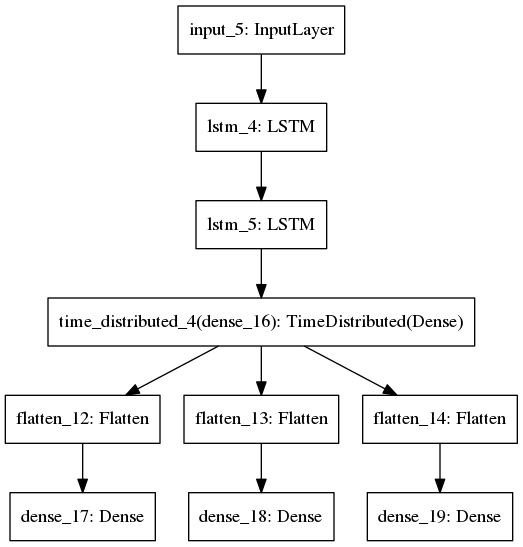

In [24]:
plot_model(model)

In [25]:
# Install a Drive FUSE wrapper.
# https://github.com/astrada/google-drive-ocamlfuse
!apt-get update -qq 2>&1 > /dev/null
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse

E: Package 'python-software-properties' has no installation candidate
E: Package 'module-init-tools' has no installation candidate
/bin/sh: 1: add-apt-repository: not found
E: Unable to locate package google-drive-ocamlfuse


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  app.launch_new_instance()


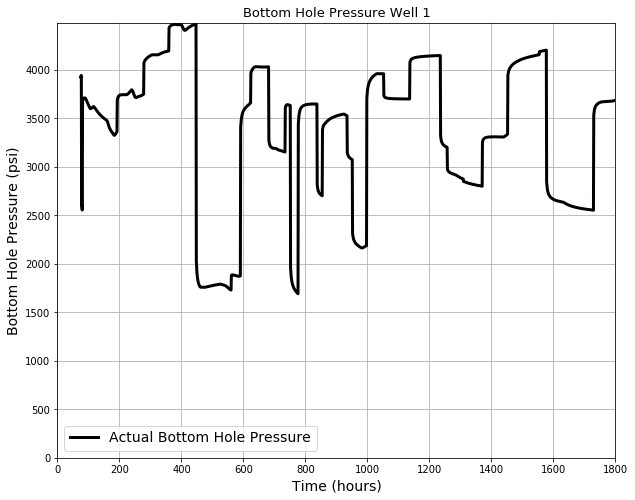

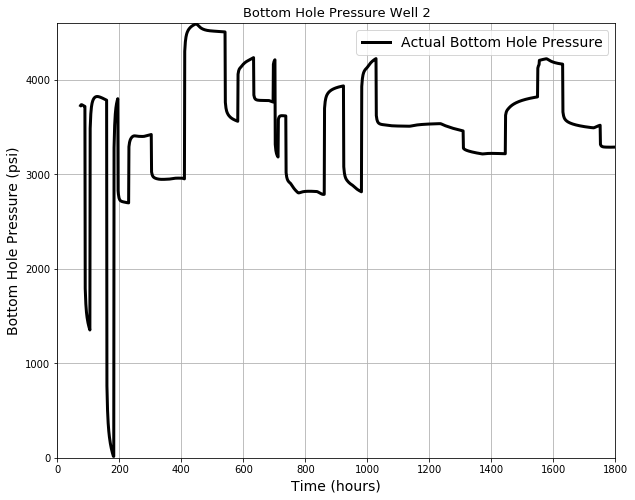

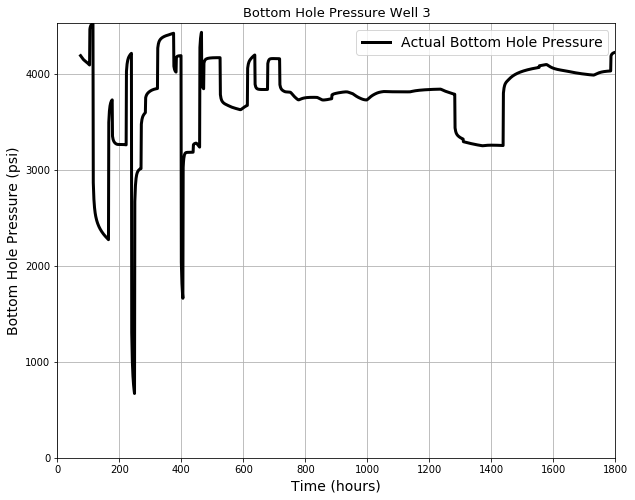

In [26]:
def plot_pressure_actual(t, q_actual, dev_fraction, test_fraction, well):
    """This function plots actual and predicted bottom hole pressure"""
    # Plotting pwf v time
    plt.figure()
    plt.plot(t, q_actual, 'k-', linewidth=3, label='Actual Bottom Hole Pressure')

    plt.xlabel("Time (hours)", fontsize=14)
    plt.ylabel("Bottom Hole Pressure (psi)", fontsize=14)
    plt.title("Bottom Hole Pressure Well "+str(well), y=1, fontsize=13)
    plt.legend(loc="best", prop=dict(size=14))
    plt.xlim(0, max(t))
    plt.ylim(0, max(q_actual) + 10)
    plt.grid(True)

for i in range(y_act.shape[1]):
    plot_pressure_actual(t[-len(y_act):].as_matrix(),
                   y_act[:, i], dev_fraction=dev_fraction, test_fraction=test_fraction, well=i+1)
    #plt.savefig('plot_LSTM_512_1024_lb25_well_' + str(i))

In [27]:
# Training

y_train_act = scaler_y.inverse_transform(y_train)

# Dev

y_dev_act = scaler_y.inverse_transform(y_dev)

# Test

y_test_act = scaler_y.inverse_transform(y_test)

# Train-Dev-Test
y_act = np.concatenate([y_train_act, y_dev_act, y_test_act])


In [28]:
# Create a directory and mount Google Drive using that directory.
!mkdir -p drive
!google-drive-ocamlfuse drive

print ('Files in Drive:')
!ls drive/

# Create a file in Drive.
!echo "This newly created file will appear in your Drive file list." > drive/created.txt

/bin/sh: 1: google-drive-ocamlfuse: not found
Files in Drive:


In [30]:
os.chdir('drive/Stanford')
os.getcwd()
